# Прогнозирование стоимости автомобиля по характеристикам


Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам. По условиям задачи автомобили должны быть из г. Москва. Так как в тестовой выборке марка - BMW, то будем считать, что и выборка, на которой будем обучаться и для которой предсказывать - тоже BMW. Но в целом модель должна быть не привязана к марке автомобиля. Собрать более крупную базу для обучения модели нужно с сайта  https://auto.ru/.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
import sys
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.tree import ExtraTreeRegressor
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.base import clone

from tqdm import tqdm # обеспечивает простой индикатор выполнения для операций pandas
%matplotlib inline

In [ ]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# General Setup

In [3]:
DIR_TRAIN  = '../input/train-data-autoru/' # подключил к ноутбуку свой внешний датасет
DIR_TEST   = '../input/sf-dst-car-price/'

# Data

In [3]:
!ls ../input/

sf-dst-car-price  train-data-autoru


# Посмотрю для начала, что из себя представляет тестовая выборка

In [4]:
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

## EDA для тестовой выборки

Цель данного упражнения:

* Ознакомиться с данными, которые у нас есть
* Понять, какую информацию мы сможем из них взять
* Понять, какие данные влияют на целевую переменную, а какие нет
* Понять, какие данные необходимо собирать из внешних источников
* Сформировать желаемый вид датасета, к которому будем стремиться преобразовать собранные данные

### Первичный осмотр тестовых данных

In [ ]:
test.sample(5)

In [ ]:
test.info()

Для удобства переименую столбцы на английском и в одном стиле (мне привычнее разделять слова нижним подчеркиванием)

In [5]:
test.columns = ([
    'body_type',
    'brand',
    'color',
    'fuel_type',
    'model_date_begin',
    'name',
    'number_of_doors',
    'production_date',
    'vehicle_configuration',
    'vehicle_transmission',
    'engine_displacement',
    'engine_power',
    'description',
    'mileage',
    'equipment',
    'gear_type',
    'steering_wheel',
    'not_damage',
    'owners',
    'technical_passport',
    'custom_clear',
    'ownership',
    'id',
])

In [ ]:
test.info()

Пропуски есть в колонке ownership (владение)

Напишу функцию, которая выдаст необходимую информацию для первичного анализа признака (посмотрел это решение у коллег по цеху - мне понравилось и я решил взять его на вооружение)

In [ ]:
def col_info(col):
    print('Количество пропусков: {}'.format(col.isnull().sum()))
    print('{},'.format(col.describe()))
    print('Распределение:\n{},'.format(col.value_counts()))
    col.hist()

Применим функцию для анализа признака:

### model_date_begin - посмотрим на год модели (марки) автомобиля

In [ ]:
col_info(test.model_date_begin)

Ок. Для начала приведу год в числу без цифер после точки в конце. Пойду более полным путем - сначала приведу к to_datetime, а потом вытащу оттуда год

In [6]:
test['model_date_begin'] = pd.to_datetime(test['model_date_begin'], format='%Y').dt.year

In [ ]:
col_info(test.model_date_begin)

In [ ]:
test.model_date_begin.min()

In [ ]:
test.model_date_begin.max()

Видим, что автомобили представлены марками от 1975 по 2019 год.

Попробую сформировать новый признак - "возраст модели" (model_age). Время буду считать от текущего времени.

In [7]:
test['model_age'] = datetime.datetime.now().year - test['model_date_begin']

### model_age - посмотрим на возраст модели

In [ ]:
col_info(test.model_age)

Большая часть автомобилей представлена моделями 9-13 лет. Но много и достаточно современных моделей (марок) автомобилей - до 6 лет. Есть какие-то откровенно старые автомобили - более 45 лет модели. Посмотрю, не ошибка ли это.

In [ ]:
test[test['model_age'] > 40]

Посмотрел в интернете - действительно есть такие модели. Что ж, пусть остаются в базе для обучения модели.

Сделаем признак категориальным, все модели старше 19 лет положим в одну категорию.

In [8]:
test['model_age'] = test['model_age'].apply(lambda x: 20 if x > 19 else x)

Ну и переведу его к тестовому значению, чтобы это стало категорией

In [9]:
test['model_age'] = test['model_age'].astype('str')

### production_date - посмотрим на год производства самого автомобиля

In [ ]:
col_info(test.production_date)

Проделаю ту же операцию, что и с возрастом марки автомобиля

In [10]:
test['production_date'] = pd.to_datetime(test['production_date'], format='%Y').dt.year

Ну и добавлю колонку с возрастом автомобиля

In [11]:
test['car_age'] = datetime.datetime.now().year - test['production_date']

### car_age - посмотрим на возраст самого автомобиля

In [ ]:
col_info(test.car_age)

Медианный возраст автомобиля - 7 лет. Ну ок. Посмотрим, что нам это даст в будущем.

In [ ]:
test.sample(2)

Попробую сгруппировать автомобили по их возрасту на основании каких-то своих личных субъективных ощущений

In [12]:
def cat_age(x):
    if x == 1 : x = 1 # типа, если автомобилю 1 год, то добавим его в категорию 1
    elif 2 <= x < 4: x = 2 # типа, если автомобилю от 2 до 3 лет включительно, то добавим его в категорию 2 и тд.
    elif 4 <= x < 6: x = 3
    elif 6 <= x < 10: x = 4
    elif 10 <= x < 16: x = 5
    elif 16 <= x < 20: x = 6
    elif 20 <= x: x = 7
    return x 

In [13]:
test['car_age'] = test['car_age'].apply(lambda x: cat_age(x))

In [14]:
test['car_age'] = test['car_age'].astype('str')

### number_of_doors - посмотрим на возраст самого автомобиля

Так, посмотрим на количество дверей - там мне не нравится формат данных. Скорее всего надо перевести их просто в int

In [ ]:
col_info(test.number_of_doors)

In [15]:
test['number_of_doors'] = test['number_of_doors'].astype(int)

In [ ]:
col_info(test.number_of_doors)

### custom_clear - посмотрим что с растаможкой

In [ ]:
col_info(test.custom_clear)

Ок. По идее состояния может быть 2 вида - растаможен и не растаможен. Но в таблице у нас все растаможенные. Переведем его в булиан вид, где 1 - растаможен, все остальное - 0.

In [16]:
test['custom_clear'] = test['custom_clear'].apply(lambda x: "1" if x == "Растаможен" else "0").astype(int)

In [361]:
test['custom_clear'].value_counts()

1    3837
Name: custom_clear, dtype: int64

In [ ]:
test.sample(2)

Так как в тестовом все автомобили растаможены, то можно удалить этот признак, так как он не имеет никакого смысла

In [17]:
test = test.drop('custom_clear', axis=1)

Так, ну, колонку id тоже можно удалить.

In [18]:
test = test.drop('id', axis=1)

In [ ]:
test.sample(2)

### body_type - посмотрим, что там с кузовом

In [ ]:
col_info(test.body_type)

In [ ]:
test[['body_type','number_of_doors']]

In [ ]:
test.groupby('body_type').agg({'number_of_doors': 'value_counts'})

Не вижу особого смысла в названии сохранять кол-во дверей - они и так соответствуют колонке

In [19]:
# Новый датафрейм с разбитыми данными из нужно мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
body_type_tmp = test['body_type'].str.split(" ", n = 1, expand = True) 
  
# Возьму теперь первую часть из нового созданного датафрейма, там будет нужное мне название типа кузова, и создам колонку в полном датафрейме
test['body_type']= body_type_tmp[0]

In [ ]:
test.sample(2)

Поменяю русские названия типа кузова на английский аналог

In [20]:
# словарь для кодировки
dic_body_type = {
    'внедорожник': 'allroad',
    'кабриолет': 'cabriolet',
    'компактвэн': 'compact_van',
    'купе': 'coupe',
    'лифтбек': 'liftback',
    'родстер': 'roadster',
    'седан': 'sedan',
    'универсал': 'station_wagon',
    'хэтчбек': 'hatchback'
}

test['body_type'] = test['body_type'].map(dic_body_type)

In [ ]:
test.groupby('body_type').agg({'number_of_doors': 'value_counts'})

Пока не буду делать dummy преобразование, так как CatBoost и сам это может сделать. Для других алгоритмов буду смотреть целесообразность позже

In [ ]:
# test = pd.get_dummies(test, columns=[ 'body_type',], dummy_na=True)

In [ ]:
test.sample(5)

### color - посмотрим, что с цветом

In [ ]:
col_info(test.color)

Для частного случая не сложно переименовать цвета через словарь. А для общего случая как быть? Пока не ясно. Ну ладно. Сделаю пока частный случай.

In [21]:
dict_color = {
    'чёрный': 'black',
    'белый': 'white',
    'синий': 'blue',
    'коричневый': 'brown',
    'красный': 'red',
    'серый': 'grey',
    'бежевый': 'beige',
    'серебристый': 'silver',
    'золотистый': 'gold',
    'оранжевый': 'orange',
    'голубой': 'mid_blue',
    'пурпурный': 'purple',
    'жёлтый': 'yellow',
    'зелёный': 'green',
    'фиолетовый': 'violet'
}

test['color'] = test['color'].map(dict_color)

In [ ]:
test.sample(5)

### fuel_type - посмотрим, что там с типом топлива

In [ ]:
col_info(test.fuel_type)

In [22]:
dict_fuel_type = {
    'дизель': 'diesel',
    'бензин': 'gasoline',
    'гибрид': 'hybrid',
    'электро': 'electro'
}

test['fuel_type'] = test['fuel_type'].map(dict_fuel_type)

### vehicle_transmission - посмотрим, что там с коробкой

In [ ]:
col_info(test.vehicle_transmission)

In [23]:
dict_vehicle_transmission = {
    'автоматическая': 'AT',
    'механическая': 'MT',
    'роботизированная': 'AMT'
}

test['vehicle_transmission'] = test['vehicle_transmission'].map(dict_vehicle_transmission)

In [ ]:
test.info()

### brand - марка автомобиля

Так как работать мы будем только с одной маркой автомобиля - BWM, то нет никакого смысла в данном признаке. Удалим его.

In [24]:
test = test.drop('brand', axis=1)

### engine_displacement - посмотрим, что это

In [ ]:
col_info(test.engine_displacement)

Так, это у нас объем двигателя. Судя по всему, LTR - это литр. Значит это можно отсечь и оставить только цифру и перевести колонку во float

In [25]:
test['engine_displacement'] = test.engine_displacement.apply(lambda x: x.replace('LTR', '').replace(' ', ''))

У нас есть автомобиль, у которого объем не указан в соответствующей колонке-признаке не указан. Посмотрим на этот автомобиль. Тут нам поможет информация из колонки ТТХ.

In [371]:
test[test['engine_displacement'] == 'undefined']

,body_type,color,fuel_type,model_date_begin,name,number_of_doors,production_date,vehicle_configuration,vehicle_transmission,engine_displacement,...,mileage,equipment,gear_type,steering_wheel,not_damage,owners,technical_passport,ownership,model_age,car_age
823,hatchback,white,electro,2013,Electro AT (126 кВт),5,2016,HATCHBACK_5_DOORS AUTOMATIC,AT,undefined,...,52900.0,"['[{""name"":""Безопасность"",""values"":[""Антипробу...",задний,Левый,Не требует ремонта,1 владелец,Оригинал,NaN,7,3


Посмотрим, есть ли у него где-то объем двигателя

In [ ]:
test[test['engine_displacement'] == 'undefined']['equipment'].values

In [ ]:
test[test['engine_displacement'] == 'undefined']['vehicle_configuration'].values

А, понял. Это же электродвигатель. У него нет объема. Может быть для таких типов двигателя ставить объем 0? Так и сделаю до появления новой информации.

In [26]:
test.loc[test['engine_displacement'] == 'undefined', 'engine_displacement'] = 0

In [27]:
test['engine_displacement'] = test['engine_displacement'].astype(float)

### vehicle_configuration - посмотрим, что это

In [ ]:
col_info(test.vehicle_configuration)

Так, пока оставим колонку vehicle_configuration - это некая сводная статистика про ТТХ автомобиля. Может быть где-то еще будут какие-то автомобили с пропущенными признаками - будем здесь искать. **А в конце потом подчистим эту колонку.**

In [ ]:
# test = test.drop('vehicle_configuration', axis=1)

### engine_power - по ходу, это мощность двигателя

In [ ]:
col_info(test.engine_power)

In [ ]:
test.groupby('name').agg({'engine_power': 'value_counts'})

Так, хорошо. Уже становится понятно, что первое число в engine_power - это лошадиные силы. остальное - это какая-то модификация двигателя. это важно, поэтому нужно отдельно вычленить это в признак.

In [28]:
# Новый датафрейм с разбитыми данными из нужно мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
engine_power_tmp = test['engine_power'].str.split(" ", expand = True) 

In [ ]:
engine_power_tmp[1].value_counts()

In [29]:
# Возьму данные из первой колонки и подкорректирую признак с мощностью двигателя
test['engine_power']= engine_power_tmp[0]

# ну и приведу колонку сразу к числовому типу
test['engine_power'] = test['engine_power'].astype(int)

### name - по ходу, это название модификации автомодиля (модели)

In [ ]:
test[['name', 'engine_displacement', 'fuel_type', 'vehicle_transmission', 'engine_power']].sample(20)

Из этого мы видим, что в названии зашиты мощность двигателя, объем, коробка, тип привода, тип топлива. То есть это все можно отсечь, чтобы найти название модели и оставить только его в даном признаке. Но все равно есть такие названия, у которых вначале НЕ указана конкретная модель автомобиля, а просто идут перечисления мощности двигателя, объема, коробки, типа привода, типа топлива. Кое-какое решение как сделать название однозначным нашел. Есть пара пропусков - сделаю для них название какое-то noname. Посмотрим как это повлияет на предсказание и получится ли так же сделать с данными, которые будут спарсены.

In [30]:
# Новый датафрейм с разбитыми данными из нужной мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
name_tmp = test['name'].str.split(" ", n = 2, expand = True) 

In [ ]:
# name_tmp.sample(10)

In [ ]:
# name_tmp[1].replace(to_replace='[0-9].', value='', inplace=True, regex=True)

In [ ]:
name_tmp.sample(10)

In [ ]:
name_tmp

In [31]:
# попробуем склеить первые две колонки, чтобы получить название модели автомобиля, но при этом будем соблюдать некоторые условия:
# в первой колонке в строчке должно содержаться d, i, Competition, а по второй xDrive, Competition, sDrive, Package
# конъюнкция двух признаков
def make_conj(data, feature1, feature2):
    data['tmp_1'] = np.where(~data[feature2].str.contains('xDrive|Competition|sDrive|Package'),
                                 '', data[feature2])
    
    data['tmp_0'] = np.where(~data[feature1].str.contains('d|i|Competition'),
                                 '', data[feature1])
    
    data['tmp'] = data['tmp_0'] + ' ' + data['tmp_1']
                    
    return (data)

# выполним корректировку названия
make_conj(name_tmp, 0, 1)

,0,1,2,tmp_1,tmp_0,tmp
0,520d,2.0d,AT (190 л.с.),,520d,520d
1,318d,2.0d,AT (150 л.с.),,318d,318d
2,550i,xDrive,4.4 AT (407 л.с.) 4WD,xDrive,550i,550i xDrive
3,30d,3.0d,AT (249 л.с.) 4WD,,30d,30d
4,M50d,3.0d,AT (381 л.с.) 4WD,,M50d,M50d
...,...,...,...,...,...,...
3832,520i,2.0,AT (184 л.с.),,520i,520i
3833,30d,3.0d,AT (249 л.с.) 4WD,,30d,30d
3834,525xi,2.5,AT (218 л.с.) 4WD,,525xi,525xi
3835,528i,xDrive,2.0 AT (245 л.с.) 4WD,xDrive,528i,528i xDrive


In [ ]:
name_tmp.sample(10)

In [32]:
name_tmp.drop([0, 1, 2], axis=1, inplace=True,)

In [33]:
test['name'] = name_tmp['tmp']

Нашел в датасете немного кривое название - xDrive20d (и ряд других). Хочу его поправить

In [34]:
test['name'] = test['name'].apply(lambda x: x.replace('xDrive20d', '20d xDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('sDrive18i', '18i sDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('sDrive20i', '20i sDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('xDrive18d', '18d xDrive'))
test['name'] = test['name'].apply(lambda x: x.replace('xDrive20', '20 xDrive'))

Мне попадались названия с пробелами в конце. Удалю их. Проверю на всякий случай пробелы в конце и начале.

In [35]:
test['name'] = test['name'].str.strip()

In [ ]:
col_info(test.name)

### description - по ходу, это какое-то описание объявления; посмотрим на это

In [ ]:
print(test['description'][2])
print(len(test['description'][2]))

Есть идея просто посчитать количество символов в описании товара. Смысл в то, что чем больше (длиннее) описание, тем оно должно давать больше ценности в глазах покупателя. Считать буду для простоты количество символов в описании. Ну, пока что-то сложнее думать не охота.

In [36]:
test['description_score'] = test['description'].apply(lambda x: len(x) / 100).astype(float)

Ну и дропнем старую колонку с описанием

In [37]:
test = test.drop('description', axis=1)

Со временем пришел к выводу, что description_score тоже можно удалить, так как в трейне у меня нет описания, то пока не буду использовать это и на тесте. А там посмотрим.

In [38]:
test = test.drop('description_score', axis=1)

In [ ]:
test.sample(10)

### mileage - по ходу, это какое-то описание объявления; посмотрим на это

In [ ]:
col_info(test.mileage)

Я так понял, что это пробег. Тут вроде ок. Пропусков нет. 

In [ ]:
test[test['mileage'] < 10000]

Привеу к типу int, чтобы согласовать с трейном.

In [39]:
test['mileage'] = test['mileage'].astype(int)

Добавим новый признак: разделим пробег на группы, исходя из того, что в среднем авто (данные Автостат) проходит за год 17000 км каждая группа будет грубо (не всегда пробег правдив) отображать количество лет эксплуатации.

In [40]:
test['exp_year'] = test.mileage.apply(lambda x: x//17000 if x<=400000 else 400000//17000+1)

Заменим текущие значения на категории с разбивкой по 25 тыс.км. Автомобили с пробегом более 400 тыс.км. объединим в одну категорию.

In [41]:
def cat_mileage(x):
    if x < 25000: x = 1
    elif 25000 <= x < 50000: x = 2
    elif 50000 <= x < 75000: x = 3
    elif 75000 <= x < 100000: x = 4
    elif 100000 <= x < 125000: x = 5
    elif 125000 <= x < 150000: x = 6
    elif 150000 <= x < 175000: x = 7
    elif 175000 <= x < 200000: x = 8
    elif 200000 <= x < 225000: x = 9
    elif 225000 <= x < 250000: x = 10
    elif 250000 <= x < 275000: x = 11
    elif 275000 <= x < 300000: x = 12
    elif 300000 <= x < 325000: x = 13
    elif 325000 <= x < 350000: x = 14
    elif 350000 <= x < 375000: x = 15
    elif 375000 <= x < 400000: x = 16
    elif 400000 <= x: x = 17
    return x    

In [42]:
test['mileage'] = test['mileage'].apply(lambda x: cat_mileage(x))

In [43]:
test['mileage'] = test['mileage'].astype('str')

In [ ]:
test.info()

### equipment - интересно, что это?

In [ ]:
col_info(test.equipment)

Ух ты, прикольно. Это получается у нас комплектация автомобиля. Чуть позже подумаю, как это распарсить.

Напишем функцию, которая сделает полный список всех возможных фич в тестовой выборке.

In [44]:
def get_test_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    all_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\"(.+?)\"',data)
        # Добавляем в общий список
        all_features.extend(features)
    # Удаляем дубликаты
    all_features = list(dict.fromkeys(all_features))
    return all_features

Посмотрим на результат выполнения функции

In [45]:
test_features = get_test_features(test.equipment)

In [46]:
# Удаляем лишние записи
for bad_feature in ['name','Безопасность','values','Комфорт','Мультимедиа','Обзор','Салон','Защита от угона','Элементы экстерьера']:
    test_features.remove(bad_feature)    
print('Всего уникальных фич:', len(test_features))
print(test_features)

Всего уникальных фич: 170
['Антипробуксовочная система (ASR)', 'Система стабилизации (ESP)', 'Подушка безопасности водителя', 'Крепление детского кресла (задний ряд) ISOFIX', 'Подушки безопасности оконные (шторки)', 'Подушка безопасности пассажира', 'Подушки безопасности боковые задние', 'Подушки безопасности боковые', 'Датчик давления в шинах', 'Антиблокировочная система (ABS)', 'Блокировка замков задних дверей', 'Подушка безопасности для защиты коленей водителя', 'Система «старт-стоп»', 'Электростеклоподъёмники передние', 'Мультифункциональное рулевое колесо', 'Прикуриватель и пепельница', 'Бортовой компьютер', 'Усилитель руля', 'Электропривод зеркал', 'Электростеклоподъёмники задние', 'Парктроник передний', 'Регулировка руля по вылету', 'Климат-контроль 2-зонный', 'Электроскладывание зеркал', 'Парктроник задний', 'AUX', 'USB', 'Аудиосистема', 'Bluetooth', 'Датчик света', 'Автоматический корректор фар', 'Омыватель фар', 'Датчик дождя', 'Электрообогрев боковых зеркал', 'Светодиодные ф

Заменим значение параметра equipment в тестовой выборке на список фич.

In [47]:
def get_features_test(equipment): 
    features=re.findall(r'\"(.+?)\"',equipment)  
    return features

Сейчас в поле equipment будут попадать лишние записи, например, 'name','values' и т.д. Нам это не помешает.

In [48]:
test['equipment'] = test['equipment'].apply(lambda x: get_features_test(x))

In [ ]:
test.sample(5)

### gear_type - интересно, что это?

In [ ]:
col_info(test.gear_type)

Речь идет о типе привода. Ок. Заменим на английский и пойдем дальше. P.S. Интересно, что у BWM практически нет моделей с передним приводом. Для себя интересно. Как-то не задумывался об этом. Сам никогда не ездил на этой марке и не был владельцем.

In [49]:
dict_gear_type = {
    'задний': 'rear',
    'полный': '4w',
    'передний': 'front'
}

test['gear_type'] = test['gear_type'].map(dict_gear_type)

### steering_wheel - интересно, что это?

In [ ]:
col_info(test.steering_wheel)

Ага, steering_wheel - это с какой стороны руль. Ну, тут всего два варианта - или слева, или справа.

In [50]:
dict_steering_wheel = {
    'Левый': 'left',
    'Правый': 'right'
}

test['steering_wheel'] = test['steering_wheel'].map(dict_steering_wheel)

### state - интересно, что это?

In [ ]:
col_info(test.not_damage)

Странное название длял признака. Тут только один. Это значит, что для обучения тоже нужно будет спарсить только автомобили с таким статусом? Для работы с данным признаком переведу сразу к числовой категории

In [51]:
dict_not_damage = {
    'Не требует ремонта': '1'
}

test['not_damage'] = test['not_damage'].map(dict_not_damage)

# ну и приведу колонку сразу к числовому типу
test['not_damage'] = test['not_damage'].astype(int)

### owners - интересно, что это?

In [ ]:
col_info(test.owners)

Угу. Понятно. Речь идет о количестве владельцев.

In [52]:
# через словарь почему-то не захотело корректно менять. пришлочь через вхождение.
test['owners'] = np.where(test['owners'].str.contains('1'),
                                 '1', test['owners'])
test['owners'] = np.where(test['owners'].str.contains('2'),
                                 '2', test['owners'])
test['owners'] = np.where(test['owners'].str.contains('3'),
                                 '3', test['owners'])

# ну и приведу колонку сразу к числовому типу
test['owners'] = test['owners'].astype(int)

In [ ]:
test['owners']

In [ ]:
test.info()

### technical_passport - интересно, что это?

In [ ]:
col_info(test.technical_passport)

In [53]:
dict_technical_passport = {
    'Оригинал': 'original',
    'Дубликат': 'duplicate'
}

test['technical_passport'] = test['technical_passport'].map(dict_technical_passport)

### ownership - это у нас количество времени, которое было во владении (год + месяц)

Тут тоже в строке зашит и год, и месяц. Поэтому разделю сначала запись в строке на отдельные колонки, потом год умножу на 12 и приплюсую к месяцам. Получится в итоге сколько месяцев было во владении.

In [54]:
# Новый датафрейм с разбитыми данными из нужно мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
ownership_tmp = test['ownership'].str.split(" ", n = 4, expand = True) 
  
# Возьму теперь первую часть из нового созданного датафрейма, там будет нужное мне название типа кузова, и создам колонку в полном датафрейме
# test['body_type']= body_type_tmp[0]

In [ ]:
ownership_tmp

Не знаю, чем заполнить пропуски, чтобы не исказить информацию. А пропусков много - около 15% всего датасета. Удалять признак тоже не хочется... Мне он кажется значимым. 

In [484]:
ownership_tmp

,0,3
0,NaN,NaN
1,NaN,NaN
2,7,2
3,NaN,NaN
4,NaN,NaN
...,...,...
3832,NaN,NaN
3833,NaN,NaN
3834,1,7
3835,6,10


In [55]:
ownership_tmp = ownership_tmp.fillna(0)                             

Удалю лишние столбцы

In [56]:
ownership_tmp.drop([1, 2, 4], axis=1, inplace=True,)

In [57]:
ownership_tmp[0] = ownership_tmp[0].apply(lambda x: int(x) * 12).astype(int)

In [58]:
# ну и приведу колонку 3 (месяц) сразу к числовому типу
ownership_tmp[3] = ownership_tmp[3].astype(int)

Ну и вернем уже общее кол-во месяцев владения в базовый датасет

In [59]:
test['ownership'] = ownership_tmp[0] + ownership_tmp[3]

Но придется пока удалить, так как заполнил пропуски нулями и это будет искажать модель.

In [60]:
test = test.drop('ownership', axis=1)

Колонка с ТТХ вроде больше не нужна - удалю

In [61]:
test = test.drop('vehicle_configuration', axis=1)

In [ ]:
test.info()

### covid

Почитал в новостях, что после covid спрос на покупку автомобилей вырос. В то же время есть дефицит на новые авто. Следовательно, должны покупать больше бу автомобилей? Или наоброт - меньше продавать. Проверим этот фактор новым признаком. Предполагаю, что тестовую базу собрали еще или до объявления в России пандемии или только в ее начале. Поэтому для тестовых объявлений параметр будет 0. А для уже вновь собранных - 1

In [62]:
# Сделаю это категориальным признаком
test['covid'] = '0'

## Выводы по результатам EDA для тестовой выборки

Чего не хватает:

* В датасете нет однозначной информации о модели машины. Например, 30d может относиться к моделям X3, X3, X5, X6 и, возможно, ещё к каким-то. Видимо нам нужно будет научиться понимать модель по имеющимся данным (год выпуска, объем двигателя и т.д.). Но кое-как удалось мне сделать название, но не будет ли это искажением наоборот для модели?

При сборе данных из внешних источников мы будем использовать следующие фильтры:

* Марка - БМВ до 2019 года производства
* Автомобили с пробегом
* Левый руль
* Состояние - не требует ремонта
* Растаможен

# Теперь глянем на данные, которые мы спарсили из Авто.ру

In [63]:
train = pd.read_csv(DIR_TRAIN+'train_data_auto_ru.csv') # мой подготовленный датасет для обучения модели

In [ ]:
train.sample(5)

In [ ]:
train.info()

Сделаю некоторые переименования

In [64]:
train = train.rename(columns={'pts_origin': 'technical_passport', 'complectation': 'equipment', 'model_name': 'series'})

Удалим сразу неиспользуюмые колонки

In [65]:
train = train.drop(columns=['brand'])

### mileage

In [66]:
train['exp_year'] = train.mileage.apply(lambda x: x//17000 if x<=400000 else 400000//17000+1)

In [67]:
train['mileage'] = train['mileage'].apply(lambda x: cat_mileage(x))
train['mileage'] = train['mileage'].astype('str')

### gear_type - что это?

In [ ]:
col_info(train.gear_type)

Приведем к одному виду с тестовой выборкой

In [68]:
dict_gear_type = {
    'REAR_DRIVE': 'rear',
    'ALL_WHEEL_DRIVE': '4w',
    'FORWARD_CONTROL': 'front'
}

train['gear_type'] = train['gear_type'].map(dict_gear_type)

### steering_wheel - что это?

In [ ]:
col_info(train.steering_wheel)

In [69]:
dict_steering_wheel = {
    'LEFT': 'left',
    'RIGHT': 'right'
}

train['steering_wheel'] = train['steering_wheel'].map(dict_steering_wheel)

### equipment

Напишем функцию, которая создаст список фич для тренировочной выборки.

In [70]:
def get_autoru_features(equipment):
    # Создаем пустой список, в который будут добавляться все фичи
    autoru_features = []
    for data in equipment:
        # Находим все слова между кавычками
        features=re.findall(r'\'(.+?)\'',data)
        # Добавляем в общий список
        autoru_features.extend(features)
    # Удаляем дубликаты
    autoru_features = list(dict.fromkeys(autoru_features))
    return autoru_features

Посмотрим на результат.

In [71]:
autoru_features = get_autoru_features(train.equipment)  
print('Всего уникальных фич:', len(autoru_features))
print(autoru_features)

Всего уникальных фич: 277
['cruise-control', 'asr', 'esp', 'airbag-driver', 'aux', 'multi-wheel', 'xenon', 'automatic-lighting-control', 'airbag-passenger', 'vsm', 'computer', 'bas', 'wheel-power', 'lock', 'electro-mirrors', 'alloy-wheel-disks', '18-inch-wheels', 'airbag-side', 'mirrors-heat', 'hatch', 'volume-sensor', 'audiosystem-cd', 'abs', 'wheel-configuration2', 'wheel-configuration1', 'immo', 'climate-control-2', 'engine-proof', 'tinted-glass', 'start-stop-function', 'adaptive-light', 'usb', 'light-sensor', 'audiopreparation', 'airbag-curtain', 'ashtray-and-cigarette-lighter', 'passenger-seat-updown', 'high-beam-assist', 'servo', 'drl', 'airbag-rear-side', '16-inch-wheels', 'leather-gear-stick', 'ptf', 'rain-sensor', 'voice-recognition', 'tyre-pressure', 'dark-interior', 'combo-interior', 'front-seats-heat', 'power-child-locks-rear-doors', 'wheel-leather', 'climate-control-1', 'park-assist-r', '12v-socket', 'knee-airbag', 'black-roof', 'sport-seats', 'heated-wash-system', 'front-

Итого у нас 277 фичи с авто.ру и 170 из тестовой выборки. Можно сделать словарь из этих записей, но это довольно рутинная работа. Сделаем для этого параметра в тренировочной выборки dummy-переменные и на основе корреляционного анализа, выберем самые значимые фичи.

Для начала преобразуем признак для выборки с train в список (сейчас он идет сплошным текстом). Напишем функцию.

In [72]:
def get_features_train(equipment):      
    features=re.findall(r'\'(.+?)\'',equipment)
    return features

Применим функцию для тренировочного датасета.

In [73]:
train['equipment'] = train['equipment'].apply(lambda x: get_features_train(x))

In [ ]:
train.sample(5)

Создадим dummy variables для фич. Проделаем эту работу на копии датасета с автру, чтобы не портить оригинал.

In [74]:
train_equipment = train.copy()

# Функция для отображения фич в записи
def find_item(cell):
    if item in cell:
        return 1
    return 0
# Создаем набор фич
features = set()
for featurelist in train_equipment['equipment']:
    for feature in featurelist:
        features.add(feature)
# Cоздаем столбцы с фичами и заполняем 0 или 1
for item in features:
    train_equipment[item] = train_equipment['equipment'].apply(find_item)

Сделаем отбор фич с коэффициентом корреляции > 0.3

In [75]:
cor_target = abs(train_equipment.corr()["price"])
relevant_features = cor_target[cor_target>0.3] # Выбираем фичи с значением модуля коэффициента корреляции > 0.3
relevant_features

model_date_begin         0.643219
model_date_end           0.628345
production_date          0.656279
engine_power             0.415372
owners                   0.532549
                           ...   
front-centre-armrest     0.418671
bas                      0.574077
electronic-gage-panel    0.528832
voice-recognition        0.464752
passenger-seat-updown    0.366428
Name: price, Length: 96, dtype: float64

Создадим список значимых фич. Некоторые фичи не включаем т.к. не нашлось аналога в тестовой выборке.

In [76]:
equipment_list = [
    'high-beam-assist',
    'front-seats-heat-vent',
    'bluetooth',
    'laser-lights',
    'light-sensor',
    'adaptive-light',
    'apple-carplay',
    'electro-trunk',
    'third-row-seats',
    'keyless-entry',
    'activ-suspension',
    'multizone-climate-control',
    'body-kit',
    'projection-display',
    'start-stop-function',
    'start-button',
    'paint-metallic',
    'wheel-heat',
    'passenger-seat-electric',
    'rain-sensor',
    'navigation',
    'voice-recognition',
    'multi-wheel',
    'airbag-curtain',
    'glonass',
    'auto-mirrors',
    'usb',
    'power-latching-doors',
    'led-lights',
    'auto-park',
    'bas',
    'isofix',
    'tyre-pressure',
    'air-suspension',
    'decorative-interior-lighting',
    '360-camera',
    'wireless-charger',
    'electronic-gage-panel',
]

Создадим словарь для замены фич в тестовой выборке

In [77]:
equipment_dict = {
    'Система управления дальним светом': 'high-beam-assist',
    'Вентиляция передних сидений': 'front-seats-heat-vent',
    'Bluetooth': 'bluetooth',
    'Лазерные фары': 'laser-lights',
    'Датчик света': 'light-sensor',
    'Система адаптивного освещения': 'adaptive-light',
    'CarPlay': 'apple-carplay',
    'Электропривод крышки багажника': 'electro-trunk',
    'Третий ряд сидений': 'third-row-seats',
    'Система доступа без ключа': 'keyless-entry',
    'Активная подвеска': 'activ-suspension',
    'Климат-контроль многозонный': 'multizone-climate-control',
    'Обвес кузова': 'body-kit',
    'Проекционный дисплей': 'projection-display',
    'Система «старт-стоп»': 'start-stop-function',
    'Запуск двигателя с кнопки': 'start-button',
    'Металлик': 'paint-metallic',
    'Обогрев рулевого колеса': 'wheel-heat',
    'Электрорегулировка передних сидений': 'passenger-seat-electric',
    'Датчик дождя': 'rain-sensor',
    'Навигационная система': 'navigation',
    'Голосовое управление': 'voice-recognition',
    'Мультифункциональное рулевое колесо': 'multi-wheel',
    'Подушки безопасности оконные (шторки)': 'airbag-curtain',
    'ЭРА-ГЛОНАСС': 'glonass',
    'Электроскладывание зеркал': 'auto-mirrors',
    'USB': 'usb',
    'Доводчик дверей': 'power-latching-doors',
    'Светодиодные фары': 'led-lights',
    'Система автоматической парковки': 'auto-park',
    'Система помощи при торможении (BAS, EBD)': 'bas',
    'Крепление детского кресла (передний ряд) ISOFIX': 'isofix',
    'Датчик давления в шинах': 'tyre-pressure',
    'Пневмоподвеска': 'air-suspension',
    'Декоративная подсветка салона': 'decorative-interior-lighting',
    'Камера 360°': '360-camera',
    'Беспроводная зарядка для смартфона': 'wireless-charger',
    'Электронная приборная панель': 'electronic-gage-panel',
}

Заменим название значимых фич в тестовой выборке. Незначимые фичи оставим без изменений.

In [78]:
def test_feature_change(x):
    x = [equipment_dict.get(a) if equipment_dict.get(a) else a for a in x]
    return x

In [79]:
test['equipment'] = test['equipment'].apply(lambda x: test_feature_change(x))

Удалим из признака equipment все фичи кроме значимых для тестовой и тренировочной выборки.

In [80]:
def main_feature(x):
    super_features = []
    for equipment in x:
        if equipment in equipment_list:
            super_features.append(equipment)
    x = super_features
    return x

In [81]:
train['equipment'] = train['equipment'].apply(lambda x: main_feature(x))

In [82]:
test['equipment'] = test['equipment'].apply(lambda x: main_feature(x))

Создадим dummy-переменные для тестовой и тренировочной выборки

In [83]:
for item in equipment_list:
    train[item] = train['equipment'].apply(find_item)

In [84]:
for item in equipment_list:
    test[item] = test['equipment'].apply(find_item)

Таким образом мы получили dummy-переменные с наиболее коррелирующими с целевой переменной фичами автомобиля. Удалим столбец equipment.

### not_damage - что это?

In [ ]:
col_info(train.not_damage)

In [85]:
train['not_damage'] = train['not_damage'].astype(int)

### technical_passport - что это?

In [ ]:
col_info(train.technical_passport)

In [ ]:
train['technical_passport']

In [86]:
dict_technical_passport = {
    'ORIGINAL': 'original',
    'DUPLICATE': 'duplicate'
}

train['technical_passport'] = train['technical_passport'].map(dict_technical_passport)

train['technical_passport'] = train['technical_passport'].fillna('Unknown')

### custom_clear - что это?

In [ ]:
col_info(train.custom_clear)

In [87]:
train['custom_clear'] = train['custom_clear'].astype(int)

In [88]:
train = train.drop(columns=['custom_clear'])

### body_type

In [ ]:
col_info(train.body_type)

Да уж, бмвехи со своим рядом кузовов намудрили. Почитал в интернетах - так и есть, это все разные модификации. Придется это учитывать.

### model_date_begin

In [ ]:
col_info(train.model_date_begin)

In [89]:
train['model_date_begin'] = pd.to_datetime(train['model_date_begin'], format='%Y').dt.year

train['model_age'] = datetime.datetime.now().year - train['model_date_begin']

In [90]:
train['model_age'] = train['model_age'].apply(lambda x: 20 if x > 19 else x)
train['model_age'] = train['model_age'].astype('str')

### production_date

In [ ]:
col_info(train.model_date_begin)

In [91]:
train['production_date'] = pd.to_datetime(train['production_date'], format='%Y').dt.year

train['car_age'] = datetime.datetime.now().year - train['production_date']

In [92]:
train['car_age'] = train['car_age'].apply(lambda x: cat_age(x))
train['car_age'] = train['car_age'].astype('str')

### number_of_doors

In [ ]:
col_info(train.number_of_doors)

### fuel_type

In [ ]:
col_info(train.fuel_type)

In [93]:
dict_fuel_type = {
    'DIESEL': 'diesel',
    'GASOLINE': 'gasoline',
    'HYBRID': 'hybrid',
    'ELECTRO': 'electro'
}

train['fuel_type'] = train['fuel_type'].map(dict_fuel_type)

### vehicle_transmission

In [ ]:
col_info(train.vehicle_transmission)

In [94]:
dict_vehicle_transmission = {
    'AUTOMATIC': 'AT',
    'MECHANICAL': 'MT',
    'ROBOT': 'AMT'
}

train['vehicle_transmission'] = train['vehicle_transmission'].map(dict_vehicle_transmission)

### engine_displacement

In [ ]:
col_info(train.engine_displacement)

Мне нужно привести к одному стилю данные из трейна и теста. Разделю данные из трейна на 1000 (приведу к дробной части объем) и округлю до десятых - тогда будет как в тесте.

In [95]:
train['engine_displacement'] = train['engine_displacement'].astype(float)
train['engine_displacement'] = round((train['engine_displacement'] / 1000), 1)

### engine_power

In [ ]:
col_info(train.engine_power)

### owners

In [ ]:
col_info(train.owners)

Очень много пропусков. Чем заполнить? Так и быть, заполню единицами, так как у бу автомобиля не может не быть хотя бы одного владельца. А там будет видно - может сделую медиану или среднюю. Но все равно ~15% датасета содержит пропуски по количеству владельцев автомобиля. Не хорошо.

In [96]:
train['owners'] = train['owners'].fillna(1)

In [97]:
# приведу к числовому виду
train['owners'] = train['owners'].astype(int)

### engine_power

In [ ]:
col_info(train.engine_power)

### name

In [ ]:
col_info(train.name)

In [98]:
# Новый датафрейм с разбитыми данными из нужной мне колонки - сделаю так, чтобы это было решением не частным, а для всех случаев
name_tmp = train['name'].str.split(" ", n = 2, expand = True) 


# попробуем склеить первые две колонки, чтобы получить название модели автомобиля, но при этом будем соблюдать некоторые условия:
# в первой колонке в строчке должно содержаться d, i, Competition, а по второй xDrive, Competition, sDrive, Package
# конъюнкция двух признаков
def make_conj(name, feature1, feature2):
    
    
    name['tmp_0'] = np.where(~name[feature1].str.contains('d|i|Competition'),
                                 '', name[feature1])
    
    name['tmp_1'] = np.where(~name[feature2].str.contains('xDrive|Competition|sDrive|Package'),
                                 '', name[feature2])
    
    
    name['tmp'] = name['tmp_0'] + ' ' + name['tmp_1']
                    
    return (name)

# выполним корректировку названия
make_conj(name_tmp, 0, 1)


train['name'] = name_tmp['tmp']

train['name'] = train['name'].apply(lambda x: x.replace('xDrive20d', '20d xDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('sDrive18i', '18i sDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('sDrive20i', '20i sDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('xDrive18d', '18d xDrive'))
train['name'] = train['name'].apply(lambda x: x.replace('xDrive20', '20 xDrive'))

In [99]:
train['name'] = train['name'].str.strip()

In [ ]:
name_tmp.sample(10)

In [ ]:
train[['name', 'model_name', 'engine_displacement', 'fuel_type', 'vehicle_transmission', 'engine_power']].sample(20)

Судя по всему, есть названия, у которых пусто. Посмотрим на них.

In [ ]:
train[train['name'] == ' ']

Удалю объявления, у которых не получилось названия. Их получилось немного в общем числе - датасет сильно не уменьшится.

In [100]:
train = train.loc[train['name'] != ' ']

### series

In [ ]:
col_info(train.series)

Решил серию пока "убить" как признак, а там видно будет

In [101]:
train = train.drop(columns=['series'])

### model_date_end

In [ ]:
col_info(train.model_date_end)

In [534]:
train[['name', 'model_date_end']].groupby('name').agg({'model_date_end': 'value_counts'})

model_date_end
name          model_date_end                
              2012                        81
              2013                        70
              2018                        69
              2017                        64
              2019                        59
...                                      ...
M550i xDrive  2020                         7
M760Li xDrive 2020                         6
              2019                         5
M850i xDrive  2020                        19
xDrive        2019                         2

[496 rows x 1 columns]

In [ ]:
a = train[['name', 'model_date_end']].groupby('name').agg({'model_date_end': 'value_counts'}).to_dict(orient='split')
print(type(a))
print(a)

Тут я увидел прикольную такую штуку - одна и та же марка автомобиля имеет разную дату снятия с производства. Думаю, что можно спокойно удалять этот признак (дату производства).

In [102]:
train = train.drop(columns=['model_date_end'])

## color

Нашел в интернете функцию, которая заменяет hex на название цвета. То, что нужно в общем.

In [103]:
from skimage import color


def color_hex_replace(hex):


    peaked_color = '#' + f"{hex}"
    
#     print(peaked_color)

    # Initialize a dictionary where the key is the RGB value as hex string, and the value is the color name
    # https://en.wikipedia.org/wiki/List_of_colors:_A%E2%80%93F

    colors_dict = {
    "0048BA":"Absolute Zero","B0BF1A":"Acid green","7CB9E8":"Aero","C9FFE5":"Aer o blue","B284BE":"African violet","72A0C1":"Air superiority blue","EDEAE0":"Alabaster","F0F8FF":"Alice blue","C46210":"Alloy orange","EFDECD":"Almond","E52B50":"Amaranth","9F2B68":"Amaranth (M&P)","F19CBB":"Amaranth pink","AB274F":"Amaranth purple","D3212D":"Amaranth red","3B7A57":"Amazon","FFBF00":"Amber","FF7E00":"Amber (SAE/ECE)","9966CC":"Amethyst","A4C639":"Android green","CD9575":"Antique brass","665D1E":"Antique bronze","915C83":"Antique fuchsia","841B2D":"Antique ruby","FAEBD7":"Antique white","008000":"Ao (English)",
    "8DB600":"Apple green","FBCEB1":"Apricot","00FFFF":"Aqua","7FFFD4":"Aquamarine","D0FF14":"Arctic lime","4B5320":"Army green","8F9779":"Artichoke","E9D66B":"Arylide yellow","B2BEB5":"Ash gray","87A96B":"Asparagus","FF9966":"Atomic tangerine","A52A2A":"Auburn","FDEE00":"Aureolin","568203":"Avocado","007FFF":"Azure","F0FFFF":"Azure (X11/web color)","89CFF0":"Baby blue","A1CAF1":"Baby blue eyes","F4C2C2":"Baby pink","FEFEFA":"Baby powder","FF91AF":"Baker-Miller pink","FAE7B5":"Banana Mania","DA1884":"Barbie Pink","7C0A02":"Barn red","848482":"Battleship grey","BCD4E6":"Beau blue",
    "9F8170":"Beaver","F5F5DC":"Beige","2E5894":"B'dazzled blue","9C2542":"Big dip o’ruby","FFE4C4":"Bisque","3D2B1F":"Bistre","967117":"Bistre brown","CAE00D":"Bitter lemon","BFFF00":"Bitter lime","FE6F5E":"Bittersweet","BF4F51":"Bittersweet shimmer","000000":"Black","3D0C02":"Black bean","1B1811":"Black chocolate","3B2F2F":"Black coffee","54626F":"Black coral","3B3C36":"Black olive","BFAFB2":"Black Shadows","FFEBCD":"Blanched almond","A57164":"Blast-off bronze","318CE7":"Bleu de France","ACE5EE":"Blizzard blue","FAF0BE":"Blond","660000":"Blood red","0000FF":"Blue","1F75FE":"Blue (Crayola)",
    "0093AF":"Blue (Munsell)","0087BD":"Blue (NCS)","0018A8":"Blue (Pantone)","333399":"Blue (pigment)","0247FE":"Blue (RYB)","A2A2D0":"Blue bell","6699CC":"Blue-gray","0D98BA":"Blue-green","064E40":"Blue-green (color wheel)","5DADEC":"Blue jeans","126180":"Blue sapphire","8A2BE2":"Blue-violet","7366BD":"Blue-violet (Crayola)","4D1A7F":"Blue-violet (color wheel)","5072A7":"Blue yonder","3C69E7":"Bluetiful","DE5D83":"Blush","79443B":"Bole","E3DAC9":"Bone","006A4E":"Bottle green","87413F":"Brandy","CB4154":"Brick red","66FF00":"Bright green","D891EF":"Bright lilac","C32148":"Bright maroon","1974D2":"Bright navy blue",
    "FFAA1D":"Bright yellow (Crayola)","FF55A3":"Brilliant rose","FB607F":"Brink pink","004225":"British racing green","CD7F32":"Bronze","88540B":"Brown","AF6E4D":"Brown sugar","1B4D3E":"Brunswick green","7BB661":"Bud green","F0DC82":"Buff","800020":"Burgundy","DEB887":"Burlywood","A17A74":"Burnished brown","CC5500":"Burnt orange","E97451":"Burnt sienna","8A3324":"Burnt umber","BD33A4":"Byzantine","702963":"Byzantium","536872":"Cadet","5F9EA0":"Cadet blue","A9B2C3":"Cadet blue (Crayola)","91A3B0":"Cadet grey","006B3C":"Cadmium green","ED872D":"Cadmium orange","E30022":"Cadmium red","FFF600":"Cadmium yellow",
    "A67B5B":"Café au lait","4B3621":"Café noir","A3C1AD":"Cambridge blue","C19A6B":"Camel","EFBBCC":"Cameo pink","FFFF99":"Canary","FFEF00":"Canary yellow","FF0800":"Candy apple red","E4717A":"Candy pink","00BFFF":"Capri","592720":"Caput mortuum","C41E3A":"Cardinal","00CC99":"Caribbean green","960018":"Carmine","D70040":"Carmine (M&P)","FFA6C9":"Carnation pink","B31B1B":"Carnelian","56A0D3":"Carolina blue","ED9121":"Carrot orange","00563F":"Castleton green","703642":"Catawba","C95A49":"Cedar Chest","ACE1AF":"Celadon","007BA7":"Celadon blue","2F847C":"Celadon green","B2FFFF":"Celeste",
    "246BCE":"Celtic blue","DE3163":"Cerise","007BA7":"Cerulean","2A52BE":"Cerulean blue","6D9BC3":"Cerulean frost","1DACD6":"Cerulean (Crayola)","007AA5":"CG blue","E03C31":"CG red","F7E7CE":"Champagne","F1DDCF":"Champagne pink","36454F":"Charcoal","232B2B":"Charleston green","E68FAC":"Charm pink","DFFF00":"Chartreuse (traditional)","7FFF00":"Chartreuse (web)","FFB7C5":"Cherry blossom pink","954535":"Chestnut","DE6FA1":"China pink","A8516E":"China rose","AA381E":"Chinese red","856088":"Chinese violet","FFB200":"Chinese yellow","7B3F00":"Chocolate (traditional)","D2691E":"Chocolate (web)","FFA700":"Chrome yellow","98817B":"Cinereous",
    "E34234":"Cinnabar","CD607E":"Cinnamon Satin","E4D00A":"Citrine","9FA91F":"Citron","7F1734":"Claret","0047AB":"Cobalt blue","D2691E":"Cocoa brown","6F4E37":"Coffee","B9D9EB":"Columbia Blue","F88379":"Congo pink","8C92AC":"Cool grey","B87333":"Copper","DA8A67":"Copper (Crayola)","AD6F69":"Copper penny","CB6D51":"Copper red","996666":"Copper rose","FF3800":"Coquelicot","FF7F50":"Coral","F88379":"Coral pink","893F45":"Cordovan","FBEC5D":"Corn","6495ED":"Cornflower blue","FFF8DC":"Cornsilk","2E2D88":"Cosmic cobalt","FFF8E7":"Cosmic latte","81613C":"Coyote brown",
    "FFBCD9":"Cotton candy","FFFDD0":"Cream","DC143C":"Crimson","9E1B32":"Crimson (UA)","F5F5F5":"Cultured","00FFFF":"Cyan","00B7EB":"Cyan (process)","58427C":"Cyber grape","FFD300":"Cyber yellow","F56FA1":"Cyclamen","666699":"Dark blue-gray","654321":"Dark brown","5D3954":"Dark byzantium","26428B":"Dark cornflower blue","008B8B":"Dark cyan","536878":"Dark electric blue","B8860B":"Dark goldenrod","013220":"Dark green","006400":"Dark green (X11)","1A2421":"Dark jungle green","BDB76B":"Dark khaki","483C32":"Dark lava","534B4F":"Dark liver","543D37":"Dark liver (horses)","8B008B":"Dark magenta","4A5D23":"Dark moss green",
    "556B2F":"Dark olive green","FF8C00":"Dark orange","9932CC":"Dark orchid","03C03C":"Dark pastel green","301934":"Dark purple","8B0000":"Dark red","E9967A":"Dark salmon","8FBC8F":"Dark sea green","3C1414":"Dark sienna","8CBED6":"Dark sky blue","483D8B":"Dark slate blue","2F4F4F":"Dark slate gray","177245":"Dark spring green","00CED1":"Dark turquoise","9400D3":"Dark violet","00703C":"Dartmouth green","555555":"Davy's grey","DA3287":"Deep cerise","FAD6A5":"Deep champagne","B94E48":"Deep chestnut","004B49":"Deep jungle green","FF1493":"Deep pink","FF9933":"Deep saffron","00BFFF":"Deep sky blue","4A646C":"Deep Space Sparkle","7E5E60":"Deep taupe",
    "1560BD":"Denim","2243B6":"Denim blue","C19A6B":"Desert","EDC9AF":"Desert sand","696969":"Dim gray","1E90FF":"Dodger blue","D71868":"Dogwood rose","967117":"Drab","00009C":"Duke blue","EFDFBB":"Dutch white","E1A95F":"Earth yellow","555D50":"Ebony","C2B280":"Ecru","1B1B1B":"Eerie black","614051":"Eggplant","F0EAD6":"Eggshell","1034A6":"Egyptian blue","7DF9FF":"Electric blue","00FF00":"Electric green","6F00FF":"Electric indigo","CCFF00":"Electric lime","BF00FF":"Electric purple","8F00FF":"Electric violet","50C878":"Emerald","6C3082":"Eminence","1B4D3E":"English green",
    "B48395":"English lavender","AB4B52":"English red","CC474B":"English vermillion","563C5C":"English violet","00FF40":"Erin","96C8A2":"Eton blue","C19A6B":"Fallow","801818":"Falu red","B53389":"Fandango","DE5285":"Fandango pink","F400A1":"Fashion fuchsia","E5AA70":"Fawn","4D5D53":"Feldgrau","4F7942":"Fern green","6C541E":"Field drab","FF5470":"Fiery rose","B22222":"Firebrick","CE2029":"Fire engine red","E95C4B":"Fire opal","E25822":"Flame","EEDC82":"Flax","0063dc":"Flickr Blue","FB0081":"Flickr Pink","A2006D":"Flirt","FFFAF0":"Floral white","15F4EE":"Fluorescent blue",
    "5FA777":"Forest green (Crayola)","014421":"Forest green (traditional)","228B22":"Forest green (web)","A67B5B":"French beige","856D4D":"French bistre","0072BB":"French blue","FD3F92":"French fuchsia","86608E":"French lilac","9EFD38":"French lime","D473D4":"French mauve","FD6C9E":"French pink","C72C48":"French raspberry","F64A8A":"French rose","77B5FE":"French sky blue","8806CE":"French violet","E936A7":"Frostbite","FF00FF":"Fuchsia","C154C1":"Fuchsia (Crayola)","CC397B":"Fuchsia purple","C74375":"Fuchsia rose","E48400":"Fulvous","87421F":"Fuzzy Wuzzy","DCDCDC":"Gainsboro","E49B0F":"Gamboge","007F66":"Generic viridian","F8F8FF":"Ghost white",
    "6082B6":"Glaucous","AB92B3":"Glossy grape","00AB66":"GO green","A57C00":"Gold","D4AF37":"Gold (metallic)","FFD700":"Gold (web) (Golden)","E6BE8A":"Gold (Crayola)","85754E":"Gold Fusion","996515":"Golden brown","FCC200":"Golden poppy","FFDF00":"Golden yellow","DAA520":"Goldenrod","676767":"Granite gray","A8E4A0":"Granny Smith apple","808080":"Gray (web)","BEBEBE":"Gray (X11 gray)","00FF00":"Green","1CAC78":"Green (Crayola)","008000":"Green (web)","00A877":"Green (Munsell)","009F6B":"Green (NCS)","00AD43":"Green (Pantone)","00A550":"Green (pigment)","66B032":"Green (RYB)","1164B4":"Green-blue","2887C8":"Green-blue (Crayola)",
    "009966":"Green-cyan","A7F432":"Green Lizard","6EAEA1":"Green Sheen","ADFF2F":"Green-yellow","F0E891":"Green-yellow (Crayola)","A99A86":"Grullo","2a3439":"Gunmetal","446CCF":"Han blue","5218FA":"Han purple","E9D66B":"Hansa yellow","3FFF00":"Harlequin","DA9100":"Harvest gold","FF7A00":"Heat Wave","DF73FF":"Heliotrope","AA98A9":"Heliotrope gray","F400A1":"Hollywood cerise","F0FFF0":"Honeydew","006DB0":"Honolulu blue","49796B":"Hooker's green","FF1DCE":"Hot magenta","FF69B4":"Hot pink","355E3B":"Hunter green","71A6D2":"Iceberg","FCF75E":"Icterine","319177":"Illuminating emerald","ED2939":"Imperial red",
    "B2EC5D":"Inchworm","4C516D":"Independence","138808":"India green","CD5C5C":"Indian red","E3A857":"Indian yellow","4B0082":"Indigo","00416A":"Indigo dye","002FA7":"International Klein Blue","FF4F00":"International orange (aerospace)","BA160C":"International orange (engineering)","C0362C":"International orange (Golden Gate Bridge)","5A4FCF":"Iris","B3446C":"Irresistible","F4F0EC":"Isabelline","B2FFFF":"Italian sky blue","FFFFF0":"Ivory","00A86B":"Jade","F8DE7E":"Jasmine","A50B5E":"Jazzberry jam","343434":"Jet","F4CA16":"Jonquil","BDDA57":"June bud","29AB87":"Jungle green","4CBB17":"Kelly green","3AB09E":"Keppel","E8F48C":"Key lime",
    "C3B091":"Khaki (web)","F0E68C":"Khaki (X11) (Light khaki)","882D17":"Kobe","E79FC4":"Kobi","6B4423":"Kobicha","354230":"Kombu green","512888":"KSU purple","D6CADD":"Languid lavender","26619C":"Lapis lazuli","FFFF66":"Laser lemon","A9BA9D":"Laurel green","CF1020":"Lava","B57EDC":"Lavender (floral)","E6E6FA":"Lavender (web)","CCCCFF":"Lavender blue","FFF0F5":"Lavender blush","C4C3D0":"Lavender gray","7CFC00":"Lawn green","FFF700":"Lemon","FFFACD":"Lemon chiffon","CCA01D":"Lemon curry","FDFF00":"Lemon glacier","F6EABE":"Lemon meringue","FFF44F":"Lemon yellow","FFFF9F":"Lemon yellow (Crayola)","545AA7":"Liberty",
    "ADD8E6":"Light blue","F08080":"Light coral","93CCEA":"Light cornflower blue","E0FFFF":"Light cyan","C8AD7F":"Light French beige","FAFAD2":"Light goldenrod yellow","D3D3D3":"Light gray","90EE90":"Light green","FED8B1":"Light orange","C5CBE1":"Light periwinkle","FFB6C1":"Light pink","FFA07A":"Light salmon","20B2AA":"Light sea green","87CEFA":"Light sky blue","778899":"Light slate gray","B0C4DE":"Light steel blue","FFFFE0":"Light yellow","C8A2C8":"Lilac","AE98AA":"Lilac Luster","BFFF00":"Lime (color wheel)","00FF00":"Lime (web) (X11 green)","32CD32":"Lime green","195905":"Lincoln green","FAF0E6":"Linen","C19A6B":"Lion","DE6FA1":"Liseran purple",
    "6CA0DC":"Little boy blue","674C47":"Liver","B86D29":"Liver (dogs)","6C2E1F":"Liver (organ)","987456":"Liver chestnut","6699CC":"Livid","FFBD88":"Macaroni and Cheese","CC3336":"Madder Lake","FF00FF":"Magenta","F653A6":"Magenta (Crayola)","CA1F7B":"Magenta (dye)","D0417E":"Magenta (Pantone)","FF0090":"Magenta (process)","9F4576":"Magenta haze","AAF0D1":"Magic mint","F8F4FF":"Magnolia","C04000":"Mahogany","FBEC5D":"Maize","F2C649":"Maize (Crayola)","6050DC":"Majorelle blue","0BDA51":"Malachite","979AAA":"Manatee","F37A48":"Mandarin","FDBE02":"Mango","FF8243":"Mango Tango","74C365":"Mantis",
    "880085":"Mardi Gras","EAA221":"Marigold","C32148":"Maroon (Crayola)","800000":"Maroon (web)","B03060":"Maroon (X11)","E0B0FF":"Mauve","915F6D":"Mauve taupe","EF98AA":"Mauvelous","47ABCC":"Maximum blue","30BFBF":"Maximum blue green","ACACE6":"Maximum blue purple","5E8C31":"Maximum green","D9E650":"Maximum green yellow","733380":"Maximum purple","D92121":"Maximum red","A63A79":"Maximum red purple","FAFA37":"Maximum yellow","F2BA49":"Maximum yellow red","4C9141":"May green","73C2FB":"Maya blue","66DDAA":"Medium aquamarine","0000CD":"Medium blue","E2062C":"Medium candy apple red","AF4035":"Medium carmine","F3E5AB":"Medium champagne","BA55D3":"Medium orchid",
    "9370DB":"Medium purple","3CB371":"Medium sea green","7B68EE":"Medium slate blue","00FA9A":"Medium spring green","48D1CC":"Medium turquoise","C71585":"Medium violet-red","F8B878":"Mellow apricot","F8DE7E":"Mellow yellow","FEBAAD":"Melon","D3AF37":"Metallic gold","0A7E8C":"Metallic Seaweed","9C7C38":"Metallic Sunburst","E4007C":"Mexican pink","7ED4E6":"Middle blue","8DD9CC":"Middle blue green","8B72BE":"Middle blue purple","8B8680":"Middle grey","4D8C57":"Middle green","ACBF60":"Middle green yellow","D982B5":"Middle purple","E58E73":"Middle red","A55353":"Middle red purple","FFEB00":"Middle yellow","ECB176":"Middle yellow red","702670":"Midnight","191970":"Midnight blue",
    "004953":"Midnight green (eagle green)","FFC40C":"Mikado yellow","FFDAE9":"Mimi pink","E3F988":"Mindaro","36747D":"Ming","F5E050":"Minion yellow","3EB489":"Mint","F5FFFA":"Mint cream","98FF98":"Mint green","BBB477":"Misty moss","FFE4E1":"Misty rose","967117":"Mode beige","8DA399":"Morning blue","8A9A5B":"Moss green","30BA8F":"Mountain Meadow","997A8D":"Mountbatten pink","18453B":"MSU green","C54B8C":"Mulberry","C8509B":"Mulberry (Crayola)","FFDB58":"Mustard","317873":"Myrtle green","D65282":"Mystic","AD4379":"Mystic maroon","F6ADC6":"Nadeshiko pink","FADA5E":"Naples yellow","FFDEAD":"Navajo white",
    "000080":"Navy blue","1974D2":"Navy blue (Crayola)","4666FF":"Neon blue","39FF14":"Neon green","D7837F":"New York pink","727472":"Nickel","A4DDED":"Non-photo blue","E9FFDB":"Nyanza","4F42B5":"Ocean Blue","48BF91":"Ocean green","CC7722":"Ochre","43302E":"Old burgundy","CFB53B":"Old gold","FDF5E6":"Old lace","796878":"Old lavender","673147":"Old mauve","C08081":"Old rose","848482":"Old silver","808000":"Olive","6B8E23":"Olive Drab (#3)","3C341F":"Olive Drab (#7)","B5B35C":"Olive green","9AB973":"Olivine","353839":"Onyx","A8C3BC":"Opal","B784A7":"Opera mauve",
    "FF7F00":"Orange","FF7538":"Orange (Crayola)","FF5800":"Orange (Pantone)","FFA500":"Orange (web)","FF9F00":"Orange peel","FF681F":"Orange-red","FF5349":"Orange-red (Crayola)","FA5B3D":"Orange soda","F5BD1F":"Orange-yellow","F8D568":"Orange-yellow (Crayola)","DA70D6":"Orchid","F2BDCD":"Orchid pink","E29CD2":"Orchid (Crayola)","2D383A":"Outer space (Crayola)","FF6E4A":"Outrageous Orange","800020":"Oxblood","002147":"Oxford blue","841617":"OU Crimson red","1CA9C9":"Pacific blue","006600":"Pakistan green","682860":"Palatinate purple","BCD4E6":"Pale aqua","9BC4E2":"Pale cerulean","FADADD":"Pale pink","FAE6FA":"Pale purple (Pantone)","C9C0BB":"Pale silver",
    "ECEBBD":"Pale spring bud","78184A":"Pansy purple","009B7D":"Paolo Veronese green","FFEFD5":"Papaya whip","E63E62":"Paradise pink","50C878":"Paris Green","DEA5A4":"Pastel pink","800080":"Patriarch","536878":"Payne's grey","FFE5B4":"Peach","FFCBA4":"Peach (Crayola)","FFDAB9":"Peach puff","D1E231":"Pear","B768A2":"Pearly purple","CCCCFF":"Periwinkle","C3CDE6":"Periwinkle (Crayola)","E12C2C":"Permanent Geranium Lake","1C39BB":"Persian blue","00A693":"Persian green","32127A":"Persian indigo","D99058":"Persian orange","F77FBE":"Persian pink","701C1C":"Persian plum","CC3333":"Persian red","FE28A2":"Persian rose","EC5800":"Persimmon",
    "8BA8B7":"Pewter Blue","DF00FF":"Phlox","000F89":"Phthalo blue","123524":"Phthalo green","2E2787":"Picotee blue","C30B4E":"Pictorial carmine","FDDDE6":"Piggy pink","01796F":"Pine green","2A2F23":"Pine tree","FFC0CB":"Pink","D74894":"Pink (Pantone)","FC74FD":"Pink flamingo","FFDDF4":"Pink lace","D8B2D1":"Pink lavender","F78FA7":"Pink Sherbet","93C572":"Pistachio","E5E4E2":"Platinum","8E4585":"Plum","DDA0DD":"Plum (web)","5946B2":"Plump Purple","5DA493":"Polished Pine","86608E":"Pomp and Power","BE4F62":"Popstar","FF5A36":"Portland Orange","B0E0E6":"Powder blue","F58025":"Princeton orange",
    "701C1C":"Prune","003153":"Prussian blue","DF00FF":"Psychedelic purple","CC8899":"Puce","644117":"Pullman Brown (UPS Brown)","FF7518":"Pumpkin","6A0DAD":"Purple","800080":"Purple (web)","9F00C5":"Purple (Munsell)","A020F0":"Purple (X11)","9678B6":"Purple mountain majesty","4E5180":"Purple navy","FE4EDA":"Purple pizzazz","9C51B6":"Purple Plum","9A4EAE":"Purpureus","436B95":"Queen blue","E8CCD7":"Queen pink","A6A6A6":"Quick Silver","8E3A59":"Quinacridone magenta","FF355E":"Radical Red","242124":"Raisin black","FBAB60":"Rajah","E30B5D":"Raspberry","915F6D":"Raspberry glace","B3446C":"Raspberry rose","D68A59":"Raw Sienna",
    "826644":"Raw umber","FF33CC":"Razzle dazzle rose","E3256B":"Razzmatazz","8D4E85":"Razzmic Berry","663399":"Rebecca Purple","FF0000":"Red","EE204D":"Red (Crayola)","F2003C":"Red (Munsell)","C40233":"Red (NCS)","ED2939":"Red (Pantone)","ED1C24":"Red (pigment)","FE2712":"Red (RYB)","FF5349":"Red-orange","FF681F":"Red-orange (Crayola)","FF4500":"Red-orange (Color wheel)","E40078":"Red-purple","FD3A4A":"Red Salsa","C71585":"Red-violet","C0448F":"Red-violet (Crayola)","922B3E":"Red-violet (Color wheel)","A45A52":"Redwood","002387":"Resolution blue","777696":"Rhythm","004040":"Rich black","010B13":"Rich black (FOGRA29)","010203":"Rich black (FOGRA39)",
    "444C38":"Rifle green","00CCCC":"Robin egg blue","8A7F80":"Rocket metallic","838996":"Roman silver","FF007F":"Rose","F9429E":"Rose bonbon","9E5E6F":"Rose Dust","674846":"Rose ebony","E32636":"Rose madder","FF66CC":"Rose pink","AA98A9":"Rose quartz","C21E56":"Rose red","905D5D":"Rose taupe","AB4E52":"Rose vale","65000B":"Rosewood","D40000":"Rosso corsa","BC8F8F":"Rosy brown","002366":"Royal blue (dark)","4169E1":"Royal blue (light)","7851A9":"Royal purple","FADA5E":"Royal yellow","CE4676":"Ruber","D10056":"Rubine red","E0115F":"Ruby","9B111E":"Ruby red","A81C07":"Rufous",
    "80461B":"Russet","679267":"Russian green","32174D":"Russian violet","B7410E":"Rust","DA2C43":"Rusty red","043927":"Sacramento State green","8B4513":"Saddle brown","FF7800":"Safety orange","FF6700":"Safety orange (blaze orange)","EED202":"Safety yellow","F4C430":"Saffron","BCB88A":"Sage","23297A":"St. Patrick's blue","FA8072":"Salmon","FF91A4":"Salmon pink","C2B280":"Sand","967117":"Sand dune","F4A460":"Sandy brown","507D2A":"Sap green","0F52BA":"Sapphire","0067A5":"Sapphire blue","0067A5":"Sapphire (Crayola)","CBA135":"Satin sheen gold","FF2400":"Scarlet","FF91AF":"Schauss pink","FFD800":"School bus yellow",
    "66FF66":"Screamin' Green","2E8B57":"Sea green","00FFCD":"Sea green (Crayola)","59260B":"Seal brown","FFF5EE":"Seashell","FFBA00":"Selective yellow","704214":"Sepia","8A795D":"Shadow","778BA5":"Shadow blue","009E60":"Shamrock green","8FD400":"Sheen green","D98695":"Shimmering Blush","5FA778":"Shiny Shamrock","FC0FC0":"Shocking pink","FF6FFF":"Shocking pink (Crayola)","882D17":"Sienna","C0C0C0":"Silver","C9C0BB":"Silver (Crayola)","AAA9AD":"Silver (Metallic)","ACACAC":"Silver chalice","C4AEAD":"Silver pink","BFC1C2":"Silver sand","CB410B":"Sinopia","FF3855":"Sizzling Red","FFDB00":"Sizzling Sunrise","007474":"Skobeloff",
    "87CEEB":"Sky blue","76D7EA":"Sky blue (Crayola)","CF71AF":"Sky magenta","6A5ACD":"Slate blue","708090":"Slate gray","299617":"Slimy green","C84186":"Smitten","100C08":"Smoky black","FFFAFA":"Snow","893843":"Solid pink","757575":"Sonic silver","1D2951":"Space cadet","807532":"Spanish bistre","0070B8":"Spanish blue","D10047":"Spanish carmine","989898":"Spanish gray","009150":"Spanish green","E86100":"Spanish orange","F7BFBE":"Spanish pink","E60026":"Spanish red","00FFFF":"Spanish sky blue","4C2882":"Spanish violet","007F5C":"Spanish viridian","A7FC00":"Spring bud","87FF2A":"Spring Frost","00FF7F":"Spring green",
    "ECEBBD":"Spring green (Crayola)","007BB8":"Star command blue","4682B4":"Steel blue","CC33CC":"Steel pink","5F8A8B":"Steel Teal","FADA5E":"Stil de grain yellow","E4D96F":"Straw","914E75":"Sugar Plum","FFCC33":"Sunglow","E3AB57":"Sunray","FAD6A5":"Sunset","CF6BA9":"Super pink","A83731":"Sweet Brown","D2B48C":"Tan","D99A6C":"Tan (Crayola)","F28500":"Tangerine","E4717A":"Tango pink","FB4D46":"Tart Orange","483C32":"Taupe","8B8589":"Taupe gray","D0F0C0":"Tea green","F88379":"Tea rose","F4C2C2":"Tea rose","008080":"Teal","367588":"Teal blue","CF3476":"Telemagenta",
    "CD5700":"Tenné (tawny)","E2725B":"Terra cotta","D8BFD8":"Thistle","DE6FA1":"Thulian pink","FC89AC":"Tickle Me Pink","0ABAB5":"Tiffany Blue","DBD7D2":"Timberwolf","EEE600":"Titanium yellow","FF6347":"Tomato","00755E":"Tropical rain forest","2D68C4":"True Blue","1C05B3":"Trypan Blue","3E8EDE":"Tufts blue","DEAA88":"Tumbleweed","40E0D0":"Turquoise","00FFEF":"Turquoise blue","A0D6B4":"Turquoise green","8A9A5B":"Turtle green","FAD6A5":"Tuscan","6F4E37":"Tuscan brown","7C4848":"Tuscan red","A67B5B":"Tuscan tan","C09999":"Tuscany","8A496B":"Twilight lavender","66023C":"Tyrian purple","0033AA":"UA blue",
    "D9004C":"UA red","3F00FF":"Ultramarine","4166F5":"Ultramarine blue","FF6FFF":"Ultra pink","FC6C85":"Ultra red","635147":"Umber","FFDDCA":"Unbleached silk","5B92E5":"United Nations blue","FFFF66":"Unmellow yellow","014421":"UP Forest green","7B1113":"UP maroon","AE2029":"Upsdell red","AFDBF5":"Uranian blue","004F98":"USAFA blue","664228":"Van Dyke brown","F3E5AB":"Vanilla","F38FA9":"Vanilla ice","C5B358":"Vegas gold","C80815":"Venetian red","43B3AE":"Verdigris","E34234":"Vermilion","D9381E":"Vermilion","A020F0":"Veronica","8F00FF":"Violet","7F00FF":"Violet (color wheel)","963D7F":"Violet (crayola)",
    "8601AF":"Violet (RYB)","EE82EE":"Violet (web)","324AB2":"Violet-blue","766EC8":"Violet-blue (Crayola)","F75394":"Violet-red","40826D":"Viridian","009698":"Viridian green","9F1D35":"Vivid burgundy","00CCFF":"Vivid sky blue","FFA089":"Vivid tangerine","9F00FF":"Vivid violet","CEFF00":"Volt","004242":"Warm black","F5DEB3":"Wheat","FFFFFF":"White","A2ADD0":"Wild blue yonder","D470A2":"Wild orchid","FF43A4":"Wild Strawberry","FC6C85":"Wild watermelon","A75502":"Windsor tan","722F37":"Wine","673147":"Wine dregs","FF007C":"Winter Sky","56887D":"Wintergreen Dream","C9A0DC":"Wisteria","C19A6B":"Wood brown",
    "EEED09":"Xanthic","738678":"Xanadu","0C020F":"Xiketic","0F4D92":"Yale Blue","FFFF00":"Yellow","FCE883":"Yellow (Crayola)","EFCC00":"Yellow (Munsell)","FFD300":"Yellow (NCS)","FEDF00":"Yellow (Pantone)","FFEF00":"Yellow (process)","FEFE33":"Yellow (RYB)","9ACD32":"Yellow-green","C5E384":"Yellow-green (Crayola)","30B21A":"Yellow-green (Color Wheel)","FFAE42":"Yellow Orange","FF9505":"Yellow Orange (Color Wheel)","FFF700":"Yellow Sunshine","2E5090":"YInMn Blue","0014A8":"Zaffre","39A78E":"Zomp"}

    # Get a list of color values in hex string format
    hex_rgb_colors = list(colors_dict.keys())

    # https://stackoverflow.com/questions/39908314/slice-all-strings-in-a-list, https://stackoverflow.com/questions/9210525/how-do-i-convert-hex-to-decimal-in-python
    r = [int(hex[0:2], 16) for hex in hex_rgb_colors]  # List of red elements.
    g = [int(hex[2:4], 16) for hex in hex_rgb_colors]  # List of green elements.
    b = [int(hex[4:6], 16) for hex in hex_rgb_colors]  # List of blue elements.

    r = np.asarray(r, np.uint8)  # Convert r from list to array (of uint8 elements)
    g = np.asarray(g, np.uint8)  # Convert g from list to array
    b = np.asarray(b, np.uint8)  # Convert b from list to array

    rgb = np.dstack((r, g, b)) #Stack r,g,b across third dimention - create to 3D array (of R,G,B elements).

    # Convert from sRGB color spave to LAB color space
    # https://stackoverflow.com/questions/13405956/convert-an-image-rgb-lab-with-python
    lab = color.rgb2lab(rgb)



    # Convert peaked color from sRGB color spave to LAB color space
    # peaked_color = '#673429ff'
    peaked_rgb = np.asarray([int(peaked_color[1:3], 16), int(peaked_color[3:5], 16), int(peaked_color[5:7], 16)], np.uint8)
    peaked_rgb = np.dstack((peaked_rgb[0], peaked_rgb[1], peaked_rgb[2]))
    peaked_lab = color.rgb2lab(peaked_rgb)

    # Compute Euclidean distance from peaked_lab to each element of lab
    lab_dist = ((lab[:,:,0] - peaked_lab[:,:,0])**2 + (lab[:,:,1] - peaked_lab[:,:,1])**2 + (lab[:,:,2] - peaked_lab[:,:,2])**2)**0.5

    # Get the index of the minimum distance
    min_index = lab_dist.argmin()

    # Get hex string of the color with the minimum Euclidean distance (minimum distance in LAB color space)
    peaked_closest_hex = hex_rgb_colors[min_index]

    # Get color name from the dictionary
    peaked_color_name = colors_dict[peaked_closest_hex]

    return peaked_color_name
        



Проверю функцию замены hex на название цвета

In [ ]:
color_hex_replace('ffffff')

In [104]:
train['color'] = train['color'].apply(color_hex_replace)

Ну и переведу для красоты и для единообразия в нижний регистр

In [105]:
train['color'] = train['color'].apply(lambda x: x.lower())

In [ ]:
train['color']

## body_type

In [ ]:
col_info(train.body_type)

In [106]:
# словарь для кодировки
dic_body_type = {
    'Внедорожник 5 дв.': 'allroad',
    'Кабриолет': 'cabriolet',
    'Компактвэн': 'compact_van',
    'Компактвэн Gran Tourer': 'compact_van_gran_tourer',
    'Купе': 'coupe',
    'Купе-хардтоп': 'coupe_hardtop',
    'Лифтбек': 'liftback',
    'Лифтбек Gran Turismo': 'liftback_gran_turismo',
    'Родстер': 'roadster',
    'Седан': 'sedan',
    'Седан 2 дв.': 'sedan',
    'Седан Long': 'sedan_long',
    'Универсал 5 дв.': 'station_wagon',
    'Хэтчбек 5 дв.': 'hatchback',
    'Хэтчбек 3 дв.': 'hatchback',
    'Хэтчбек 3 дв. Compact': 'hatchback_compact'
}

train['body_type'] = train['body_type'].map(dic_body_type)

Там есть пропуски. Их немного, поэтому мне видится проще их удалить, чем заполнять непонятно чем.

In [540]:
train = train.dropna()

## covid

In [107]:
train['covid'] = '1'

## price

In [ ]:
import seaborn as sns

sns.distplot(train.price.values)
np.median(train.price.values)

In [ ]:
col_info(train.price)

Переведу признак price в тип int

In [108]:
train['price'] = train['price'].astype(int)

С февраля курс доллара подрос с ~64 до ~70. Используем коэффициент 0.93 для устранения возможного смещения цены. Я так понимаю, что на реальном продакшне надо бы парсить каждый день (или по необходимости) изменения курса и вносить коррестировку в цену. Но с другой стороны сейчас мы предсказываем по тестовой выборке, которая была сформирована еще в феврале. А предсказываем по текущим ценам.

In [109]:
train['price'] = train['price'] * 0.93

In [ ]:
train.info()

In [ ]:
test.info()

In [149]:
print('test:\n', test['technical_passport'].sample(10))
print('train:\n', train['technical_passport'].sample(10))

test:
 3772    duplicate
2245     original
3803    duplicate
2037     original
1862     original
1852     original
2870     original
38       original
2307     original
1670     original
Name: technical_passport, dtype: object
train:
 3133      original
1290      original
14079     original
1852      original
17529    duplicate
8832     duplicate
7955      original
12927     original
15761     original
2925      original
Name: technical_passport, dtype: object


In [ ]:
display(train.sample(5))
display(test.sample(5))

Начну пробовать обучать модель и удалю признаки, которые не успел обработать

In [110]:
train.drop(['equipment'], axis=1, inplace=True,)
test.drop(['equipment'], axis=1, inplace=True,)

In [111]:
# Укажу, какую колонку нужно исключить из списка (в тесте нет колонки цены)
excluded_feats = ['price']

# Запоминаем порядок колонок
column_list = [f_ for f_ in train.columns if f_ not in excluded_feats]


# Устанавливаем порядок колонок как для трейновой выборки, иначе предсказания неверные.
test = test[column_list]

## Data Preprocessing

In [112]:
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# RANDOM_SEED
RANDOM_SEED = 42

In [547]:
X = train.drop(['price'], axis=1,)
y = train.price.values
X_sub = test.copy()

In [548]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
X_train.info()

# CatBoost
![](https://pbs.twimg.com/media/DP-jUCyXcAArRTo.png:large)   


У нас в данных практически все признаки категориальные. Специально для работы с такими данными была создана очень удобная библиотека CatBoost от Яндекса. [https://catboost.ai](http://)     
На данный момент **CatBoost является одной из лучших библиотек для табличных данных!**

#### Полезные видео о CatBoost (на русском):
* [Доклад про CatBoost](https://youtu.be/9ZrfErvm97M)
* [Свежий Туториал от команды CatBoost (практическая часть)](https://youtu.be/wQt4kgAOgV0) 

## Model Setup

In [549]:
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# RANDOM_SEED
RANDOM_SEED = 42

## Сat features
CatBoost умеет самостоятельно обрабатывать категориальные признаки, но для корректной обработки нужно их указать. Данные должны были или в int, или в string формате. Поэтому и отберу такие признаки:

In [ ]:
cat_features_ids = np.where(X_train.dtypes == object)[0].tolist()

In [ ]:
cat_features_ids

In [ ]:
categorical_features_names = ['body_type', 'color', 'fuel_type', 'name', 'vehicle_transmission', 'mileage', 'gear_type',
                              'steering_wheel',  'technical_passport', 'model_age', 'car_age']

## Fit

In [ ]:
model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )
model.fit(X_train, y_train,
         cat_features=categorical_features_names,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

In [ ]:
model.save_model('catboost_single_model_baseline.model')

Посмотрим на распределение значимости признаков:

In [ ]:
from matplotlib import pyplot as plt

idx = np.argsort(model.feature_importances_)

plt.figure(figsize=(17,8))

sns.barplot(x=model.feature_importances_[idx], y=np.array(model.feature_names_)[idx])

# Submission

In [ ]:
predict_submission = model.predict(X_sub)
predict_submission

## Submission Setup

In [ ]:
VERSION = 20

In [ ]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)

В итоге получили **MAPE 13%** на ЛБ!

# Bonus
![](https://github.com/itLek/sfml/raw/7e34d290e81921bcaa9d52a2236ec9c43b928e35/HW_lesson_03/img/ml.png)
## CV
Перед тем как бежать перебирать признаки и модели, поговорим о кросс-валидации ([CV](https://ru.wikipedia.org/wiki/Перекрёстная_проверка))

Когда мы делаем отбор признаков или перебираем настройки модели, мы постоянно смотрим в тестовые данные (X_test), что может привести к подгону под тестовые данные. В итоге мы получим Переобучение (**overfitting**).     
Чтобы избежать этого, можно сразу использовать кросс-валидацию по фолдам (подробнее в модуле *Классический Machine Learning >Модуль 7. Валидация данных >7.2. Разбиение выборки*). 

Ниже представлен Пример, как можно организовать обучение модели на 5 фолдах, с дальнейшим объединением предсказаний от каждой модели.

In [ ]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations = ITERATIONS,
                              learning_rate = LR,
                              eval_metric='MAPE',
                              random_seed = RANDOM_SEED,)
    model.fit(X_train, y_train,
              cat_features=cat_features_ids,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)
    
    return(model)


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [ ]:
submissions = pd.DataFrame(0,columns=["sub_1"], index=sample_submission.index) # куда пишем предикты по каждой модели
score_ls = []
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED).split(X, y))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    # use the indexes to extract the folds in the train and validation data
    X_train, y_train, X_test, y_test = X.iloc[train_idx], y[train_idx], X.iloc[test_idx], y[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = mape(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test MAPE: {mape(y_test, test_predict):0.3f}")
    # submissions
    submissions[f'sub_{idx+1}'] = model.predict(X_sub)
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')

### Submissions blend

In [ ]:
submissions.head(10)

In [ ]:
submissions['blend'] = (submissions.sum(axis=1))/len(submissions.columns)
sample_submission['price'] = submissions['blend'].values
sample_submission.to_csv(f'submission_blend_v{VERSION}.csv', index=False)
sample_submission.head(10)

вот так, простое усреднее предсказаний по фолдам позволило улучшить нам результат на 1%!

# Stacking 
Давайте сначала разберемся, что-же такое этот Stacking. 
#### Начнем с Ансамбля моделей:     
Допустим, вы обучили Различные модели. Теперь мы можем просто объединить их предсказания и получить средневзвешенное предсказание по всем моделям. При этом, чем разнообразней модели - тем лучше результат мы получим. Смотри пример на картинке 
![](https://github.com/rasbt/mlxtend/raw/master/docs/sources/img/ensemble_decision_regions_2d.png)

#### А теперь Stacking:
У нас есть предсказания от разных моделей, почему бы не использовать их как новые признаки/фитчи и не **построить поверх этих предсказаний новую модель**? Это основная идея Stacking-a. 
![](https://miro.medium.com/max/1892/0*GHYCJIjkkrP5ZgPh.png)
Далее его еще можно бесконечно усложнять. Например, добавляя модели обученные на разных выборках и/или с разным составом признаков (bagging), или увеличивая уровни стекинга. В итоге мы можем получить что-то монструозное вроде этого:
![](https://blogs.sas.com/content/subconsciousmusings/files/2017/05/stackedapproach.png)

### Kaggle DarkSide
Большинство победных решений на kaggle сейчас идет со стекингом. И это большой минус kaggle, так как завести такого монстра, в продакшен, на реальный онлайн сервис, практически нереально (я уже молчу про интерпретируемость подобного решения). При этом сам стекинг обычно не играет ключевую роль, но он позволяет докинуть доли процента, которые в соревновании могут оказаться критичными.

<img src="http://www.quickmeme.com/img/c4/c4a179d0532ea1e02136d050ec961bd873597f7b70d561693cac4c161d06b26a.jpg">

* > Перед тем как отправляться "во все тяжкие" со Стекингом, рекомендую побольше поработать с Feature Engineering-ом.
* > При Stacking-e Очень важно изначально продумать и выстроить четкие правила CV, чтоб не допустить утечки данных при обучении.   
На крайний случай, можно воспользоваться готовыми пакетами с уже корректно реализованным Stacking-ом: [vecstack](https://github.com/vecxoz/vecstack), [mlxtend](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/),  [H2O](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html)

# Stacking

## Как каждая модель относится к категориальным переменным?

CatBoost обладает гибкостью, позволяя задавать индексы категориальных столбцов, чтобы его можно было кодировать как кодирование в одно касание с использованием one_hot_max_size (используйте кодирование в одно касание для всех функций с числом различных значений, меньшим или равным данному значению параметра).

Если вы ничего не передаете в аргументе cat_features, CatBoost будет обрабатывать все столбцы как числовые переменные.

Примечание. Если в cat_features не указан столбец со строковыми значениями, CatBoost выдает ошибку. Кроме того, столбец с типом int по умолчанию будет считаться числовым по умолчанию, его необходимо указать в cat_features, чтобы алгоритм воспринимал его как категориальный.

Как и в CatBoost, LightGBM также может обрабатывать категориальные функции, вводя имена функций. Он не конвертируется в одноразовое кодирование и намного быстрее, чем одноразовое кодирование. LGBM использует специальный алгоритм, чтобы найти значение разделения категориальных признаков.

Примечание. Перед построением набора данных для LGBM вы должны преобразовать свои категориальные функции в тип int. Он не принимает строковые значения, даже если вы передаете его через параметр categoryorical_feature.

В отличие от CatBoost или LGBM, XGBoost не может обрабатывать категориальные функции сам по себе, он принимает только числовые значения, подобные случайному лесу. Поэтому перед подачей категориальных данных в XGBoost необходимо выполнить различные кодировки, такие как кодирование меток, среднее кодирование или однократное кодирование.

RandomForestRegressor, LinearRegression - им тоже нужны на вход данные без категориальных признаков

## Подготовка

Отсюда вытекает стратегия - необходимо объединить два датасета (трейновый и тестовый), предварительно добавив в тестовый колонку "Цена" с нулевыми значениями (после перед подаче в модель я это удалю; а для того, чтобы отделить трейн от теста добавлю общую колонку. Ну и дальше смогу сделать one-hot-encoding кодирование.

Работать буду на копии оригинальных данных, чтобы можно было в любое время к ним вернуться.

In [175]:
new_train = train.copy()
new_test = test.copy()

Выведу еще раз признаки, которые категориальные. Их предстоит перевести в dummies.

In [552]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18171 entries, 0 to 18416
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   body_type                     18171 non-null  object 
 1   color                         18171 non-null  object 
 2   fuel_type                     18171 non-null  object 
 3   model_date_begin              18171 non-null  int64  
 4   name                          18171 non-null  object 
 5   number_of_doors               18171 non-null  int64  
 6   production_date               18171 non-null  int64  
 7   vehicle_transmission          18171 non-null  object 
 8   engine_displacement           18171 non-null  float64
 9   engine_power                  18171 non-null  int64  
 10  mileage                       18171 non-null  object 
 11  gear_type                     18171 non-null  object 
 12  steering_wheel                18171 non-null  object 
 13  n

In [176]:
cat_features_ids = np.where(new_train.dtypes == object)[0].tolist()

cat_features_ids

[0, 1, 2, 4, 7, 10, 11, 12, 15, 56, 57, 58]

In [177]:

categorical_features_names = ['body_type', 'color', 'fuel_type', 'name', 'vehicle_transmission', 'mileage', 'gear_type',
                              'steering_wheel',  'technical_passport', 'model_age', 'car_age', 'covid']

In [178]:
new_test['price'] = 0

In [179]:
new_test['dataset'] = 'test'
new_train['dataset'] = 'train'

In [180]:
# Запоминаем порядок колонок
column_list = [f_ for f_ in new_test.columns]


# Устанавливаем порядок колонок как для трейновой выборки, иначе предсказания неверные.
new_train = new_train[column_list]

Объединяю датасеты

In [181]:
new_big_df = pd.concat([new_train, new_test], ignore_index=True)

In [ ]:
new_big_df.sample(5)

Сделаю теперь dummies-преобразование

In [182]:
for column in categorical_features_names:
    dummies_train = pd.get_dummies(new_big_df[column], prefix = new_big_df[column].name)

    # Удаляем исходный столбец и добавляем dummies
    new_big_df = new_big_df.drop(new_big_df[column].name, axis=1).join(dummies_train)


In [ ]:
new_big_df.sample(5)

In [ ]:
new_big_df.info()

Переведу float в int и можно переходить к обучению.

In [183]:
cat_features_ids = np.where(new_big_df.dtypes == float)[0].tolist()

cat_features_ids

[3, 46]

In [184]:
new_big_df.iloc[:,[3, 46]]


,engine_displacement,price
0,3.0,604500.0
1,2.0,1069500.0
2,2.0,511500.0
3,3.0,1460100.0
4,1.6,612870.0
...,...,...
22249,2.0,0.0
22250,3.0,0.0
22251,2.5,0.0
22252,2.0,0.0


Умножу теперь engine_displacement на 1000, чтобы перевести это к int и сохранить при этом логику объема двигателя

In [185]:
new_big_df['engine_displacement'] = (new_big_df['engine_displacement'] * 1000).astype('int')

А price просто переведу в int

In [186]:
new_big_df['price'] = new_big_df['price'].astype('int')

In [ ]:
new_big_df.info()

Качну себе датасет, чтобы поработать с ним отдельно с помощью других ансамблей в другом файле.

In [ ]:
new_big_df.to_csv('new_big_df.csv')  

Теперь порядок. Можем переходить к формированию обучающих выборок и работе с моделями.

In [187]:
VAL_SIZE   = 0.33   # 33%
N_FOLDS    = 5

# CATBOOST
ITERATIONS = 2000
LR         = 0.1

# RANDOM_SEED
RANDOM_SEED = 42

Теперь выделим тестовую и обучающие части

In [164]:
dataset_train = 'train'
dataset_test = 'test'

train_preproc = new_big_df.query('@dataset_train in dataset').drop(['dataset'], axis=1)
X_sub = new_big_df.query('@dataset_test in dataset').drop(['dataset', 'price'], axis=1)


# # Запоминаем порядок колонок
column_list = X_sub.columns

X = train_preproc.drop(['price'], axis=1,)

# # Устанавливаем порядок колонок как для тестовой выборки, иначе предсказания неверные.
X = X[column_list]

y = train_preproc.price.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

## Stacking Var.1. Дало лучший результат в лидерборде, чем Var.2 ниже

In [165]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
   
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
        
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict_proba(X_test)[:,1]
    
    return X_meta_train, X_meta_test

In [166]:
cv = KFold(n_splits=N_FOLDS, shuffle=True)

In [189]:
# 1 - Catboost

cat_features_ids = np.where(X.dtypes == object)[0].tolist()

X_meta_train_features = []
X_meta_test_features = []

model = CatBoostRegressor(iterations = ITERATIONS,
                          learning_rate = LR,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE']
                         )

X_meta_train = np.zeros_like(y, dtype = np.float32)
X_meta_test = np.zeros(len(X_sub), dtype = np.float32)
for train_fold_index, predict_fold_index in cv.split(X):
    X_fold_train, X_fold_predict = X.iloc[train_fold_index], X.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train,
                     cat_features=cat_features_ids,
                     eval_set=(X_test, y_test),
                     verbose_eval=1000,
                     use_best_model=True,
                     plot=False
)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
    X_meta_test += folded_model.predict(X_sub)

X_meta_test = X_meta_test / N_FOLDS

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

0:	learn: 1.6385124	test: 1.6058278	best: 1.6058278 (0)	total: 8.63ms	remaining: 17.3s
1000:	learn: 0.1213456	test: 0.1202388	best: 0.1202388 (1000)	total: 6.5s	remaining: 6.48s
1999:	learn: 0.1065211	test: 0.1089174	best: 0.1089151 (1998)	total: 13s	remaining: 0us

bestTest = 0.1089151289
bestIteration = 1998

Shrink model to first 1999 iterations.
0:	learn: 1.6516257	test: 1.5977747	best: 1.5977747 (0)	total: 7.08ms	remaining: 14.2s
1000:	learn: 0.1240148	test: 0.1206855	best: 0.1206682 (997)	total: 6.42s	remaining: 6.41s
1999:	learn: 0.1099370	test: 0.1103688	best: 0.1103688 (1999)	total: 13s	remaining: 0us

bestTest = 0.1103688043
bestIteration = 1999

0:	learn: 1.6296295	test: 1.6156338	best: 1.6156338 (0)	total: 7.25ms	remaining: 14.5s
1000:	learn: 0.1202661	test: 0.1203885	best: 0.1203465 (998)	total: 6.46s	remaining: 6.45s
1999:	learn: 0.1054458	test: 0.1092106	best: 0.1092020 (1998)	total: 12.9s	remaining: 0us

bestTest = 0.1092020289
bestIteration = 1998

Shrink model to firs

In [190]:
# 2 - RandomForestRegressor

model = RandomForestRegressor(n_estimators=400, random_state=42)

X_meta_train = np.zeros_like(y, dtype = np.float32)
X_train_num = X
X_sub_num = X_sub

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(X_sub_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

In [191]:
# 3 LinearRegression

model = LinearRegression(normalize = True)

X_meta_train = np.zeros_like(y, dtype = np.float32)

for train_fold_index, predict_fold_index in cv.split(X_train_num):
    X_fold_train, X_fold_predict = X_train_num.iloc[train_fold_index], X_train_num.iloc[predict_fold_index]
    y_fold_train = y[train_fold_index]

    folded_model = clone(model)
    folded_model.fit(X_fold_train, y_fold_train)
    X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)

meta_model = clone(model)
meta_model.fit(X_train_num, y)

X_meta_test = meta_model.predict(X_sub_num)

X_meta_train_features.append(X_meta_train)
X_meta_test_features.append(X_meta_test)

In [192]:
stacked_features_train = np.vstack(X_meta_train_features[:2]).T
stacked_features_test = np.vstack(X_meta_test_features[:2]).T

В качестве финальной модели используем линейную регрессию.

In [193]:
final_model = LinearRegression()
final_model.fit(stacked_features_train, y)

LinearRegression()

In [194]:
VERSION = 39

In [195]:
sample_submission['price'] = np.floor(final_model.predict(stacked_features_test) / 10000) * 10000 
sample_submission.to_csv(f'submission_stack_v{VERSION}.csv', index=False)
sample_submission.head(10)

,id,price
0,0,1640000.0
1,1,2320000.0
2,2,1310000.0
3,3,2580000.0
4,4,5060000.0
5,5,2270000.0
6,6,1090000.0
7,7,710000.0
8,8,1460000.0
9,9,1380000.0


## Stacking Var-2

In [170]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from collections import defaultdict
from sklearn.model_selection import KFold


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f'RMSE = {rmse:.2f}, MAE = {mae:.2f}, R-sq = {r2:.2f}, MAPE = {mape:.2f} ')

In [171]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features usinf the classifier cls
    
    :arg model: scikit-learn classifier
    :arg X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    
    X_meta_train = np.zeros_like(y_train, dtype = np.float32)
    X_meta_test = np.zeros(len(X_test), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
            
        
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
        
        print_regression_metrics(X_meta_train[predict_fold_index], y_train[predict_fold_index])
        X_meta_test += folded_clf.predict(X_test)
    
    n = cv.n_splits
    X_meta_test = X_meta_test / n
    
    return X_meta_train, X_meta_test

In [172]:
def generate_meta_features(regressors, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(regressors)
    ]
    
    stacked_features_train = np.stack([
        features_train for features_train, features_test in features
    ], axis=-1)

    stacked_features_test = np.stack([
        features_test for features_train, features_test in features
    ], axis=-1)
    
    return stacked_features_train, stacked_features_test

In [173]:
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return print_regression_metrics(y_test, y_test_pred)

In [174]:
from sklearn.base import clone

from sklearn.preprocessing import StandardScaler
# Стандартизируем данные:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)
test = scaler.fit_transform(X_sub)

stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators=100, random_state=RANDOM_SEED),
    BaggingRegressor(ExtraTreesRegressor(n_estimators=100, random_state=RANDOM_SEED)),
    CatBoostRegressor(loss_function = 'MAE',
                         eval_metric = 'MAPE',
                         learning_rate=0.005,
                         iterations=4500,
                         l2_leaf_reg=2,
                         depth=6,
                         bootstrap_type = 'Bayesian',
                         random_seed=42,
                         od_type='Iter',
                         od_wait=100)
    ], X_train, test, y_train, cv)


#Строим мета-алгоритм

final_model = LinearRegression()
final_model.fit(stacked_features_train, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

RMSE = 272281.59, MAE = 148057.64, R-sq = 0.98, MAPE = 0.12 
RMSE = 241032.23, MAE = 140856.60, R-sq = 0.98, MAPE = 0.13 
RMSE = 247647.66, MAE = 143550.47, R-sq = 0.98, MAPE = 0.14 
RMSE = 283472.80, MAE = 150272.39, R-sq = 0.97, MAPE = 0.13 


 33%|███▎      | 1/3 [01:28<02:56, 88.30s/it]

RMSE = 326037.85, MAE = 151147.27, R-sq = 0.97, MAPE = 0.14 
RMSE = 278393.00, MAE = 151259.35, R-sq = 0.98, MAPE = 0.13 
RMSE = 244850.21, MAE = 141638.87, R-sq = 0.98, MAPE = 0.13 
RMSE = 257592.47, MAE = 145087.53, R-sq = 0.98, MAPE = 0.13 
RMSE = 300038.13, MAE = 155937.68, R-sq = 0.97, MAPE = 0.13 
RMSE = 342996.61, MAE = 158008.08, R-sq = 0.96, MAPE = 0.14 


 67%|██████▋   | 2/3 [13:44<04:42, 282.62s/it]

0:	learn: 0.9939466	total: 64.6ms	remaining: 4m 50s
1:	learn: 0.9898865	total: 71ms	remaining: 2m 39s
2:	learn: 0.9856990	total: 77.3ms	remaining: 1m 55s
3:	learn: 0.9815116	total: 84ms	remaining: 1m 34s
4:	learn: 0.9771968	total: 90ms	remaining: 1m 20s
5:	learn: 0.9730567	total: 96.5ms	remaining: 1m 12s
6:	learn: 0.9688669	total: 103ms	remaining: 1m 5s
7:	learn: 0.9645848	total: 109ms	remaining: 1m 1s
8:	learn: 0.9606056	total: 115ms	remaining: 57.5s
9:	learn: 0.9562656	total: 121ms	remaining: 54.4s
10:	learn: 0.9520979	total: 128ms	remaining: 52s
11:	learn: 0.9479342	total: 134ms	remaining: 50s
12:	learn: 0.9440339	total: 140ms	remaining: 48.3s
13:	learn: 0.9401738	total: 146ms	remaining: 46.7s
14:	learn: 0.9361752	total: 152ms	remaining: 45.4s
15:	learn: 0.9320919	total: 158ms	remaining: 44.2s
16:	learn: 0.9279420	total: 164ms	remaining: 43.3s
17:	learn: 0.9238955	total: 170ms	remaining: 42.4s
18:	learn: 0.9198457	total: 176ms	remaining: 41.6s
19:	learn: 0.9158098	total: 183ms	remai

191:	learn: 0.4762423	total: 1.26s	remaining: 28.3s
192:	learn: 0.4746309	total: 1.27s	remaining: 28.3s
193:	learn: 0.4730571	total: 1.27s	remaining: 28.3s
194:	learn: 0.4714246	total: 1.28s	remaining: 28.3s
195:	learn: 0.4698385	total: 1.28s	remaining: 28.2s
196:	learn: 0.4681273	total: 1.29s	remaining: 28.2s
197:	learn: 0.4664434	total: 1.3s	remaining: 28.2s
198:	learn: 0.4648487	total: 1.3s	remaining: 28.2s
199:	learn: 0.4631970	total: 1.31s	remaining: 28.2s
200:	learn: 0.4616430	total: 1.32s	remaining: 28.2s
201:	learn: 0.4602890	total: 1.32s	remaining: 28.2s
202:	learn: 0.4588133	total: 1.33s	remaining: 28.1s
203:	learn: 0.4574228	total: 1.33s	remaining: 28.1s
204:	learn: 0.4558795	total: 1.34s	remaining: 28.1s
205:	learn: 0.4541928	total: 1.35s	remaining: 28.1s
206:	learn: 0.4525534	total: 1.35s	remaining: 28.1s
207:	learn: 0.4510404	total: 1.36s	remaining: 28.1s
208:	learn: 0.4494970	total: 1.37s	remaining: 28.1s
209:	learn: 0.4481610	total: 1.37s	remaining: 28s
210:	learn: 0.44

353:	learn: 0.2962241	total: 2.27s	remaining: 26.6s
354:	learn: 0.2954263	total: 2.28s	remaining: 26.6s
355:	learn: 0.2948215	total: 2.28s	remaining: 26.6s
356:	learn: 0.2941544	total: 2.29s	remaining: 26.6s
357:	learn: 0.2933454	total: 2.29s	remaining: 26.6s
358:	learn: 0.2925899	total: 2.3s	remaining: 26.5s
359:	learn: 0.2919697	total: 2.31s	remaining: 26.5s
360:	learn: 0.2913311	total: 2.31s	remaining: 26.5s
361:	learn: 0.2905761	total: 2.32s	remaining: 26.5s
362:	learn: 0.2898716	total: 2.33s	remaining: 26.5s
363:	learn: 0.2891069	total: 2.33s	remaining: 26.5s
364:	learn: 0.2883893	total: 2.34s	remaining: 26.5s
365:	learn: 0.2876646	total: 2.34s	remaining: 26.5s
366:	learn: 0.2869064	total: 2.35s	remaining: 26.5s
367:	learn: 0.2861865	total: 2.35s	remaining: 26.5s
368:	learn: 0.2856311	total: 2.36s	remaining: 26.4s
369:	learn: 0.2848888	total: 2.37s	remaining: 26.4s
370:	learn: 0.2841413	total: 2.37s	remaining: 26.4s
371:	learn: 0.2835028	total: 2.38s	remaining: 26.4s
372:	learn: 0

517:	learn: 0.2144466	total: 3.26s	remaining: 25.1s
518:	learn: 0.2141242	total: 3.27s	remaining: 25.1s
519:	learn: 0.2138267	total: 3.27s	remaining: 25.1s
520:	learn: 0.2135941	total: 3.28s	remaining: 25.1s
521:	learn: 0.2132717	total: 3.29s	remaining: 25s
522:	learn: 0.2129962	total: 3.29s	remaining: 25s
523:	learn: 0.2126559	total: 3.3s	remaining: 25s
524:	learn: 0.2123466	total: 3.31s	remaining: 25s
525:	learn: 0.2120430	total: 3.31s	remaining: 25s
526:	learn: 0.2117204	total: 3.32s	remaining: 25s
527:	learn: 0.2113794	total: 3.32s	remaining: 25s
528:	learn: 0.2111572	total: 3.33s	remaining: 25s
529:	learn: 0.2108517	total: 3.33s	remaining: 25s
530:	learn: 0.2106243	total: 3.34s	remaining: 25s
531:	learn: 0.2103206	total: 3.35s	remaining: 25s
532:	learn: 0.2100106	total: 3.35s	remaining: 25s
533:	learn: 0.2097119	total: 3.36s	remaining: 25s
534:	learn: 0.2093899	total: 3.37s	remaining: 25s
535:	learn: 0.2090485	total: 3.37s	remaining: 24.9s
536:	learn: 0.2087688	total: 3.38s	remain

684:	learn: 0.1764641	total: 4.27s	remaining: 23.8s
685:	learn: 0.1762581	total: 4.28s	remaining: 23.8s
686:	learn: 0.1761257	total: 4.28s	remaining: 23.8s
687:	learn: 0.1759528	total: 4.29s	remaining: 23.8s
688:	learn: 0.1758082	total: 4.29s	remaining: 23.7s
689:	learn: 0.1756030	total: 4.3s	remaining: 23.7s
690:	learn: 0.1754200	total: 4.3s	remaining: 23.7s
691:	learn: 0.1752938	total: 4.31s	remaining: 23.7s
692:	learn: 0.1751347	total: 4.32s	remaining: 23.7s
693:	learn: 0.1749388	total: 4.32s	remaining: 23.7s
694:	learn: 0.1747731	total: 4.33s	remaining: 23.7s
695:	learn: 0.1746308	total: 4.33s	remaining: 23.7s
696:	learn: 0.1744864	total: 4.34s	remaining: 23.7s
697:	learn: 0.1742937	total: 4.34s	remaining: 23.7s
698:	learn: 0.1741522	total: 4.35s	remaining: 23.7s
699:	learn: 0.1739877	total: 4.36s	remaining: 23.7s
700:	learn: 0.1738236	total: 4.36s	remaining: 23.6s
701:	learn: 0.1736898	total: 4.37s	remaining: 23.6s
702:	learn: 0.1735167	total: 4.37s	remaining: 23.6s
703:	learn: 0.

857:	learn: 0.1560907	total: 5.27s	remaining: 22.4s
858:	learn: 0.1560011	total: 5.28s	remaining: 22.4s
859:	learn: 0.1559174	total: 5.28s	remaining: 22.4s
860:	learn: 0.1558350	total: 5.29s	remaining: 22.3s
861:	learn: 0.1557922	total: 5.29s	remaining: 22.3s
862:	learn: 0.1557140	total: 5.3s	remaining: 22.3s
863:	learn: 0.1556276	total: 5.3s	remaining: 22.3s
864:	learn: 0.1555433	total: 5.31s	remaining: 22.3s
865:	learn: 0.1554483	total: 5.32s	remaining: 22.3s
866:	learn: 0.1554098	total: 5.32s	remaining: 22.3s
867:	learn: 0.1553384	total: 5.33s	remaining: 22.3s
868:	learn: 0.1552770	total: 5.33s	remaining: 22.3s
869:	learn: 0.1552012	total: 5.34s	remaining: 22.3s
870:	learn: 0.1551507	total: 5.34s	remaining: 22.3s
871:	learn: 0.1550675	total: 5.35s	remaining: 22.3s
872:	learn: 0.1549862	total: 5.36s	remaining: 22.3s
873:	learn: 0.1549129	total: 5.36s	remaining: 22.2s
874:	learn: 0.1548125	total: 5.37s	remaining: 22.2s
875:	learn: 0.1547347	total: 5.37s	remaining: 22.2s
876:	learn: 0.

1030:	learn: 0.1468300	total: 6.27s	remaining: 21.1s
1031:	learn: 0.1468159	total: 6.27s	remaining: 21.1s
1032:	learn: 0.1467858	total: 6.28s	remaining: 21.1s
1033:	learn: 0.1467545	total: 6.28s	remaining: 21.1s
1034:	learn: 0.1467106	total: 6.29s	remaining: 21.1s
1035:	learn: 0.1466710	total: 6.29s	remaining: 21s
1036:	learn: 0.1466110	total: 6.3s	remaining: 21s
1037:	learn: 0.1465591	total: 6.31s	remaining: 21s
1038:	learn: 0.1465436	total: 6.31s	remaining: 21s
1039:	learn: 0.1465152	total: 6.32s	remaining: 21s
1040:	learn: 0.1464662	total: 6.32s	remaining: 21s
1041:	learn: 0.1464497	total: 6.33s	remaining: 21s
1042:	learn: 0.1464175	total: 6.33s	remaining: 21s
1043:	learn: 0.1463703	total: 6.34s	remaining: 21s
1044:	learn: 0.1463405	total: 6.35s	remaining: 21s
1045:	learn: 0.1462987	total: 6.35s	remaining: 21s
1046:	learn: 0.1462297	total: 6.36s	remaining: 21s
1047:	learn: 0.1461868	total: 6.36s	remaining: 21s
1048:	learn: 0.1461391	total: 6.37s	remaining: 21s
1049:	learn: 0.1460842

1206:	learn: 0.1416941	total: 7.26s	remaining: 19.8s
1207:	learn: 0.1416655	total: 7.27s	remaining: 19.8s
1208:	learn: 0.1416529	total: 7.28s	remaining: 19.8s
1209:	learn: 0.1416240	total: 7.28s	remaining: 19.8s
1210:	learn: 0.1416047	total: 7.29s	remaining: 19.8s
1211:	learn: 0.1415899	total: 7.29s	remaining: 19.8s
1212:	learn: 0.1415710	total: 7.3s	remaining: 19.8s
1213:	learn: 0.1415555	total: 7.3s	remaining: 19.8s
1214:	learn: 0.1415318	total: 7.31s	remaining: 19.8s
1215:	learn: 0.1415055	total: 7.32s	remaining: 19.8s
1216:	learn: 0.1414772	total: 7.32s	remaining: 19.8s
1217:	learn: 0.1414560	total: 7.33s	remaining: 19.7s
1218:	learn: 0.1414350	total: 7.33s	remaining: 19.7s
1219:	learn: 0.1414129	total: 7.34s	remaining: 19.7s
1220:	learn: 0.1413927	total: 7.34s	remaining: 19.7s
1221:	learn: 0.1413767	total: 7.35s	remaining: 19.7s
1222:	learn: 0.1413612	total: 7.36s	remaining: 19.7s
1223:	learn: 0.1413358	total: 7.36s	remaining: 19.7s
1224:	learn: 0.1413026	total: 7.37s	remaining: 1

1380:	learn: 0.1382907	total: 8.26s	remaining: 18.7s
1381:	learn: 0.1382752	total: 8.27s	remaining: 18.7s
1382:	learn: 0.1382566	total: 8.27s	remaining: 18.6s
1383:	learn: 0.1382459	total: 8.28s	remaining: 18.6s
1384:	learn: 0.1382405	total: 8.29s	remaining: 18.6s
1385:	learn: 0.1382334	total: 8.29s	remaining: 18.6s
1386:	learn: 0.1382212	total: 8.3s	remaining: 18.6s
1387:	learn: 0.1382105	total: 8.3s	remaining: 18.6s
1388:	learn: 0.1381883	total: 8.31s	remaining: 18.6s
1389:	learn: 0.1381718	total: 8.31s	remaining: 18.6s
1390:	learn: 0.1381581	total: 8.32s	remaining: 18.6s
1391:	learn: 0.1381403	total: 8.33s	remaining: 18.6s
1392:	learn: 0.1381080	total: 8.33s	remaining: 18.6s
1393:	learn: 0.1381008	total: 8.34s	remaining: 18.6s
1394:	learn: 0.1380788	total: 8.34s	remaining: 18.6s
1395:	learn: 0.1380690	total: 8.35s	remaining: 18.6s
1396:	learn: 0.1380491	total: 8.35s	remaining: 18.6s
1397:	learn: 0.1380324	total: 8.36s	remaining: 18.6s
1398:	learn: 0.1380123	total: 8.37s	remaining: 1

1553:	learn: 0.1355337	total: 9.26s	remaining: 17.6s
1554:	learn: 0.1355195	total: 9.27s	remaining: 17.5s
1555:	learn: 0.1355051	total: 9.27s	remaining: 17.5s
1556:	learn: 0.1354900	total: 9.28s	remaining: 17.5s
1557:	learn: 0.1354757	total: 9.28s	remaining: 17.5s
1558:	learn: 0.1354597	total: 9.29s	remaining: 17.5s
1559:	learn: 0.1354499	total: 9.29s	remaining: 17.5s
1560:	learn: 0.1354414	total: 9.3s	remaining: 17.5s
1561:	learn: 0.1354257	total: 9.3s	remaining: 17.5s
1562:	learn: 0.1353975	total: 9.31s	remaining: 17.5s
1563:	learn: 0.1353901	total: 9.32s	remaining: 17.5s
1564:	learn: 0.1353807	total: 9.32s	remaining: 17.5s
1565:	learn: 0.1353670	total: 9.33s	remaining: 17.5s
1566:	learn: 0.1353516	total: 9.33s	remaining: 17.5s
1567:	learn: 0.1353440	total: 9.34s	remaining: 17.5s
1568:	learn: 0.1353388	total: 9.34s	remaining: 17.5s
1569:	learn: 0.1353273	total: 9.35s	remaining: 17.4s
1570:	learn: 0.1353183	total: 9.36s	remaining: 17.4s
1571:	learn: 0.1353053	total: 9.36s	remaining: 1

1714:	learn: 0.1333744	total: 10.3s	remaining: 16.7s
1715:	learn: 0.1333600	total: 10.3s	remaining: 16.7s
1716:	learn: 0.1333280	total: 10.3s	remaining: 16.7s
1717:	learn: 0.1333242	total: 10.3s	remaining: 16.7s
1718:	learn: 0.1333092	total: 10.3s	remaining: 16.6s
1719:	learn: 0.1333025	total: 10.3s	remaining: 16.6s
1720:	learn: 0.1332927	total: 10.3s	remaining: 16.6s
1721:	learn: 0.1332755	total: 10.3s	remaining: 16.6s
1722:	learn: 0.1332677	total: 10.3s	remaining: 16.6s
1723:	learn: 0.1332572	total: 10.3s	remaining: 16.6s
1724:	learn: 0.1332460	total: 10.3s	remaining: 16.6s
1725:	learn: 0.1332299	total: 10.3s	remaining: 16.6s
1726:	learn: 0.1332113	total: 10.3s	remaining: 16.6s
1727:	learn: 0.1331943	total: 10.3s	remaining: 16.6s
1728:	learn: 0.1331871	total: 10.3s	remaining: 16.6s
1729:	learn: 0.1331687	total: 10.4s	remaining: 16.6s
1730:	learn: 0.1331580	total: 10.4s	remaining: 16.6s
1731:	learn: 0.1331492	total: 10.4s	remaining: 16.6s
1732:	learn: 0.1331379	total: 10.4s	remaining:

1889:	learn: 0.1314424	total: 11.3s	remaining: 15.6s
1890:	learn: 0.1314284	total: 11.3s	remaining: 15.6s
1891:	learn: 0.1314228	total: 11.3s	remaining: 15.5s
1892:	learn: 0.1314052	total: 11.3s	remaining: 15.5s
1893:	learn: 0.1313989	total: 11.3s	remaining: 15.5s
1894:	learn: 0.1313886	total: 11.3s	remaining: 15.5s
1895:	learn: 0.1313713	total: 11.3s	remaining: 15.5s
1896:	learn: 0.1313550	total: 11.3s	remaining: 15.5s
1897:	learn: 0.1313503	total: 11.3s	remaining: 15.5s
1898:	learn: 0.1313396	total: 11.3s	remaining: 15.5s
1899:	learn: 0.1313355	total: 11.3s	remaining: 15.5s
1900:	learn: 0.1313238	total: 11.3s	remaining: 15.5s
1901:	learn: 0.1313195	total: 11.3s	remaining: 15.5s
1902:	learn: 0.1313135	total: 11.3s	remaining: 15.5s
1903:	learn: 0.1313039	total: 11.3s	remaining: 15.5s
1904:	learn: 0.1312934	total: 11.4s	remaining: 15.5s
1905:	learn: 0.1312802	total: 11.4s	remaining: 15.5s
1906:	learn: 0.1312689	total: 11.4s	remaining: 15.5s
1907:	learn: 0.1312613	total: 11.4s	remaining:

2061:	learn: 0.1295846	total: 12.3s	remaining: 14.5s
2062:	learn: 0.1295733	total: 12.3s	remaining: 14.5s
2063:	learn: 0.1295597	total: 12.3s	remaining: 14.5s
2064:	learn: 0.1295484	total: 12.3s	remaining: 14.5s
2065:	learn: 0.1295366	total: 12.3s	remaining: 14.5s
2066:	learn: 0.1295281	total: 12.3s	remaining: 14.5s
2067:	learn: 0.1295176	total: 12.3s	remaining: 14.5s
2068:	learn: 0.1295015	total: 12.3s	remaining: 14.5s
2069:	learn: 0.1294836	total: 12.3s	remaining: 14.5s
2070:	learn: 0.1294779	total: 12.3s	remaining: 14.5s
2071:	learn: 0.1294737	total: 12.3s	remaining: 14.4s
2072:	learn: 0.1294610	total: 12.3s	remaining: 14.4s
2073:	learn: 0.1294481	total: 12.3s	remaining: 14.4s
2074:	learn: 0.1294411	total: 12.3s	remaining: 14.4s
2075:	learn: 0.1294345	total: 12.4s	remaining: 14.4s
2076:	learn: 0.1294246	total: 12.4s	remaining: 14.4s
2077:	learn: 0.1294088	total: 12.4s	remaining: 14.4s
2078:	learn: 0.1293964	total: 12.4s	remaining: 14.4s
2079:	learn: 0.1293901	total: 12.4s	remaining:

2233:	learn: 0.1277997	total: 13.3s	remaining: 13.5s
2234:	learn: 0.1277908	total: 13.3s	remaining: 13.4s
2235:	learn: 0.1277813	total: 13.3s	remaining: 13.4s
2236:	learn: 0.1277722	total: 13.3s	remaining: 13.4s
2237:	learn: 0.1277658	total: 13.3s	remaining: 13.4s
2238:	learn: 0.1277569	total: 13.3s	remaining: 13.4s
2239:	learn: 0.1277416	total: 13.3s	remaining: 13.4s
2240:	learn: 0.1277307	total: 13.3s	remaining: 13.4s
2241:	learn: 0.1277243	total: 13.3s	remaining: 13.4s
2242:	learn: 0.1277169	total: 13.3s	remaining: 13.4s
2243:	learn: 0.1277121	total: 13.3s	remaining: 13.4s
2244:	learn: 0.1277015	total: 13.3s	remaining: 13.4s
2245:	learn: 0.1276981	total: 13.3s	remaining: 13.4s
2246:	learn: 0.1276858	total: 13.3s	remaining: 13.4s
2247:	learn: 0.1276803	total: 13.3s	remaining: 13.4s
2248:	learn: 0.1276688	total: 13.3s	remaining: 13.4s
2249:	learn: 0.1276615	total: 13.4s	remaining: 13.4s
2250:	learn: 0.1276579	total: 13.4s	remaining: 13.3s
2251:	learn: 0.1276514	total: 13.4s	remaining:

2404:	learn: 0.1261341	total: 14.3s	remaining: 12.4s
2405:	learn: 0.1261242	total: 14.3s	remaining: 12.4s
2406:	learn: 0.1261107	total: 14.3s	remaining: 12.4s
2407:	learn: 0.1260996	total: 14.3s	remaining: 12.4s
2408:	learn: 0.1260965	total: 14.3s	remaining: 12.4s
2409:	learn: 0.1260868	total: 14.3s	remaining: 12.4s
2410:	learn: 0.1260766	total: 14.3s	remaining: 12.4s
2411:	learn: 0.1260673	total: 14.3s	remaining: 12.4s
2412:	learn: 0.1260540	total: 14.3s	remaining: 12.4s
2413:	learn: 0.1260495	total: 14.3s	remaining: 12.4s
2414:	learn: 0.1260404	total: 14.3s	remaining: 12.4s
2415:	learn: 0.1260331	total: 14.3s	remaining: 12.4s
2416:	learn: 0.1260242	total: 14.3s	remaining: 12.4s
2417:	learn: 0.1260137	total: 14.3s	remaining: 12.3s
2418:	learn: 0.1260040	total: 14.3s	remaining: 12.3s
2419:	learn: 0.1259980	total: 14.3s	remaining: 12.3s
2420:	learn: 0.1259922	total: 14.4s	remaining: 12.3s
2421:	learn: 0.1259794	total: 14.4s	remaining: 12.3s
2422:	learn: 0.1259765	total: 14.4s	remaining:

2576:	learn: 0.1246572	total: 15.3s	remaining: 11.4s
2577:	learn: 0.1246529	total: 15.3s	remaining: 11.4s
2578:	learn: 0.1246369	total: 15.3s	remaining: 11.4s
2579:	learn: 0.1246236	total: 15.3s	remaining: 11.4s
2580:	learn: 0.1246162	total: 15.3s	remaining: 11.4s
2581:	learn: 0.1246050	total: 15.3s	remaining: 11.4s
2582:	learn: 0.1245972	total: 15.3s	remaining: 11.4s
2583:	learn: 0.1245926	total: 15.3s	remaining: 11.4s
2584:	learn: 0.1245847	total: 15.3s	remaining: 11.3s
2585:	learn: 0.1245790	total: 15.3s	remaining: 11.3s
2586:	learn: 0.1245678	total: 15.3s	remaining: 11.3s
2587:	learn: 0.1245634	total: 15.3s	remaining: 11.3s
2588:	learn: 0.1245551	total: 15.3s	remaining: 11.3s
2589:	learn: 0.1245489	total: 15.3s	remaining: 11.3s
2590:	learn: 0.1245440	total: 15.3s	remaining: 11.3s
2591:	learn: 0.1245304	total: 15.4s	remaining: 11.3s
2592:	learn: 0.1245204	total: 15.4s	remaining: 11.3s
2593:	learn: 0.1245057	total: 15.4s	remaining: 11.3s
2594:	learn: 0.1244973	total: 15.4s	remaining:

2751:	learn: 0.1233182	total: 16.3s	remaining: 10.3s
2752:	learn: 0.1233141	total: 16.3s	remaining: 10.3s
2753:	learn: 0.1233090	total: 16.3s	remaining: 10.3s
2754:	learn: 0.1233044	total: 16.3s	remaining: 10.3s
2755:	learn: 0.1232988	total: 16.3s	remaining: 10.3s
2756:	learn: 0.1232919	total: 16.3s	remaining: 10.3s
2757:	learn: 0.1232860	total: 16.3s	remaining: 10.3s
2758:	learn: 0.1232809	total: 16.3s	remaining: 10.3s
2759:	learn: 0.1232746	total: 16.3s	remaining: 10.3s
2760:	learn: 0.1232693	total: 16.3s	remaining: 10.3s
2761:	learn: 0.1232604	total: 16.3s	remaining: 10.3s
2762:	learn: 0.1232506	total: 16.3s	remaining: 10.3s
2763:	learn: 0.1232417	total: 16.3s	remaining: 10.3s
2764:	learn: 0.1232320	total: 16.3s	remaining: 10.3s
2765:	learn: 0.1232270	total: 16.4s	remaining: 10.3s
2766:	learn: 0.1232186	total: 16.4s	remaining: 10.2s
2767:	learn: 0.1232096	total: 16.4s	remaining: 10.2s
2768:	learn: 0.1232026	total: 16.4s	remaining: 10.2s
2769:	learn: 0.1231896	total: 16.4s	remaining:

2924:	learn: 0.1220857	total: 17.3s	remaining: 9.3s
2925:	learn: 0.1220809	total: 17.3s	remaining: 9.29s
2926:	learn: 0.1220666	total: 17.3s	remaining: 9.29s
2927:	learn: 0.1220623	total: 17.3s	remaining: 9.28s
2928:	learn: 0.1220576	total: 17.3s	remaining: 9.28s
2929:	learn: 0.1220540	total: 17.3s	remaining: 9.27s
2930:	learn: 0.1220461	total: 17.3s	remaining: 9.26s
2931:	learn: 0.1220339	total: 17.3s	remaining: 9.26s
2932:	learn: 0.1220305	total: 17.3s	remaining: 9.25s
2933:	learn: 0.1220264	total: 17.3s	remaining: 9.24s
2934:	learn: 0.1220232	total: 17.3s	remaining: 9.24s
2935:	learn: 0.1220156	total: 17.3s	remaining: 9.23s
2936:	learn: 0.1220120	total: 17.3s	remaining: 9.23s
2937:	learn: 0.1220042	total: 17.3s	remaining: 9.22s
2938:	learn: 0.1219985	total: 17.3s	remaining: 9.21s
2939:	learn: 0.1219958	total: 17.4s	remaining: 9.21s
2940:	learn: 0.1219882	total: 17.4s	remaining: 9.2s
2941:	learn: 0.1219854	total: 17.4s	remaining: 9.2s
2942:	learn: 0.1219808	total: 17.4s	remaining: 9.

3091:	learn: 0.1210500	total: 18.3s	remaining: 8.31s
3092:	learn: 0.1210472	total: 18.3s	remaining: 8.31s
3093:	learn: 0.1210367	total: 18.3s	remaining: 8.3s
3094:	learn: 0.1210329	total: 18.3s	remaining: 8.29s
3095:	learn: 0.1210257	total: 18.3s	remaining: 8.29s
3096:	learn: 0.1210179	total: 18.3s	remaining: 8.28s
3097:	learn: 0.1210058	total: 18.3s	remaining: 8.28s
3098:	learn: 0.1210032	total: 18.3s	remaining: 8.27s
3099:	learn: 0.1209988	total: 18.3s	remaining: 8.27s
3100:	learn: 0.1209951	total: 18.3s	remaining: 8.26s
3101:	learn: 0.1209877	total: 18.3s	remaining: 8.25s
3102:	learn: 0.1209846	total: 18.3s	remaining: 8.25s
3103:	learn: 0.1209806	total: 18.3s	remaining: 8.24s
3104:	learn: 0.1209758	total: 18.3s	remaining: 8.24s
3105:	learn: 0.1209677	total: 18.3s	remaining: 8.23s
3106:	learn: 0.1209654	total: 18.3s	remaining: 8.22s
3107:	learn: 0.1209523	total: 18.4s	remaining: 8.22s
3108:	learn: 0.1209474	total: 18.4s	remaining: 8.21s
3109:	learn: 0.1209426	total: 18.4s	remaining: 

3258:	learn: 0.1201553	total: 19.2s	remaining: 7.33s
3259:	learn: 0.1201514	total: 19.3s	remaining: 7.32s
3260:	learn: 0.1201479	total: 19.3s	remaining: 7.32s
3261:	learn: 0.1201422	total: 19.3s	remaining: 7.31s
3262:	learn: 0.1201378	total: 19.3s	remaining: 7.3s
3263:	learn: 0.1201334	total: 19.3s	remaining: 7.3s
3264:	learn: 0.1201274	total: 19.3s	remaining: 7.29s
3265:	learn: 0.1201217	total: 19.3s	remaining: 7.29s
3266:	learn: 0.1201126	total: 19.3s	remaining: 7.28s
3267:	learn: 0.1201063	total: 19.3s	remaining: 7.28s
3268:	learn: 0.1201017	total: 19.3s	remaining: 7.27s
3269:	learn: 0.1200980	total: 19.3s	remaining: 7.26s
3270:	learn: 0.1200954	total: 19.3s	remaining: 7.26s
3271:	learn: 0.1200901	total: 19.3s	remaining: 7.25s
3272:	learn: 0.1200875	total: 19.3s	remaining: 7.25s
3273:	learn: 0.1200834	total: 19.3s	remaining: 7.24s
3274:	learn: 0.1200756	total: 19.3s	remaining: 7.23s
3275:	learn: 0.1200681	total: 19.3s	remaining: 7.23s
3276:	learn: 0.1200638	total: 19.4s	remaining: 7

3422:	learn: 0.1192691	total: 20.2s	remaining: 6.37s
3423:	learn: 0.1192628	total: 20.3s	remaining: 6.37s
3424:	learn: 0.1192588	total: 20.3s	remaining: 6.36s
3425:	learn: 0.1192520	total: 20.3s	remaining: 6.36s
3426:	learn: 0.1192469	total: 20.3s	remaining: 6.35s
3427:	learn: 0.1192411	total: 20.3s	remaining: 6.34s
3428:	learn: 0.1192328	total: 20.3s	remaining: 6.34s
3429:	learn: 0.1192240	total: 20.3s	remaining: 6.33s
3430:	learn: 0.1192193	total: 20.3s	remaining: 6.33s
3431:	learn: 0.1192172	total: 20.3s	remaining: 6.32s
3432:	learn: 0.1192095	total: 20.3s	remaining: 6.32s
3433:	learn: 0.1192021	total: 20.3s	remaining: 6.31s
3434:	learn: 0.1191916	total: 20.3s	remaining: 6.31s
3435:	learn: 0.1191857	total: 20.3s	remaining: 6.3s
3436:	learn: 0.1191804	total: 20.4s	remaining: 6.29s
3437:	learn: 0.1191772	total: 20.4s	remaining: 6.29s
3438:	learn: 0.1191705	total: 20.4s	remaining: 6.28s
3439:	learn: 0.1191643	total: 20.4s	remaining: 6.28s
3440:	learn: 0.1191601	total: 20.4s	remaining: 

3585:	learn: 0.1184114	total: 21.2s	remaining: 5.42s
3586:	learn: 0.1184057	total: 21.3s	remaining: 5.41s
3587:	learn: 0.1184020	total: 21.3s	remaining: 5.4s
3588:	learn: 0.1183974	total: 21.3s	remaining: 5.4s
3589:	learn: 0.1183923	total: 21.3s	remaining: 5.39s
3590:	learn: 0.1183883	total: 21.3s	remaining: 5.38s
3591:	learn: 0.1183846	total: 21.3s	remaining: 5.38s
3592:	learn: 0.1183814	total: 21.3s	remaining: 5.37s
3593:	learn: 0.1183760	total: 21.3s	remaining: 5.37s
3594:	learn: 0.1183704	total: 21.3s	remaining: 5.36s
3595:	learn: 0.1183612	total: 21.3s	remaining: 5.36s
3596:	learn: 0.1183558	total: 21.3s	remaining: 5.35s
3597:	learn: 0.1183520	total: 21.3s	remaining: 5.34s
3598:	learn: 0.1183487	total: 21.3s	remaining: 5.34s
3599:	learn: 0.1183444	total: 21.3s	remaining: 5.33s
3600:	learn: 0.1183389	total: 21.3s	remaining: 5.33s
3601:	learn: 0.1183336	total: 21.3s	remaining: 5.32s
3602:	learn: 0.1183280	total: 21.3s	remaining: 5.31s
3603:	learn: 0.1183248	total: 21.4s	remaining: 5

3749:	learn: 0.1175553	total: 22.2s	remaining: 4.45s
3750:	learn: 0.1175527	total: 22.3s	remaining: 4.44s
3751:	learn: 0.1175429	total: 22.3s	remaining: 4.44s
3752:	learn: 0.1175385	total: 22.3s	remaining: 4.43s
3753:	learn: 0.1175342	total: 22.3s	remaining: 4.42s
3754:	learn: 0.1175307	total: 22.3s	remaining: 4.42s
3755:	learn: 0.1175255	total: 22.3s	remaining: 4.41s
3756:	learn: 0.1175238	total: 22.3s	remaining: 4.41s
3757:	learn: 0.1175210	total: 22.3s	remaining: 4.4s
3758:	learn: 0.1175179	total: 22.3s	remaining: 4.4s
3759:	learn: 0.1175153	total: 22.3s	remaining: 4.39s
3760:	learn: 0.1175140	total: 22.3s	remaining: 4.38s
3761:	learn: 0.1175094	total: 22.3s	remaining: 4.38s
3762:	learn: 0.1175049	total: 22.3s	remaining: 4.37s
3763:	learn: 0.1174994	total: 22.3s	remaining: 4.37s
3764:	learn: 0.1174954	total: 22.3s	remaining: 4.36s
3765:	learn: 0.1174912	total: 22.3s	remaining: 4.36s
3766:	learn: 0.1174880	total: 22.4s	remaining: 4.35s
3767:	learn: 0.1174815	total: 22.4s	remaining: 4

3912:	learn: 0.1168012	total: 23.2s	remaining: 3.49s
3913:	learn: 0.1167960	total: 23.3s	remaining: 3.48s
3914:	learn: 0.1167921	total: 23.3s	remaining: 3.48s
3915:	learn: 0.1167837	total: 23.3s	remaining: 3.47s
3916:	learn: 0.1167811	total: 23.3s	remaining: 3.46s
3917:	learn: 0.1167770	total: 23.3s	remaining: 3.46s
3918:	learn: 0.1167730	total: 23.3s	remaining: 3.45s
3919:	learn: 0.1167684	total: 23.3s	remaining: 3.45s
3920:	learn: 0.1167654	total: 23.3s	remaining: 3.44s
3921:	learn: 0.1167618	total: 23.3s	remaining: 3.43s
3922:	learn: 0.1167578	total: 23.3s	remaining: 3.43s
3923:	learn: 0.1167544	total: 23.3s	remaining: 3.42s
3924:	learn: 0.1167508	total: 23.3s	remaining: 3.42s
3925:	learn: 0.1167487	total: 23.3s	remaining: 3.41s
3926:	learn: 0.1167447	total: 23.3s	remaining: 3.4s
3927:	learn: 0.1167438	total: 23.3s	remaining: 3.4s
3928:	learn: 0.1167382	total: 23.3s	remaining: 3.39s
3929:	learn: 0.1167347	total: 23.3s	remaining: 3.39s
3930:	learn: 0.1167312	total: 23.4s	remaining: 3

4079:	learn: 0.1160482	total: 24.3s	remaining: 2.5s
4080:	learn: 0.1160418	total: 24.3s	remaining: 2.49s
4081:	learn: 0.1160391	total: 24.3s	remaining: 2.48s
4082:	learn: 0.1160357	total: 24.3s	remaining: 2.48s
4083:	learn: 0.1160295	total: 24.3s	remaining: 2.47s
4084:	learn: 0.1160262	total: 24.3s	remaining: 2.47s
4085:	learn: 0.1160234	total: 24.3s	remaining: 2.46s
4086:	learn: 0.1160196	total: 24.3s	remaining: 2.45s
4087:	learn: 0.1160147	total: 24.3s	remaining: 2.45s
4088:	learn: 0.1160077	total: 24.3s	remaining: 2.44s
4089:	learn: 0.1160038	total: 24.3s	remaining: 2.44s
4090:	learn: 0.1160008	total: 24.3s	remaining: 2.43s
4091:	learn: 0.1159992	total: 24.3s	remaining: 2.42s
4092:	learn: 0.1159959	total: 24.3s	remaining: 2.42s
4093:	learn: 0.1159884	total: 24.3s	remaining: 2.41s
4094:	learn: 0.1159846	total: 24.3s	remaining: 2.41s
4095:	learn: 0.1159748	total: 24.3s	remaining: 2.4s
4096:	learn: 0.1159715	total: 24.4s	remaining: 2.4s
4097:	learn: 0.1159645	total: 24.4s	remaining: 2.

4245:	learn: 0.1153785	total: 25.2s	remaining: 1.51s
4246:	learn: 0.1153746	total: 25.3s	remaining: 1.5s
4247:	learn: 0.1153673	total: 25.3s	remaining: 1.5s
4248:	learn: 0.1153620	total: 25.3s	remaining: 1.49s
4249:	learn: 0.1153555	total: 25.3s	remaining: 1.49s
4250:	learn: 0.1153505	total: 25.3s	remaining: 1.48s
4251:	learn: 0.1153465	total: 25.3s	remaining: 1.47s
4252:	learn: 0.1153445	total: 25.3s	remaining: 1.47s
4253:	learn: 0.1153411	total: 25.3s	remaining: 1.46s
4254:	learn: 0.1153368	total: 25.3s	remaining: 1.46s
4255:	learn: 0.1153330	total: 25.3s	remaining: 1.45s
4256:	learn: 0.1153293	total: 25.3s	remaining: 1.44s
4257:	learn: 0.1153278	total: 25.3s	remaining: 1.44s
4258:	learn: 0.1153233	total: 25.3s	remaining: 1.43s
4259:	learn: 0.1153211	total: 25.3s	remaining: 1.43s
4260:	learn: 0.1153180	total: 25.3s	remaining: 1.42s
4261:	learn: 0.1153148	total: 25.3s	remaining: 1.42s
4262:	learn: 0.1153132	total: 25.3s	remaining: 1.41s
4263:	learn: 0.1153081	total: 25.4s	remaining: 1

4415:	learn: 0.1147227	total: 26.2s	remaining: 499ms
4416:	learn: 0.1147205	total: 26.3s	remaining: 493ms
4417:	learn: 0.1147198	total: 26.3s	remaining: 487ms
4418:	learn: 0.1147166	total: 26.3s	remaining: 481ms
4419:	learn: 0.1147147	total: 26.3s	remaining: 476ms
4420:	learn: 0.1147120	total: 26.3s	remaining: 470ms
4421:	learn: 0.1147092	total: 26.3s	remaining: 464ms
4422:	learn: 0.1147050	total: 26.3s	remaining: 458ms
4423:	learn: 0.1146982	total: 26.3s	remaining: 452ms
4424:	learn: 0.1146956	total: 26.3s	remaining: 446ms
4425:	learn: 0.1146915	total: 26.3s	remaining: 440ms
4426:	learn: 0.1146841	total: 26.3s	remaining: 434ms
4427:	learn: 0.1146802	total: 26.3s	remaining: 428ms
4428:	learn: 0.1146776	total: 26.3s	remaining: 422ms
4429:	learn: 0.1146722	total: 26.3s	remaining: 416ms
4430:	learn: 0.1146705	total: 26.3s	remaining: 410ms
4431:	learn: 0.1146686	total: 26.3s	remaining: 404ms
4432:	learn: 0.1146653	total: 26.4s	remaining: 398ms
4433:	learn: 0.1146605	total: 26.4s	remaining:

96:	learn: 0.6684277	total: 612ms	remaining: 27.8s
97:	learn: 0.6656881	total: 619ms	remaining: 27.8s
98:	learn: 0.6630635	total: 624ms	remaining: 27.8s
99:	learn: 0.6604831	total: 630ms	remaining: 27.7s
100:	learn: 0.6581292	total: 637ms	remaining: 27.7s
101:	learn: 0.6556978	total: 643ms	remaining: 27.7s
102:	learn: 0.6531514	total: 650ms	remaining: 27.7s
103:	learn: 0.6507761	total: 656ms	remaining: 27.7s
104:	learn: 0.6481335	total: 662ms	remaining: 27.7s
105:	learn: 0.6457460	total: 669ms	remaining: 27.7s
106:	learn: 0.6434552	total: 675ms	remaining: 27.7s
107:	learn: 0.6411372	total: 681ms	remaining: 27.7s
108:	learn: 0.6386810	total: 687ms	remaining: 27.7s
109:	learn: 0.6362136	total: 693ms	remaining: 27.7s
110:	learn: 0.6339075	total: 700ms	remaining: 27.7s
111:	learn: 0.6314633	total: 706ms	remaining: 27.6s
112:	learn: 0.6292445	total: 712ms	remaining: 27.6s
113:	learn: 0.6267753	total: 718ms	remaining: 27.6s
114:	learn: 0.6243297	total: 724ms	remaining: 27.6s
115:	learn: 0.62

256:	learn: 0.3839585	total: 1.61s	remaining: 26.6s
257:	learn: 0.3828541	total: 1.62s	remaining: 26.6s
258:	learn: 0.3816652	total: 1.63s	remaining: 26.6s
259:	learn: 0.3805389	total: 1.63s	remaining: 26.6s
260:	learn: 0.3793850	total: 1.64s	remaining: 26.6s
261:	learn: 0.3781415	total: 1.64s	remaining: 26.6s
262:	learn: 0.3768935	total: 1.65s	remaining: 26.6s
263:	learn: 0.3758187	total: 1.66s	remaining: 26.6s
264:	learn: 0.3748561	total: 1.66s	remaining: 26.6s
265:	learn: 0.3737181	total: 1.67s	remaining: 26.6s
266:	learn: 0.3726715	total: 1.67s	remaining: 26.6s
267:	learn: 0.3714138	total: 1.68s	remaining: 26.5s
268:	learn: 0.3702145	total: 1.69s	remaining: 26.5s
269:	learn: 0.3690869	total: 1.69s	remaining: 26.5s
270:	learn: 0.3679961	total: 1.7s	remaining: 26.5s
271:	learn: 0.3669596	total: 1.71s	remaining: 26.5s
272:	learn: 0.3659324	total: 1.71s	remaining: 26.5s
273:	learn: 0.3648590	total: 1.72s	remaining: 26.5s
274:	learn: 0.3639815	total: 1.72s	remaining: 26.5s
275:	learn: 0

417:	learn: 0.2535447	total: 2.61s	remaining: 25.5s
418:	learn: 0.2529829	total: 2.62s	remaining: 25.5s
419:	learn: 0.2525001	total: 2.63s	remaining: 25.6s
420:	learn: 0.2519324	total: 2.64s	remaining: 25.6s
421:	learn: 0.2515160	total: 2.66s	remaining: 25.7s
422:	learn: 0.2509872	total: 2.67s	remaining: 25.7s
423:	learn: 0.2504292	total: 2.67s	remaining: 25.7s
424:	learn: 0.2498575	total: 2.68s	remaining: 25.7s
425:	learn: 0.2494678	total: 2.69s	remaining: 25.8s
426:	learn: 0.2489159	total: 2.71s	remaining: 25.8s
427:	learn: 0.2484351	total: 2.72s	remaining: 25.9s
428:	learn: 0.2480052	total: 2.73s	remaining: 25.9s
429:	learn: 0.2474603	total: 2.74s	remaining: 25.9s
430:	learn: 0.2468980	total: 2.75s	remaining: 25.9s
431:	learn: 0.2463493	total: 2.76s	remaining: 26s
432:	learn: 0.2458433	total: 2.77s	remaining: 26s
433:	learn: 0.2453420	total: 2.77s	remaining: 26s
434:	learn: 0.2448147	total: 2.78s	remaining: 26s
435:	learn: 0.2443284	total: 2.79s	remaining: 26s
436:	learn: 0.2438360	

598:	learn: 0.1908687	total: 3.81s	remaining: 24.8s
599:	learn: 0.1906035	total: 3.82s	remaining: 24.8s
600:	learn: 0.1903812	total: 3.82s	remaining: 24.8s
601:	learn: 0.1901269	total: 3.83s	remaining: 24.8s
602:	learn: 0.1898992	total: 3.83s	remaining: 24.8s
603:	learn: 0.1896777	total: 3.84s	remaining: 24.8s
604:	learn: 0.1894564	total: 3.85s	remaining: 24.8s
605:	learn: 0.1892501	total: 3.85s	remaining: 24.8s
606:	learn: 0.1890261	total: 3.86s	remaining: 24.8s
607:	learn: 0.1888114	total: 3.87s	remaining: 24.7s
608:	learn: 0.1886077	total: 3.87s	remaining: 24.7s
609:	learn: 0.1884639	total: 3.88s	remaining: 24.7s
610:	learn: 0.1882460	total: 3.88s	remaining: 24.7s
611:	learn: 0.1880180	total: 3.89s	remaining: 24.7s
612:	learn: 0.1878374	total: 3.89s	remaining: 24.7s
613:	learn: 0.1875820	total: 3.9s	remaining: 24.7s
614:	learn: 0.1873836	total: 3.91s	remaining: 24.7s
615:	learn: 0.1871696	total: 3.91s	remaining: 24.7s
616:	learn: 0.1869535	total: 3.92s	remaining: 24.7s
617:	learn: 0

763:	learn: 0.1642417	total: 4.81s	remaining: 23.5s
764:	learn: 0.1641209	total: 4.81s	remaining: 23.5s
765:	learn: 0.1640532	total: 4.82s	remaining: 23.5s
766:	learn: 0.1639554	total: 4.83s	remaining: 23.5s
767:	learn: 0.1638247	total: 4.83s	remaining: 23.5s
768:	learn: 0.1637054	total: 4.84s	remaining: 23.5s
769:	learn: 0.1635707	total: 4.84s	remaining: 23.5s
770:	learn: 0.1634631	total: 4.85s	remaining: 23.4s
771:	learn: 0.1633349	total: 4.85s	remaining: 23.4s
772:	learn: 0.1632067	total: 4.86s	remaining: 23.4s
773:	learn: 0.1630790	total: 4.87s	remaining: 23.4s
774:	learn: 0.1629873	total: 4.87s	remaining: 23.4s
775:	learn: 0.1628881	total: 4.88s	remaining: 23.4s
776:	learn: 0.1628164	total: 4.88s	remaining: 23.4s
777:	learn: 0.1626910	total: 4.89s	remaining: 23.4s
778:	learn: 0.1625622	total: 4.89s	remaining: 23.4s
779:	learn: 0.1624492	total: 4.9s	remaining: 23.4s
780:	learn: 0.1623859	total: 4.91s	remaining: 23.4s
781:	learn: 0.1622527	total: 4.91s	remaining: 23.4s
782:	learn: 0

935:	learn: 0.1502531	total: 5.81s	remaining: 22.1s
936:	learn: 0.1502163	total: 5.82s	remaining: 22.1s
937:	learn: 0.1501634	total: 5.82s	remaining: 22.1s
938:	learn: 0.1501325	total: 5.83s	remaining: 22.1s
939:	learn: 0.1500511	total: 5.83s	remaining: 22.1s
940:	learn: 0.1500226	total: 5.84s	remaining: 22.1s
941:	learn: 0.1499953	total: 5.85s	remaining: 22.1s
942:	learn: 0.1499529	total: 5.85s	remaining: 22.1s
943:	learn: 0.1498966	total: 5.86s	remaining: 22.1s
944:	learn: 0.1498578	total: 5.86s	remaining: 22.1s
945:	learn: 0.1497942	total: 5.87s	remaining: 22s
946:	learn: 0.1497611	total: 5.88s	remaining: 22s
947:	learn: 0.1497028	total: 5.88s	remaining: 22s
948:	learn: 0.1496750	total: 5.89s	remaining: 22s
949:	learn: 0.1496366	total: 5.89s	remaining: 22s
950:	learn: 0.1496028	total: 5.9s	remaining: 22s
951:	learn: 0.1495348	total: 5.9s	remaining: 22s
952:	learn: 0.1494707	total: 5.91s	remaining: 22s
953:	learn: 0.1494167	total: 5.92s	remaining: 22s
954:	learn: 0.1493700	total: 5.9

1109:	learn: 0.1432027	total: 6.82s	remaining: 20.8s
1110:	learn: 0.1431812	total: 6.82s	remaining: 20.8s
1111:	learn: 0.1431556	total: 6.83s	remaining: 20.8s
1112:	learn: 0.1431141	total: 6.83s	remaining: 20.8s
1113:	learn: 0.1430764	total: 6.84s	remaining: 20.8s
1114:	learn: 0.1430531	total: 6.85s	remaining: 20.8s
1115:	learn: 0.1430159	total: 6.85s	remaining: 20.8s
1116:	learn: 0.1429773	total: 6.86s	remaining: 20.8s
1117:	learn: 0.1429318	total: 6.86s	remaining: 20.8s
1118:	learn: 0.1428884	total: 6.87s	remaining: 20.8s
1119:	learn: 0.1428652	total: 6.87s	remaining: 20.7s
1120:	learn: 0.1428485	total: 6.88s	remaining: 20.7s
1121:	learn: 0.1428134	total: 6.88s	remaining: 20.7s
1122:	learn: 0.1427766	total: 6.89s	remaining: 20.7s
1123:	learn: 0.1427451	total: 6.9s	remaining: 20.7s
1124:	learn: 0.1427092	total: 6.9s	remaining: 20.7s
1125:	learn: 0.1426733	total: 6.91s	remaining: 20.7s
1126:	learn: 0.1426496	total: 6.91s	remaining: 20.7s
1127:	learn: 0.1426078	total: 6.92s	remaining: 2

1283:	learn: 0.1391600	total: 7.81s	remaining: 19.6s
1284:	learn: 0.1391374	total: 7.82s	remaining: 19.6s
1285:	learn: 0.1391193	total: 7.82s	remaining: 19.5s
1286:	learn: 0.1391013	total: 7.83s	remaining: 19.5s
1287:	learn: 0.1390879	total: 7.83s	remaining: 19.5s
1288:	learn: 0.1390796	total: 7.84s	remaining: 19.5s
1289:	learn: 0.1390691	total: 7.84s	remaining: 19.5s
1290:	learn: 0.1390538	total: 7.85s	remaining: 19.5s
1291:	learn: 0.1390444	total: 7.86s	remaining: 19.5s
1292:	learn: 0.1390185	total: 7.86s	remaining: 19.5s
1293:	learn: 0.1390083	total: 7.87s	remaining: 19.5s
1294:	learn: 0.1389744	total: 7.87s	remaining: 19.5s
1295:	learn: 0.1389639	total: 7.88s	remaining: 19.5s
1296:	learn: 0.1389501	total: 7.88s	remaining: 19.5s
1297:	learn: 0.1389359	total: 7.89s	remaining: 19.5s
1298:	learn: 0.1389194	total: 7.9s	remaining: 19.5s
1299:	learn: 0.1389109	total: 7.9s	remaining: 19.4s
1300:	learn: 0.1389007	total: 7.91s	remaining: 19.4s
1301:	learn: 0.1388860	total: 7.91s	remaining: 1

1453:	learn: 0.1361256	total: 8.8s	remaining: 18.4s
1454:	learn: 0.1361029	total: 8.81s	remaining: 18.4s
1455:	learn: 0.1360958	total: 8.82s	remaining: 18.4s
1456:	learn: 0.1360880	total: 8.82s	remaining: 18.4s
1457:	learn: 0.1360675	total: 8.83s	remaining: 18.4s
1458:	learn: 0.1360498	total: 8.83s	remaining: 18.4s
1459:	learn: 0.1360393	total: 8.84s	remaining: 18.4s
1460:	learn: 0.1360173	total: 8.85s	remaining: 18.4s
1461:	learn: 0.1359992	total: 8.85s	remaining: 18.4s
1462:	learn: 0.1359874	total: 8.86s	remaining: 18.4s
1463:	learn: 0.1359746	total: 8.87s	remaining: 18.4s
1464:	learn: 0.1359706	total: 8.87s	remaining: 18.4s
1465:	learn: 0.1359546	total: 8.88s	remaining: 18.4s
1466:	learn: 0.1359381	total: 8.88s	remaining: 18.4s
1467:	learn: 0.1359212	total: 8.89s	remaining: 18.4s
1468:	learn: 0.1358925	total: 8.89s	remaining: 18.4s
1469:	learn: 0.1358783	total: 8.9s	remaining: 18.3s
1470:	learn: 0.1358659	total: 8.9s	remaining: 18.3s
1471:	learn: 0.1358513	total: 8.91s	remaining: 18

1624:	learn: 0.1336034	total: 9.81s	remaining: 17.4s
1625:	learn: 0.1335964	total: 9.82s	remaining: 17.4s
1626:	learn: 0.1335620	total: 9.82s	remaining: 17.3s
1627:	learn: 0.1335498	total: 9.83s	remaining: 17.3s
1628:	learn: 0.1335426	total: 9.84s	remaining: 17.3s
1629:	learn: 0.1335280	total: 9.84s	remaining: 17.3s
1630:	learn: 0.1335084	total: 9.85s	remaining: 17.3s
1631:	learn: 0.1334914	total: 9.85s	remaining: 17.3s
1632:	learn: 0.1334795	total: 9.86s	remaining: 17.3s
1633:	learn: 0.1334775	total: 9.86s	remaining: 17.3s
1634:	learn: 0.1334515	total: 9.87s	remaining: 17.3s
1635:	learn: 0.1334465	total: 9.88s	remaining: 17.3s
1636:	learn: 0.1334259	total: 9.88s	remaining: 17.3s
1637:	learn: 0.1334133	total: 9.89s	remaining: 17.3s
1638:	learn: 0.1334059	total: 9.89s	remaining: 17.3s
1639:	learn: 0.1333918	total: 9.9s	remaining: 17.3s
1640:	learn: 0.1333727	total: 9.9s	remaining: 17.3s
1641:	learn: 0.1333683	total: 9.91s	remaining: 17.3s
1642:	learn: 0.1333551	total: 9.92s	remaining: 1

1810:	learn: 0.1311649	total: 11s	remaining: 16.4s
1811:	learn: 0.1311507	total: 11s	remaining: 16.4s
1812:	learn: 0.1311465	total: 11s	remaining: 16.4s
1813:	learn: 0.1311364	total: 11s	remaining: 16.4s
1814:	learn: 0.1311309	total: 11.1s	remaining: 16.4s
1815:	learn: 0.1311245	total: 11.1s	remaining: 16.3s
1816:	learn: 0.1311152	total: 11.1s	remaining: 16.3s
1817:	learn: 0.1310961	total: 11.1s	remaining: 16.3s
1818:	learn: 0.1310853	total: 11.1s	remaining: 16.3s
1819:	learn: 0.1310743	total: 11.1s	remaining: 16.3s
1820:	learn: 0.1310675	total: 11.1s	remaining: 16.3s
1821:	learn: 0.1310589	total: 11.1s	remaining: 16.3s
1822:	learn: 0.1310554	total: 11.1s	remaining: 16.3s
1823:	learn: 0.1310397	total: 11.1s	remaining: 16.3s
1824:	learn: 0.1310294	total: 11.1s	remaining: 16.3s
1825:	learn: 0.1310071	total: 11.1s	remaining: 16.3s
1826:	learn: 0.1309910	total: 11.1s	remaining: 16.3s
1827:	learn: 0.1309610	total: 11.1s	remaining: 16.3s
1828:	learn: 0.1309504	total: 11.1s	remaining: 16.3s
1

1980:	learn: 0.1292344	total: 12s	remaining: 15.3s
1981:	learn: 0.1292280	total: 12s	remaining: 15.3s
1982:	learn: 0.1292108	total: 12s	remaining: 15.3s
1983:	learn: 0.1291991	total: 12.1s	remaining: 15.3s
1984:	learn: 0.1291861	total: 12.1s	remaining: 15.3s
1985:	learn: 0.1291775	total: 12.1s	remaining: 15.3s
1986:	learn: 0.1291680	total: 12.1s	remaining: 15.3s
1987:	learn: 0.1291584	total: 12.1s	remaining: 15.3s
1988:	learn: 0.1291414	total: 12.1s	remaining: 15.2s
1989:	learn: 0.1291323	total: 12.1s	remaining: 15.2s
1990:	learn: 0.1291283	total: 12.1s	remaining: 15.2s
1991:	learn: 0.1291193	total: 12.1s	remaining: 15.2s
1992:	learn: 0.1291144	total: 12.1s	remaining: 15.2s
1993:	learn: 0.1291056	total: 12.1s	remaining: 15.2s
1994:	learn: 0.1290937	total: 12.1s	remaining: 15.2s
1995:	learn: 0.1290888	total: 12.1s	remaining: 15.2s
1996:	learn: 0.1290823	total: 12.1s	remaining: 15.2s
1997:	learn: 0.1290736	total: 12.1s	remaining: 15.2s
1998:	learn: 0.1290607	total: 12.1s	remaining: 15.2s

2136:	learn: 0.1275628	total: 13.2s	remaining: 14.6s
2137:	learn: 0.1275566	total: 13.3s	remaining: 14.6s
2138:	learn: 0.1275396	total: 13.3s	remaining: 14.7s
2139:	learn: 0.1275175	total: 13.3s	remaining: 14.7s
2140:	learn: 0.1275040	total: 13.3s	remaining: 14.7s
2141:	learn: 0.1274961	total: 13.3s	remaining: 14.7s
2142:	learn: 0.1274902	total: 13.3s	remaining: 14.7s
2143:	learn: 0.1274760	total: 13.3s	remaining: 14.7s
2144:	learn: 0.1274688	total: 13.4s	remaining: 14.7s
2145:	learn: 0.1274517	total: 13.5s	remaining: 14.8s
2146:	learn: 0.1274428	total: 13.5s	remaining: 14.8s
2147:	learn: 0.1274292	total: 13.5s	remaining: 14.8s
2148:	learn: 0.1274230	total: 13.5s	remaining: 14.8s
2149:	learn: 0.1274090	total: 13.5s	remaining: 14.8s
2150:	learn: 0.1273974	total: 13.6s	remaining: 14.8s
2151:	learn: 0.1273859	total: 13.6s	remaining: 14.8s
2152:	learn: 0.1273759	total: 13.6s	remaining: 14.8s
2153:	learn: 0.1273614	total: 13.6s	remaining: 14.8s
2154:	learn: 0.1273552	total: 13.7s	remaining:

2309:	learn: 0.1257898	total: 14.9s	remaining: 14.1s
2310:	learn: 0.1257779	total: 14.9s	remaining: 14.1s
2311:	learn: 0.1257641	total: 14.9s	remaining: 14.1s
2312:	learn: 0.1257576	total: 14.9s	remaining: 14.1s
2313:	learn: 0.1257480	total: 14.9s	remaining: 14.1s
2314:	learn: 0.1257403	total: 14.9s	remaining: 14.1s
2315:	learn: 0.1257334	total: 14.9s	remaining: 14.1s
2316:	learn: 0.1257274	total: 14.9s	remaining: 14.1s
2317:	learn: 0.1257162	total: 14.9s	remaining: 14.1s
2318:	learn: 0.1257082	total: 14.9s	remaining: 14.1s
2319:	learn: 0.1257005	total: 15s	remaining: 14s
2320:	learn: 0.1256904	total: 15s	remaining: 14s
2321:	learn: 0.1256833	total: 15s	remaining: 14s
2322:	learn: 0.1256688	total: 15s	remaining: 14s
2323:	learn: 0.1256616	total: 15s	remaining: 14s
2324:	learn: 0.1256478	total: 15s	remaining: 14s
2325:	learn: 0.1256403	total: 15s	remaining: 14s
2326:	learn: 0.1256325	total: 15s	remaining: 14s
2327:	learn: 0.1256220	total: 15s	remaining: 14s
2328:	learn: 0.1256121	total:

2484:	learn: 0.1242592	total: 16.1s	remaining: 13.1s
2485:	learn: 0.1242516	total: 16.1s	remaining: 13s
2486:	learn: 0.1242430	total: 16.1s	remaining: 13s
2487:	learn: 0.1242368	total: 16.1s	remaining: 13s
2488:	learn: 0.1242322	total: 16.1s	remaining: 13s
2489:	learn: 0.1242235	total: 16.1s	remaining: 13s
2490:	learn: 0.1242168	total: 16.1s	remaining: 13s
2491:	learn: 0.1242127	total: 16.1s	remaining: 13s
2492:	learn: 0.1242085	total: 16.2s	remaining: 13s
2493:	learn: 0.1242015	total: 16.2s	remaining: 13s
2494:	learn: 0.1241910	total: 16.2s	remaining: 13s
2495:	learn: 0.1241785	total: 16.2s	remaining: 13s
2496:	learn: 0.1241714	total: 16.2s	remaining: 13s
2497:	learn: 0.1241677	total: 16.2s	remaining: 13s
2498:	learn: 0.1241607	total: 16.2s	remaining: 13s
2499:	learn: 0.1241510	total: 16.2s	remaining: 13s
2500:	learn: 0.1241435	total: 16.2s	remaining: 13s
2501:	learn: 0.1241341	total: 16.2s	remaining: 12.9s
2502:	learn: 0.1241248	total: 16.2s	remaining: 12.9s
2503:	learn: 0.1241106	to

2661:	learn: 0.1229023	total: 17.5s	remaining: 12.1s
2662:	learn: 0.1228958	total: 17.5s	remaining: 12.1s
2663:	learn: 0.1228832	total: 17.5s	remaining: 12.1s
2664:	learn: 0.1228798	total: 17.5s	remaining: 12.1s
2665:	learn: 0.1228749	total: 17.6s	remaining: 12.1s
2666:	learn: 0.1228711	total: 17.6s	remaining: 12.1s
2667:	learn: 0.1228653	total: 17.6s	remaining: 12.1s
2668:	learn: 0.1228586	total: 17.6s	remaining: 12.1s
2669:	learn: 0.1228431	total: 17.6s	remaining: 12s
2670:	learn: 0.1228369	total: 17.6s	remaining: 12s
2671:	learn: 0.1228329	total: 17.6s	remaining: 12s
2672:	learn: 0.1228260	total: 17.6s	remaining: 12s
2673:	learn: 0.1228197	total: 17.6s	remaining: 12s
2674:	learn: 0.1228089	total: 17.6s	remaining: 12s
2675:	learn: 0.1228003	total: 17.6s	remaining: 12s
2676:	learn: 0.1227947	total: 17.6s	remaining: 12s
2677:	learn: 0.1227835	total: 17.6s	remaining: 12s
2678:	learn: 0.1227768	total: 17.6s	remaining: 12s
2679:	learn: 0.1227713	total: 17.6s	remaining: 12s
2680:	learn: 0.

2837:	learn: 0.1217173	total: 18.7s	remaining: 11s
2838:	learn: 0.1217129	total: 18.7s	remaining: 11s
2839:	learn: 0.1217023	total: 18.7s	remaining: 11s
2840:	learn: 0.1216971	total: 18.8s	remaining: 10.9s
2841:	learn: 0.1216939	total: 18.8s	remaining: 10.9s
2842:	learn: 0.1216873	total: 18.8s	remaining: 10.9s
2843:	learn: 0.1216747	total: 18.8s	remaining: 10.9s
2844:	learn: 0.1216696	total: 18.8s	remaining: 10.9s
2845:	learn: 0.1216648	total: 18.8s	remaining: 10.9s
2846:	learn: 0.1216533	total: 18.8s	remaining: 10.9s
2847:	learn: 0.1216473	total: 18.8s	remaining: 10.9s
2848:	learn: 0.1216432	total: 18.8s	remaining: 10.9s
2849:	learn: 0.1216347	total: 18.8s	remaining: 10.9s
2850:	learn: 0.1216345	total: 18.8s	remaining: 10.9s
2851:	learn: 0.1216272	total: 18.8s	remaining: 10.9s
2852:	learn: 0.1216217	total: 18.8s	remaining: 10.9s
2853:	learn: 0.1216203	total: 18.8s	remaining: 10.9s
2854:	learn: 0.1216128	total: 18.8s	remaining: 10.9s
2855:	learn: 0.1216096	total: 18.9s	remaining: 10.9s

3007:	learn: 0.1207260	total: 19.9s	remaining: 9.89s
3008:	learn: 0.1207203	total: 19.9s	remaining: 9.88s
3009:	learn: 0.1207170	total: 19.9s	remaining: 9.87s
3010:	learn: 0.1207140	total: 20s	remaining: 9.87s
3011:	learn: 0.1207097	total: 20s	remaining: 9.86s
3012:	learn: 0.1207038	total: 20s	remaining: 9.85s
3013:	learn: 0.1206976	total: 20s	remaining: 9.85s
3014:	learn: 0.1206937	total: 20s	remaining: 9.84s
3015:	learn: 0.1206897	total: 20s	remaining: 9.83s
3016:	learn: 0.1206748	total: 20s	remaining: 9.83s
3017:	learn: 0.1206671	total: 20s	remaining: 9.82s
3018:	learn: 0.1206626	total: 20s	remaining: 9.81s
3019:	learn: 0.1206557	total: 20s	remaining: 9.81s
3020:	learn: 0.1206491	total: 20s	remaining: 9.8s
3021:	learn: 0.1206385	total: 20s	remaining: 9.79s
3022:	learn: 0.1206333	total: 20s	remaining: 9.79s
3023:	learn: 0.1206295	total: 20s	remaining: 9.78s
3024:	learn: 0.1206213	total: 20s	remaining: 9.78s
3025:	learn: 0.1206156	total: 20.1s	remaining: 9.77s
3026:	learn: 0.1206113	t

3179:	learn: 0.1197165	total: 21.1s	remaining: 8.77s
3180:	learn: 0.1197142	total: 21.1s	remaining: 8.76s
3181:	learn: 0.1197080	total: 21.1s	remaining: 8.76s
3182:	learn: 0.1197014	total: 21.1s	remaining: 8.75s
3183:	learn: 0.1196953	total: 21.2s	remaining: 8.74s
3184:	learn: 0.1196892	total: 21.2s	remaining: 8.74s
3185:	learn: 0.1196866	total: 21.2s	remaining: 8.73s
3186:	learn: 0.1196829	total: 21.2s	remaining: 8.72s
3187:	learn: 0.1196784	total: 21.2s	remaining: 8.72s
3188:	learn: 0.1196718	total: 21.2s	remaining: 8.71s
3189:	learn: 0.1196542	total: 21.2s	remaining: 8.7s
3190:	learn: 0.1196480	total: 21.2s	remaining: 8.7s
3191:	learn: 0.1196420	total: 21.2s	remaining: 8.69s
3192:	learn: 0.1196404	total: 21.2s	remaining: 8.68s
3193:	learn: 0.1196353	total: 21.2s	remaining: 8.68s
3194:	learn: 0.1196287	total: 21.2s	remaining: 8.67s
3195:	learn: 0.1196240	total: 21.2s	remaining: 8.66s
3196:	learn: 0.1196219	total: 21.2s	remaining: 8.66s
3197:	learn: 0.1196139	total: 21.3s	remaining: 8

3349:	learn: 0.1189178	total: 22.3s	remaining: 7.67s
3350:	learn: 0.1189115	total: 22.3s	remaining: 7.66s
3351:	learn: 0.1189096	total: 22.4s	remaining: 7.65s
3352:	learn: 0.1189064	total: 22.4s	remaining: 7.65s
3353:	learn: 0.1188936	total: 22.4s	remaining: 7.64s
3354:	learn: 0.1188881	total: 22.4s	remaining: 7.63s
3355:	learn: 0.1188827	total: 22.4s	remaining: 7.63s
3356:	learn: 0.1188775	total: 22.4s	remaining: 7.62s
3357:	learn: 0.1188759	total: 22.4s	remaining: 7.62s
3358:	learn: 0.1188728	total: 22.4s	remaining: 7.61s
3359:	learn: 0.1188703	total: 22.4s	remaining: 7.6s
3360:	learn: 0.1188645	total: 22.4s	remaining: 7.6s
3361:	learn: 0.1188619	total: 22.4s	remaining: 7.59s
3362:	learn: 0.1188550	total: 22.4s	remaining: 7.58s
3363:	learn: 0.1188438	total: 22.4s	remaining: 7.58s
3364:	learn: 0.1188417	total: 22.4s	remaining: 7.57s
3365:	learn: 0.1188376	total: 22.5s	remaining: 7.56s
3366:	learn: 0.1188325	total: 22.5s	remaining: 7.56s
3367:	learn: 0.1188262	total: 22.5s	remaining: 7

3507:	learn: 0.1181353	total: 23.5s	remaining: 6.66s
3508:	learn: 0.1181282	total: 23.6s	remaining: 6.65s
3509:	learn: 0.1181161	total: 23.6s	remaining: 6.65s
3510:	learn: 0.1181064	total: 23.6s	remaining: 6.64s
3511:	learn: 0.1181020	total: 23.6s	remaining: 6.63s
3512:	learn: 0.1180968	total: 23.6s	remaining: 6.63s
3513:	learn: 0.1180939	total: 23.6s	remaining: 6.62s
3514:	learn: 0.1180878	total: 23.6s	remaining: 6.61s
3515:	learn: 0.1180858	total: 23.6s	remaining: 6.61s
3516:	learn: 0.1180818	total: 23.6s	remaining: 6.6s
3517:	learn: 0.1180780	total: 23.6s	remaining: 6.59s
3518:	learn: 0.1180713	total: 23.6s	remaining: 6.59s
3519:	learn: 0.1180659	total: 23.6s	remaining: 6.58s
3520:	learn: 0.1180633	total: 23.6s	remaining: 6.57s
3521:	learn: 0.1180579	total: 23.6s	remaining: 6.57s
3522:	learn: 0.1180536	total: 23.7s	remaining: 6.56s
3523:	learn: 0.1180461	total: 23.7s	remaining: 6.55s
3524:	learn: 0.1180440	total: 23.7s	remaining: 6.55s
3525:	learn: 0.1180387	total: 23.7s	remaining: 

3684:	learn: 0.1173379	total: 24.7s	remaining: 5.47s
3685:	learn: 0.1173346	total: 24.8s	remaining: 5.47s
3686:	learn: 0.1173323	total: 24.8s	remaining: 5.46s
3687:	learn: 0.1173302	total: 24.8s	remaining: 5.45s
3688:	learn: 0.1173229	total: 24.8s	remaining: 5.45s
3689:	learn: 0.1173188	total: 24.8s	remaining: 5.44s
3690:	learn: 0.1173149	total: 24.8s	remaining: 5.43s
3691:	learn: 0.1173131	total: 24.8s	remaining: 5.42s
3692:	learn: 0.1173069	total: 24.8s	remaining: 5.42s
3693:	learn: 0.1173045	total: 24.8s	remaining: 5.41s
3694:	learn: 0.1173010	total: 24.8s	remaining: 5.4s
3695:	learn: 0.1172946	total: 24.8s	remaining: 5.4s
3696:	learn: 0.1172919	total: 24.8s	remaining: 5.39s
3697:	learn: 0.1172912	total: 24.8s	remaining: 5.38s
3698:	learn: 0.1172900	total: 24.8s	remaining: 5.38s
3699:	learn: 0.1172870	total: 24.8s	remaining: 5.37s
3700:	learn: 0.1172839	total: 24.8s	remaining: 5.36s
3701:	learn: 0.1172808	total: 24.9s	remaining: 5.36s
3702:	learn: 0.1172728	total: 24.9s	remaining: 5

3847:	learn: 0.1166906	total: 25.7s	remaining: 4.36s
3848:	learn: 0.1166863	total: 25.7s	remaining: 4.35s
3849:	learn: 0.1166806	total: 25.8s	remaining: 4.35s
3850:	learn: 0.1166742	total: 25.8s	remaining: 4.34s
3851:	learn: 0.1166697	total: 25.8s	remaining: 4.33s
3852:	learn: 0.1166616	total: 25.8s	remaining: 4.33s
3853:	learn: 0.1166541	total: 25.8s	remaining: 4.32s
3854:	learn: 0.1166505	total: 25.8s	remaining: 4.31s
3855:	learn: 0.1166475	total: 25.8s	remaining: 4.31s
3856:	learn: 0.1166445	total: 25.8s	remaining: 4.3s
3857:	learn: 0.1166408	total: 25.8s	remaining: 4.29s
3858:	learn: 0.1166381	total: 25.8s	remaining: 4.29s
3859:	learn: 0.1166367	total: 25.8s	remaining: 4.28s
3860:	learn: 0.1166277	total: 25.8s	remaining: 4.27s
3861:	learn: 0.1166250	total: 25.8s	remaining: 4.27s
3862:	learn: 0.1166210	total: 25.8s	remaining: 4.26s
3863:	learn: 0.1166142	total: 25.8s	remaining: 4.25s
3864:	learn: 0.1166106	total: 25.8s	remaining: 4.25s
3865:	learn: 0.1166080	total: 25.8s	remaining: 

4011:	learn: 0.1159272	total: 26.7s	remaining: 3.25s
4012:	learn: 0.1159220	total: 26.7s	remaining: 3.25s
4013:	learn: 0.1159182	total: 26.8s	remaining: 3.24s
4014:	learn: 0.1159165	total: 26.8s	remaining: 3.23s
4015:	learn: 0.1159127	total: 26.8s	remaining: 3.23s
4016:	learn: 0.1159100	total: 26.8s	remaining: 3.22s
4017:	learn: 0.1159061	total: 26.8s	remaining: 3.21s
4018:	learn: 0.1158999	total: 26.8s	remaining: 3.21s
4019:	learn: 0.1158948	total: 26.8s	remaining: 3.2s
4020:	learn: 0.1158912	total: 26.8s	remaining: 3.19s
4021:	learn: 0.1158850	total: 26.8s	remaining: 3.19s
4022:	learn: 0.1158804	total: 26.8s	remaining: 3.18s
4023:	learn: 0.1158784	total: 26.8s	remaining: 3.17s
4024:	learn: 0.1158753	total: 26.8s	remaining: 3.16s
4025:	learn: 0.1158715	total: 26.8s	remaining: 3.16s
4026:	learn: 0.1158664	total: 26.8s	remaining: 3.15s
4027:	learn: 0.1158647	total: 26.8s	remaining: 3.14s
4028:	learn: 0.1158598	total: 26.8s	remaining: 3.14s
4029:	learn: 0.1158555	total: 26.9s	remaining: 

4171:	learn: 0.1152618	total: 27.7s	remaining: 2.18s
4172:	learn: 0.1152574	total: 27.7s	remaining: 2.17s
4173:	learn: 0.1152524	total: 27.7s	remaining: 2.17s
4174:	learn: 0.1152512	total: 27.7s	remaining: 2.16s
4175:	learn: 0.1152467	total: 27.8s	remaining: 2.15s
4176:	learn: 0.1152442	total: 27.8s	remaining: 2.15s
4177:	learn: 0.1152380	total: 27.8s	remaining: 2.14s
4178:	learn: 0.1152356	total: 27.8s	remaining: 2.13s
4179:	learn: 0.1152298	total: 27.8s	remaining: 2.13s
4180:	learn: 0.1152263	total: 27.8s	remaining: 2.12s
4181:	learn: 0.1152207	total: 27.8s	remaining: 2.11s
4182:	learn: 0.1152188	total: 27.8s	remaining: 2.11s
4183:	learn: 0.1152150	total: 27.8s	remaining: 2.1s
4184:	learn: 0.1152111	total: 27.8s	remaining: 2.09s
4185:	learn: 0.1152094	total: 27.8s	remaining: 2.09s
4186:	learn: 0.1152069	total: 27.8s	remaining: 2.08s
4187:	learn: 0.1152052	total: 27.8s	remaining: 2.07s
4188:	learn: 0.1152026	total: 27.8s	remaining: 2.07s
4189:	learn: 0.1151983	total: 27.8s	remaining: 

4335:	learn: 0.1145786	total: 28.7s	remaining: 1.09s
4336:	learn: 0.1145753	total: 28.7s	remaining: 1.08s
4337:	learn: 0.1145730	total: 28.7s	remaining: 1.07s
4338:	learn: 0.1145690	total: 28.7s	remaining: 1.07s
4339:	learn: 0.1145625	total: 28.7s	remaining: 1.06s
4340:	learn: 0.1145589	total: 28.8s	remaining: 1.05s
4341:	learn: 0.1145524	total: 28.8s	remaining: 1.05s
4342:	learn: 0.1145489	total: 28.8s	remaining: 1.04s
4343:	learn: 0.1145455	total: 28.8s	remaining: 1.03s
4344:	learn: 0.1145413	total: 28.8s	remaining: 1.03s
4345:	learn: 0.1145379	total: 28.8s	remaining: 1.02s
4346:	learn: 0.1145316	total: 28.8s	remaining: 1.01s
4347:	learn: 0.1145283	total: 28.8s	remaining: 1.01s
4348:	learn: 0.1145259	total: 28.8s	remaining: 1000ms
4349:	learn: 0.1145220	total: 28.8s	remaining: 993ms
4350:	learn: 0.1145177	total: 28.8s	remaining: 987ms
4351:	learn: 0.1145124	total: 28.8s	remaining: 980ms
4352:	learn: 0.1145103	total: 28.8s	remaining: 973ms
4353:	learn: 0.1145072	total: 28.8s	remaining

RMSE = 259072.18, MAE = 143381.80, R-sq = 0.98, MAPE = 0.13 
0:	learn: 0.9944600	total: 6.51ms	remaining: 29.3s
1:	learn: 0.9898801	total: 13.2ms	remaining: 29.8s
2:	learn: 0.9854635	total: 19.5ms	remaining: 29.2s
3:	learn: 0.9811928	total: 25.6ms	remaining: 28.8s
4:	learn: 0.9768113	total: 32.8ms	remaining: 29.5s
5:	learn: 0.9726178	total: 39.3ms	remaining: 29.4s
6:	learn: 0.9685073	total: 45.5ms	remaining: 29.2s
7:	learn: 0.9641902	total: 51.8ms	remaining: 29.1s
8:	learn: 0.9599641	total: 58.4ms	remaining: 29.1s
9:	learn: 0.9560127	total: 64.5ms	remaining: 29s
10:	learn: 0.9518930	total: 71.2ms	remaining: 29.1s
11:	learn: 0.9478917	total: 77.5ms	remaining: 29s
12:	learn: 0.9436744	total: 83.6ms	remaining: 28.8s
13:	learn: 0.9397820	total: 89.7ms	remaining: 28.7s
14:	learn: 0.9357483	total: 96ms	remaining: 28.7s
15:	learn: 0.9315508	total: 102ms	remaining: 28.7s
16:	learn: 0.9273583	total: 108ms	remaining: 28.6s
17:	learn: 0.9234161	total: 115ms	remaining: 28.6s
18:	learn: 0.9191923	t

189:	learn: 0.4762013	total: 1.2s	remaining: 27.2s
190:	learn: 0.4746793	total: 1.21s	remaining: 27.2s
191:	learn: 0.4731392	total: 1.21s	remaining: 27.2s
192:	learn: 0.4715876	total: 1.22s	remaining: 27.2s
193:	learn: 0.4699084	total: 1.23s	remaining: 27.2s
194:	learn: 0.4682418	total: 1.23s	remaining: 27.2s
195:	learn: 0.4665932	total: 1.24s	remaining: 27.2s
196:	learn: 0.4650565	total: 1.24s	remaining: 27.2s
197:	learn: 0.4633476	total: 1.25s	remaining: 27.2s
198:	learn: 0.4618506	total: 1.26s	remaining: 27.2s
199:	learn: 0.4602726	total: 1.26s	remaining: 27.2s
200:	learn: 0.4587808	total: 1.27s	remaining: 27.2s
201:	learn: 0.4574563	total: 1.27s	remaining: 27.1s
202:	learn: 0.4559163	total: 1.28s	remaining: 27.1s
203:	learn: 0.4542998	total: 1.29s	remaining: 27.1s
204:	learn: 0.4528586	total: 1.29s	remaining: 27.1s
205:	learn: 0.4512418	total: 1.3s	remaining: 27.1s
206:	learn: 0.4496329	total: 1.31s	remaining: 27.1s
207:	learn: 0.4483006	total: 1.31s	remaining: 27.1s
208:	learn: 0.

351:	learn: 0.2960852	total: 2.21s	remaining: 26s
352:	learn: 0.2953023	total: 2.21s	remaining: 26s
353:	learn: 0.2945484	total: 2.22s	remaining: 26s
354:	learn: 0.2937818	total: 2.23s	remaining: 26s
355:	learn: 0.2931617	total: 2.23s	remaining: 26s
356:	learn: 0.2923956	total: 2.24s	remaining: 26s
357:	learn: 0.2917841	total: 2.24s	remaining: 26s
358:	learn: 0.2910473	total: 2.25s	remaining: 26s
359:	learn: 0.2902712	total: 2.26s	remaining: 26s
360:	learn: 0.2895146	total: 2.26s	remaining: 25.9s
361:	learn: 0.2887425	total: 2.27s	remaining: 25.9s
362:	learn: 0.2881527	total: 2.27s	remaining: 25.9s
363:	learn: 0.2875324	total: 2.28s	remaining: 25.9s
364:	learn: 0.2868022	total: 2.29s	remaining: 25.9s
365:	learn: 0.2860474	total: 2.29s	remaining: 25.9s
366:	learn: 0.2854146	total: 2.3s	remaining: 25.9s
367:	learn: 0.2846694	total: 2.31s	remaining: 25.9s
368:	learn: 0.2839510	total: 2.31s	remaining: 25.9s
369:	learn: 0.2832886	total: 2.32s	remaining: 25.9s
370:	learn: 0.2825704	total: 2.

513:	learn: 0.2142636	total: 3.2s	remaining: 24.8s
514:	learn: 0.2139799	total: 3.21s	remaining: 24.8s
515:	learn: 0.2136519	total: 3.21s	remaining: 24.8s
516:	learn: 0.2134049	total: 3.22s	remaining: 24.8s
517:	learn: 0.2130589	total: 3.22s	remaining: 24.8s
518:	learn: 0.2127100	total: 3.23s	remaining: 24.8s
519:	learn: 0.2123704	total: 3.23s	remaining: 24.8s
520:	learn: 0.2120683	total: 3.24s	remaining: 24.8s
521:	learn: 0.2117557	total: 3.25s	remaining: 24.7s
522:	learn: 0.2114416	total: 3.25s	remaining: 24.7s
523:	learn: 0.2111212	total: 3.26s	remaining: 24.7s
524:	learn: 0.2108070	total: 3.27s	remaining: 24.7s
525:	learn: 0.2104890	total: 3.27s	remaining: 24.7s
526:	learn: 0.2101867	total: 3.28s	remaining: 24.7s
527:	learn: 0.2098938	total: 3.28s	remaining: 24.7s
528:	learn: 0.2096001	total: 3.29s	remaining: 24.7s
529:	learn: 0.2092950	total: 3.29s	remaining: 24.7s
530:	learn: 0.2089845	total: 3.3s	remaining: 24.7s
531:	learn: 0.2087090	total: 3.31s	remaining: 24.7s
532:	learn: 0.

704:	learn: 0.1716081	total: 4.4s	remaining: 23.7s
705:	learn: 0.1714513	total: 4.4s	remaining: 23.7s
706:	learn: 0.1712707	total: 4.41s	remaining: 23.7s
707:	learn: 0.1711002	total: 4.42s	remaining: 23.7s
708:	learn: 0.1709314	total: 4.42s	remaining: 23.6s
709:	learn: 0.1707697	total: 4.43s	remaining: 23.6s
710:	learn: 0.1706156	total: 4.43s	remaining: 23.6s
711:	learn: 0.1704564	total: 4.44s	remaining: 23.6s
712:	learn: 0.1703021	total: 4.45s	remaining: 23.6s
713:	learn: 0.1701938	total: 4.45s	remaining: 23.6s
714:	learn: 0.1701190	total: 4.46s	remaining: 23.6s
715:	learn: 0.1699530	total: 4.46s	remaining: 23.6s
716:	learn: 0.1697933	total: 4.47s	remaining: 23.6s
717:	learn: 0.1696251	total: 4.47s	remaining: 23.6s
718:	learn: 0.1694636	total: 4.48s	remaining: 23.6s
719:	learn: 0.1693148	total: 4.49s	remaining: 23.5s
720:	learn: 0.1691756	total: 4.49s	remaining: 23.5s
721:	learn: 0.1690386	total: 4.5s	remaining: 23.5s
722:	learn: 0.1689311	total: 4.5s	remaining: 23.5s
723:	learn: 0.16

877:	learn: 0.1534084	total: 5.4s	remaining: 22.3s
878:	learn: 0.1533317	total: 5.41s	remaining: 22.3s
879:	learn: 0.1532637	total: 5.41s	remaining: 22.3s
880:	learn: 0.1532115	total: 5.42s	remaining: 22.3s
881:	learn: 0.1531389	total: 5.42s	remaining: 22.3s
882:	learn: 0.1530870	total: 5.43s	remaining: 22.2s
883:	learn: 0.1529988	total: 5.44s	remaining: 22.2s
884:	learn: 0.1529542	total: 5.44s	remaining: 22.2s
885:	learn: 0.1528824	total: 5.45s	remaining: 22.2s
886:	learn: 0.1528161	total: 5.45s	remaining: 22.2s
887:	learn: 0.1527440	total: 5.46s	remaining: 22.2s
888:	learn: 0.1526646	total: 5.46s	remaining: 22.2s
889:	learn: 0.1526132	total: 5.47s	remaining: 22.2s
890:	learn: 0.1525315	total: 5.47s	remaining: 22.2s
891:	learn: 0.1524595	total: 5.48s	remaining: 22.2s
892:	learn: 0.1523993	total: 5.49s	remaining: 22.2s
893:	learn: 0.1523583	total: 5.49s	remaining: 22.2s
894:	learn: 0.1523288	total: 5.5s	remaining: 22.1s
895:	learn: 0.1522786	total: 5.5s	remaining: 22.1s
896:	learn: 0.1

1053:	learn: 0.1451464	total: 6.4s	remaining: 20.9s
1054:	learn: 0.1451034	total: 6.41s	remaining: 20.9s
1055:	learn: 0.1450833	total: 6.41s	remaining: 20.9s
1056:	learn: 0.1450558	total: 6.42s	remaining: 20.9s
1057:	learn: 0.1450264	total: 6.42s	remaining: 20.9s
1058:	learn: 0.1449813	total: 6.43s	remaining: 20.9s
1059:	learn: 0.1449507	total: 6.43s	remaining: 20.9s
1060:	learn: 0.1449042	total: 6.44s	remaining: 20.9s
1061:	learn: 0.1448768	total: 6.45s	remaining: 20.9s
1062:	learn: 0.1448334	total: 6.45s	remaining: 20.9s
1063:	learn: 0.1447886	total: 6.46s	remaining: 20.9s
1064:	learn: 0.1447602	total: 6.46s	remaining: 20.8s
1065:	learn: 0.1447217	total: 6.47s	remaining: 20.8s
1066:	learn: 0.1446776	total: 6.47s	remaining: 20.8s
1067:	learn: 0.1446381	total: 6.48s	remaining: 20.8s
1068:	learn: 0.1446165	total: 6.49s	remaining: 20.8s
1069:	learn: 0.1445685	total: 6.49s	remaining: 20.8s
1070:	learn: 0.1445493	total: 6.5s	remaining: 20.8s
1071:	learn: 0.1445268	total: 6.5s	remaining: 20

1224:	learn: 0.1403059	total: 7.39s	remaining: 19.8s
1225:	learn: 0.1402867	total: 7.4s	remaining: 19.8s
1226:	learn: 0.1402740	total: 7.41s	remaining: 19.8s
1227:	learn: 0.1402393	total: 7.41s	remaining: 19.7s
1228:	learn: 0.1402088	total: 7.42s	remaining: 19.7s
1229:	learn: 0.1401795	total: 7.42s	remaining: 19.7s
1230:	learn: 0.1401623	total: 7.43s	remaining: 19.7s
1231:	learn: 0.1401301	total: 7.43s	remaining: 19.7s
1232:	learn: 0.1401122	total: 7.44s	remaining: 19.7s
1233:	learn: 0.1400938	total: 7.45s	remaining: 19.7s
1234:	learn: 0.1400793	total: 7.45s	remaining: 19.7s
1235:	learn: 0.1400626	total: 7.46s	remaining: 19.7s
1236:	learn: 0.1400304	total: 7.46s	remaining: 19.7s
1237:	learn: 0.1400133	total: 7.47s	remaining: 19.7s
1238:	learn: 0.1399939	total: 7.47s	remaining: 19.7s
1239:	learn: 0.1399670	total: 7.48s	remaining: 19.7s
1240:	learn: 0.1399444	total: 7.49s	remaining: 19.7s
1241:	learn: 0.1399355	total: 7.49s	remaining: 19.6s
1242:	learn: 0.1399210	total: 7.5s	remaining: 1

1399:	learn: 0.1369355	total: 8.39s	remaining: 18.6s
1400:	learn: 0.1369181	total: 8.4s	remaining: 18.6s
1401:	learn: 0.1369076	total: 8.4s	remaining: 18.6s
1402:	learn: 0.1368770	total: 8.41s	remaining: 18.6s
1403:	learn: 0.1368672	total: 8.41s	remaining: 18.6s
1404:	learn: 0.1368520	total: 8.42s	remaining: 18.5s
1405:	learn: 0.1368271	total: 8.43s	remaining: 18.5s
1406:	learn: 0.1368125	total: 8.43s	remaining: 18.5s
1407:	learn: 0.1367902	total: 8.44s	remaining: 18.5s
1408:	learn: 0.1367734	total: 8.44s	remaining: 18.5s
1409:	learn: 0.1367585	total: 8.45s	remaining: 18.5s
1410:	learn: 0.1367442	total: 8.45s	remaining: 18.5s
1411:	learn: 0.1367282	total: 8.46s	remaining: 18.5s
1412:	learn: 0.1367208	total: 8.46s	remaining: 18.5s
1413:	learn: 0.1366914	total: 8.47s	remaining: 18.5s
1414:	learn: 0.1366682	total: 8.48s	remaining: 18.5s
1415:	learn: 0.1366541	total: 8.48s	remaining: 18.5s
1416:	learn: 0.1366400	total: 8.49s	remaining: 18.5s
1417:	learn: 0.1366327	total: 8.49s	remaining: 1

1569:	learn: 0.1342684	total: 9.38s	remaining: 17.5s
1570:	learn: 0.1342583	total: 9.39s	remaining: 17.5s
1571:	learn: 0.1342476	total: 9.4s	remaining: 17.5s
1572:	learn: 0.1342387	total: 9.4s	remaining: 17.5s
1573:	learn: 0.1342163	total: 9.41s	remaining: 17.5s
1574:	learn: 0.1342029	total: 9.42s	remaining: 17.5s
1575:	learn: 0.1341982	total: 9.42s	remaining: 17.5s
1576:	learn: 0.1341850	total: 9.43s	remaining: 17.5s
1577:	learn: 0.1341618	total: 9.44s	remaining: 17.5s
1578:	learn: 0.1341512	total: 9.44s	remaining: 17.5s
1579:	learn: 0.1341358	total: 9.45s	remaining: 17.5s
1580:	learn: 0.1341274	total: 9.45s	remaining: 17.5s
1581:	learn: 0.1341127	total: 9.46s	remaining: 17.4s
1582:	learn: 0.1341071	total: 9.46s	remaining: 17.4s
1583:	learn: 0.1340827	total: 9.47s	remaining: 17.4s
1584:	learn: 0.1340612	total: 9.48s	remaining: 17.4s
1585:	learn: 0.1340473	total: 9.48s	remaining: 17.4s
1586:	learn: 0.1340395	total: 9.49s	remaining: 17.4s
1587:	learn: 0.1340310	total: 9.49s	remaining: 1

1735:	learn: 0.1321642	total: 10.4s	remaining: 16.5s
1736:	learn: 0.1321522	total: 10.4s	remaining: 16.5s
1737:	learn: 0.1321452	total: 10.4s	remaining: 16.5s
1738:	learn: 0.1321302	total: 10.4s	remaining: 16.5s
1739:	learn: 0.1321208	total: 10.4s	remaining: 16.5s
1740:	learn: 0.1321168	total: 10.4s	remaining: 16.5s
1741:	learn: 0.1321048	total: 10.4s	remaining: 16.5s
1742:	learn: 0.1320967	total: 10.4s	remaining: 16.5s
1743:	learn: 0.1320848	total: 10.4s	remaining: 16.5s
1744:	learn: 0.1320799	total: 10.4s	remaining: 16.5s
1745:	learn: 0.1320643	total: 10.4s	remaining: 16.5s
1746:	learn: 0.1320547	total: 10.5s	remaining: 16.5s
1747:	learn: 0.1320450	total: 10.5s	remaining: 16.5s
1748:	learn: 0.1320287	total: 10.5s	remaining: 16.5s
1749:	learn: 0.1320190	total: 10.5s	remaining: 16.5s
1750:	learn: 0.1319925	total: 10.5s	remaining: 16.4s
1751:	learn: 0.1319750	total: 10.5s	remaining: 16.4s
1752:	learn: 0.1319670	total: 10.5s	remaining: 16.4s
1753:	learn: 0.1319594	total: 10.5s	remaining:

1898:	learn: 0.1301981	total: 11.4s	remaining: 15.6s
1899:	learn: 0.1301957	total: 11.4s	remaining: 15.6s
1900:	learn: 0.1301755	total: 11.4s	remaining: 15.6s
1901:	learn: 0.1301666	total: 11.4s	remaining: 15.6s
1902:	learn: 0.1301530	total: 11.4s	remaining: 15.6s
1903:	learn: 0.1301465	total: 11.4s	remaining: 15.6s
1904:	learn: 0.1301390	total: 11.4s	remaining: 15.6s
1905:	learn: 0.1301215	total: 11.4s	remaining: 15.5s
1906:	learn: 0.1301164	total: 11.4s	remaining: 15.5s
1907:	learn: 0.1301055	total: 11.4s	remaining: 15.5s
1908:	learn: 0.1300981	total: 11.4s	remaining: 15.5s
1909:	learn: 0.1300823	total: 11.4s	remaining: 15.5s
1910:	learn: 0.1300779	total: 11.5s	remaining: 15.5s
1911:	learn: 0.1300650	total: 11.5s	remaining: 15.5s
1912:	learn: 0.1300572	total: 11.5s	remaining: 15.5s
1913:	learn: 0.1300379	total: 11.5s	remaining: 15.5s
1914:	learn: 0.1300265	total: 11.5s	remaining: 15.5s
1915:	learn: 0.1300166	total: 11.5s	remaining: 15.5s
1916:	learn: 0.1299991	total: 11.5s	remaining:

2063:	learn: 0.1284035	total: 12.4s	remaining: 14.6s
2064:	learn: 0.1283988	total: 12.4s	remaining: 14.6s
2065:	learn: 0.1283937	total: 12.4s	remaining: 14.6s
2066:	learn: 0.1283827	total: 12.4s	remaining: 14.6s
2067:	learn: 0.1283702	total: 12.4s	remaining: 14.6s
2068:	learn: 0.1283614	total: 12.4s	remaining: 14.6s
2069:	learn: 0.1283552	total: 12.4s	remaining: 14.6s
2070:	learn: 0.1283430	total: 12.4s	remaining: 14.6s
2071:	learn: 0.1283231	total: 12.4s	remaining: 14.6s
2072:	learn: 0.1283078	total: 12.4s	remaining: 14.6s
2073:	learn: 0.1282885	total: 12.4s	remaining: 14.6s
2074:	learn: 0.1282830	total: 12.4s	remaining: 14.5s
2075:	learn: 0.1282815	total: 12.4s	remaining: 14.5s
2076:	learn: 0.1282710	total: 12.5s	remaining: 14.5s
2077:	learn: 0.1282656	total: 12.5s	remaining: 14.5s
2078:	learn: 0.1282544	total: 12.5s	remaining: 14.5s
2079:	learn: 0.1282413	total: 12.5s	remaining: 14.5s
2080:	learn: 0.1282346	total: 12.5s	remaining: 14.5s
2081:	learn: 0.1282218	total: 12.5s	remaining:

2229:	learn: 0.1268194	total: 13.4s	remaining: 13.6s
2230:	learn: 0.1268093	total: 13.4s	remaining: 13.6s
2231:	learn: 0.1268013	total: 13.4s	remaining: 13.6s
2232:	learn: 0.1267939	total: 13.4s	remaining: 13.6s
2233:	learn: 0.1267877	total: 13.4s	remaining: 13.6s
2234:	learn: 0.1267789	total: 13.4s	remaining: 13.6s
2235:	learn: 0.1267707	total: 13.4s	remaining: 13.6s
2236:	learn: 0.1267545	total: 13.4s	remaining: 13.6s
2237:	learn: 0.1267494	total: 13.4s	remaining: 13.6s
2238:	learn: 0.1267458	total: 13.4s	remaining: 13.6s
2239:	learn: 0.1267381	total: 13.4s	remaining: 13.6s
2240:	learn: 0.1267308	total: 13.4s	remaining: 13.6s
2241:	learn: 0.1267233	total: 13.5s	remaining: 13.5s
2242:	learn: 0.1267131	total: 13.5s	remaining: 13.5s
2243:	learn: 0.1266956	total: 13.5s	remaining: 13.5s
2244:	learn: 0.1266868	total: 13.5s	remaining: 13.5s
2245:	learn: 0.1266762	total: 13.5s	remaining: 13.5s
2246:	learn: 0.1266691	total: 13.5s	remaining: 13.5s
2247:	learn: 0.1266590	total: 13.5s	remaining:

2392:	learn: 0.1253498	total: 14.4s	remaining: 12.7s
2393:	learn: 0.1253387	total: 14.4s	remaining: 12.7s
2394:	learn: 0.1253355	total: 14.4s	remaining: 12.7s
2395:	learn: 0.1253263	total: 14.4s	remaining: 12.6s
2396:	learn: 0.1253200	total: 14.4s	remaining: 12.6s
2397:	learn: 0.1253136	total: 14.4s	remaining: 12.6s
2398:	learn: 0.1252966	total: 14.4s	remaining: 12.6s
2399:	learn: 0.1252812	total: 14.4s	remaining: 12.6s
2400:	learn: 0.1252726	total: 14.4s	remaining: 12.6s
2401:	learn: 0.1252599	total: 14.5s	remaining: 12.6s
2402:	learn: 0.1252497	total: 14.5s	remaining: 12.6s
2403:	learn: 0.1252353	total: 14.5s	remaining: 12.6s
2404:	learn: 0.1252320	total: 14.5s	remaining: 12.6s
2405:	learn: 0.1252222	total: 14.5s	remaining: 12.6s
2406:	learn: 0.1252090	total: 14.5s	remaining: 12.6s
2407:	learn: 0.1251862	total: 14.5s	remaining: 12.6s
2408:	learn: 0.1251794	total: 14.5s	remaining: 12.6s
2409:	learn: 0.1251693	total: 14.5s	remaining: 12.6s
2410:	learn: 0.1251596	total: 14.5s	remaining:

2575:	learn: 0.1238947	total: 15.6s	remaining: 11.6s
2576:	learn: 0.1238869	total: 15.6s	remaining: 11.6s
2577:	learn: 0.1238799	total: 15.6s	remaining: 11.6s
2578:	learn: 0.1238741	total: 15.6s	remaining: 11.6s
2579:	learn: 0.1238672	total: 15.6s	remaining: 11.6s
2580:	learn: 0.1238582	total: 15.6s	remaining: 11.6s
2581:	learn: 0.1238516	total: 15.6s	remaining: 11.6s
2582:	learn: 0.1238428	total: 15.6s	remaining: 11.6s
2583:	learn: 0.1238378	total: 15.6s	remaining: 11.6s
2584:	learn: 0.1238326	total: 15.6s	remaining: 11.6s
2585:	learn: 0.1238266	total: 15.6s	remaining: 11.6s
2586:	learn: 0.1238200	total: 15.6s	remaining: 11.6s
2587:	learn: 0.1238161	total: 15.6s	remaining: 11.6s
2588:	learn: 0.1238080	total: 15.6s	remaining: 11.5s
2589:	learn: 0.1238062	total: 15.7s	remaining: 11.5s
2590:	learn: 0.1237905	total: 15.7s	remaining: 11.5s
2591:	learn: 0.1237832	total: 15.7s	remaining: 11.5s
2592:	learn: 0.1237714	total: 15.7s	remaining: 11.5s
2593:	learn: 0.1237650	total: 15.7s	remaining:

2733:	learn: 0.1227229	total: 16.5s	remaining: 10.7s
2734:	learn: 0.1227179	total: 16.6s	remaining: 10.7s
2735:	learn: 0.1227140	total: 16.6s	remaining: 10.7s
2736:	learn: 0.1227056	total: 16.6s	remaining: 10.7s
2737:	learn: 0.1227003	total: 16.6s	remaining: 10.7s
2738:	learn: 0.1226975	total: 16.6s	remaining: 10.7s
2739:	learn: 0.1226895	total: 16.6s	remaining: 10.7s
2740:	learn: 0.1226828	total: 16.6s	remaining: 10.6s
2741:	learn: 0.1226800	total: 16.6s	remaining: 10.6s
2742:	learn: 0.1226714	total: 16.6s	remaining: 10.6s
2743:	learn: 0.1226637	total: 16.6s	remaining: 10.6s
2744:	learn: 0.1226498	total: 16.6s	remaining: 10.6s
2745:	learn: 0.1226452	total: 16.6s	remaining: 10.6s
2746:	learn: 0.1226353	total: 16.6s	remaining: 10.6s
2747:	learn: 0.1226314	total: 16.6s	remaining: 10.6s
2748:	learn: 0.1226261	total: 16.6s	remaining: 10.6s
2749:	learn: 0.1226228	total: 16.6s	remaining: 10.6s
2750:	learn: 0.1226180	total: 16.7s	remaining: 10.6s
2751:	learn: 0.1226124	total: 16.7s	remaining:

2890:	learn: 0.1216565	total: 17.5s	remaining: 9.76s
2891:	learn: 0.1216506	total: 17.5s	remaining: 9.75s
2892:	learn: 0.1216425	total: 17.6s	remaining: 9.75s
2893:	learn: 0.1216356	total: 17.6s	remaining: 9.74s
2894:	learn: 0.1216303	total: 17.6s	remaining: 9.74s
2895:	learn: 0.1216222	total: 17.6s	remaining: 9.73s
2896:	learn: 0.1216172	total: 17.6s	remaining: 9.72s
2897:	learn: 0.1216104	total: 17.6s	remaining: 9.72s
2898:	learn: 0.1216008	total: 17.6s	remaining: 9.71s
2899:	learn: 0.1215963	total: 17.6s	remaining: 9.71s
2900:	learn: 0.1215936	total: 17.6s	remaining: 9.7s
2901:	learn: 0.1215894	total: 17.6s	remaining: 9.69s
2902:	learn: 0.1215813	total: 17.6s	remaining: 9.69s
2903:	learn: 0.1215726	total: 17.6s	remaining: 9.68s
2904:	learn: 0.1215614	total: 17.6s	remaining: 9.68s
2905:	learn: 0.1215556	total: 17.6s	remaining: 9.67s
2906:	learn: 0.1215526	total: 17.6s	remaining: 9.66s
2907:	learn: 0.1215500	total: 17.6s	remaining: 9.66s
2908:	learn: 0.1215459	total: 17.6s	remaining: 

3077:	learn: 0.1205071	total: 18.7s	remaining: 8.65s
3078:	learn: 0.1205031	total: 18.7s	remaining: 8.65s
3079:	learn: 0.1204983	total: 18.7s	remaining: 8.64s
3080:	learn: 0.1204938	total: 18.8s	remaining: 8.63s
3081:	learn: 0.1204797	total: 18.8s	remaining: 8.63s
3082:	learn: 0.1204713	total: 18.8s	remaining: 8.62s
3083:	learn: 0.1204657	total: 18.8s	remaining: 8.62s
3084:	learn: 0.1204582	total: 18.8s	remaining: 8.61s
3085:	learn: 0.1204508	total: 18.8s	remaining: 8.61s
3086:	learn: 0.1204486	total: 18.8s	remaining: 8.6s
3087:	learn: 0.1204415	total: 18.8s	remaining: 8.59s
3088:	learn: 0.1204355	total: 18.8s	remaining: 8.59s
3089:	learn: 0.1204305	total: 18.8s	remaining: 8.58s
3090:	learn: 0.1204259	total: 18.8s	remaining: 8.58s
3091:	learn: 0.1204186	total: 18.8s	remaining: 8.57s
3092:	learn: 0.1204114	total: 18.8s	remaining: 8.56s
3093:	learn: 0.1204088	total: 18.8s	remaining: 8.56s
3094:	learn: 0.1203994	total: 18.8s	remaining: 8.55s
3095:	learn: 0.1203957	total: 18.8s	remaining: 

3238:	learn: 0.1196009	total: 19.7s	remaining: 7.68s
3239:	learn: 0.1195940	total: 19.7s	remaining: 7.67s
3240:	learn: 0.1195875	total: 19.7s	remaining: 7.66s
3241:	learn: 0.1195763	total: 19.7s	remaining: 7.66s
3242:	learn: 0.1195711	total: 19.7s	remaining: 7.65s
3243:	learn: 0.1195665	total: 19.7s	remaining: 7.64s
3244:	learn: 0.1195649	total: 19.8s	remaining: 7.64s
3245:	learn: 0.1195616	total: 19.8s	remaining: 7.63s
3246:	learn: 0.1195594	total: 19.8s	remaining: 7.63s
3247:	learn: 0.1195495	total: 19.8s	remaining: 7.62s
3248:	learn: 0.1195458	total: 19.8s	remaining: 7.61s
3249:	learn: 0.1195408	total: 19.8s	remaining: 7.61s
3250:	learn: 0.1195367	total: 19.8s	remaining: 7.6s
3251:	learn: 0.1195355	total: 19.8s	remaining: 7.59s
3252:	learn: 0.1195323	total: 19.8s	remaining: 7.59s
3253:	learn: 0.1195286	total: 19.8s	remaining: 7.58s
3254:	learn: 0.1195267	total: 19.8s	remaining: 7.58s
3255:	learn: 0.1195208	total: 19.8s	remaining: 7.57s
3256:	learn: 0.1195142	total: 19.8s	remaining: 

3408:	learn: 0.1187162	total: 20.7s	remaining: 6.63s
3409:	learn: 0.1187142	total: 20.7s	remaining: 6.62s
3410:	learn: 0.1187123	total: 20.7s	remaining: 6.62s
3411:	learn: 0.1187061	total: 20.7s	remaining: 6.61s
3412:	learn: 0.1187050	total: 20.7s	remaining: 6.6s
3413:	learn: 0.1186983	total: 20.7s	remaining: 6.6s
3414:	learn: 0.1186941	total: 20.7s	remaining: 6.59s
3415:	learn: 0.1186879	total: 20.7s	remaining: 6.58s
3416:	learn: 0.1186851	total: 20.8s	remaining: 6.58s
3417:	learn: 0.1186794	total: 20.8s	remaining: 6.57s
3418:	learn: 0.1186760	total: 20.8s	remaining: 6.57s
3419:	learn: 0.1186673	total: 20.8s	remaining: 6.56s
3420:	learn: 0.1186602	total: 20.8s	remaining: 6.55s
3421:	learn: 0.1186544	total: 20.8s	remaining: 6.55s
3422:	learn: 0.1186478	total: 20.8s	remaining: 6.54s
3423:	learn: 0.1186436	total: 20.8s	remaining: 6.54s
3424:	learn: 0.1186425	total: 20.8s	remaining: 6.53s
3425:	learn: 0.1186366	total: 20.8s	remaining: 6.52s
3426:	learn: 0.1186323	total: 20.8s	remaining: 6

3575:	learn: 0.1179063	total: 21.7s	remaining: 5.61s
3576:	learn: 0.1178999	total: 21.7s	remaining: 5.6s
3577:	learn: 0.1178953	total: 21.7s	remaining: 5.59s
3578:	learn: 0.1178937	total: 21.7s	remaining: 5.59s
3579:	learn: 0.1178907	total: 21.7s	remaining: 5.58s
3580:	learn: 0.1178855	total: 21.7s	remaining: 5.58s
3581:	learn: 0.1178818	total: 21.7s	remaining: 5.57s
3582:	learn: 0.1178767	total: 21.7s	remaining: 5.56s
3583:	learn: 0.1178724	total: 21.8s	remaining: 5.56s
3584:	learn: 0.1178683	total: 21.8s	remaining: 5.55s
3585:	learn: 0.1178646	total: 21.8s	remaining: 5.55s
3586:	learn: 0.1178605	total: 21.8s	remaining: 5.54s
3587:	learn: 0.1178567	total: 21.8s	remaining: 5.53s
3588:	learn: 0.1178522	total: 21.8s	remaining: 5.53s
3589:	learn: 0.1178477	total: 21.8s	remaining: 5.52s
3590:	learn: 0.1178427	total: 21.8s	remaining: 5.52s
3591:	learn: 0.1178343	total: 21.8s	remaining: 5.51s
3592:	learn: 0.1178281	total: 21.8s	remaining: 5.5s
3593:	learn: 0.1178255	total: 21.8s	remaining: 5

3741:	learn: 0.1171498	total: 22.7s	remaining: 4.6s
3742:	learn: 0.1171464	total: 22.7s	remaining: 4.59s
3743:	learn: 0.1171425	total: 22.7s	remaining: 4.59s
3744:	learn: 0.1171379	total: 22.7s	remaining: 4.58s
3745:	learn: 0.1171314	total: 22.7s	remaining: 4.58s
3746:	learn: 0.1171270	total: 22.7s	remaining: 4.57s
3747:	learn: 0.1171224	total: 22.7s	remaining: 4.56s
3748:	learn: 0.1171178	total: 22.8s	remaining: 4.56s
3749:	learn: 0.1171139	total: 22.8s	remaining: 4.55s
3750:	learn: 0.1171113	total: 22.8s	remaining: 4.54s
3751:	learn: 0.1171077	total: 22.8s	remaining: 4.54s
3752:	learn: 0.1171044	total: 22.8s	remaining: 4.53s
3753:	learn: 0.1171010	total: 22.8s	remaining: 4.53s
3754:	learn: 0.1170967	total: 22.8s	remaining: 4.52s
3755:	learn: 0.1170931	total: 22.8s	remaining: 4.51s
3756:	learn: 0.1170894	total: 22.8s	remaining: 4.51s
3757:	learn: 0.1170847	total: 22.8s	remaining: 4.5s
3758:	learn: 0.1170805	total: 22.8s	remaining: 4.5s
3759:	learn: 0.1170760	total: 22.8s	remaining: 4.

3910:	learn: 0.1163901	total: 23.7s	remaining: 3.57s
3911:	learn: 0.1163851	total: 23.7s	remaining: 3.56s
3912:	learn: 0.1163819	total: 23.7s	remaining: 3.56s
3913:	learn: 0.1163784	total: 23.7s	remaining: 3.55s
3914:	learn: 0.1163714	total: 23.7s	remaining: 3.54s
3915:	learn: 0.1163693	total: 23.7s	remaining: 3.54s
3916:	learn: 0.1163658	total: 23.7s	remaining: 3.53s
3917:	learn: 0.1163634	total: 23.7s	remaining: 3.52s
3918:	learn: 0.1163596	total: 23.7s	remaining: 3.52s
3919:	learn: 0.1163569	total: 23.7s	remaining: 3.51s
3920:	learn: 0.1163532	total: 23.8s	remaining: 3.51s
3921:	learn: 0.1163481	total: 23.8s	remaining: 3.5s
3922:	learn: 0.1163421	total: 23.8s	remaining: 3.5s
3923:	learn: 0.1163393	total: 23.8s	remaining: 3.49s
3924:	learn: 0.1163319	total: 23.8s	remaining: 3.48s
3925:	learn: 0.1163264	total: 23.8s	remaining: 3.48s
3926:	learn: 0.1163169	total: 23.8s	remaining: 3.47s
3927:	learn: 0.1163090	total: 23.8s	remaining: 3.46s
3928:	learn: 0.1163048	total: 23.8s	remaining: 3

4079:	learn: 0.1156722	total: 24.7s	remaining: 2.54s
4080:	learn: 0.1156686	total: 24.7s	remaining: 2.54s
4081:	learn: 0.1156668	total: 24.7s	remaining: 2.53s
4082:	learn: 0.1156625	total: 24.7s	remaining: 2.52s
4083:	learn: 0.1156574	total: 24.7s	remaining: 2.52s
4084:	learn: 0.1156502	total: 24.7s	remaining: 2.51s
4085:	learn: 0.1156446	total: 24.7s	remaining: 2.5s
4086:	learn: 0.1156390	total: 24.7s	remaining: 2.5s
4087:	learn: 0.1156357	total: 24.7s	remaining: 2.49s
4088:	learn: 0.1156323	total: 24.7s	remaining: 2.49s
4089:	learn: 0.1156289	total: 24.7s	remaining: 2.48s
4090:	learn: 0.1156236	total: 24.8s	remaining: 2.47s
4091:	learn: 0.1156177	total: 24.8s	remaining: 2.47s
4092:	learn: 0.1156151	total: 24.8s	remaining: 2.46s
4093:	learn: 0.1156087	total: 24.8s	remaining: 2.46s
4094:	learn: 0.1156064	total: 24.8s	remaining: 2.45s
4095:	learn: 0.1156033	total: 24.8s	remaining: 2.44s
4096:	learn: 0.1156025	total: 24.8s	remaining: 2.44s
4097:	learn: 0.1155990	total: 24.8s	remaining: 2

4238:	learn: 0.1150276	total: 25.7s	remaining: 1.58s
4239:	learn: 0.1150184	total: 25.7s	remaining: 1.57s
4240:	learn: 0.1150159	total: 25.7s	remaining: 1.57s
4241:	learn: 0.1150086	total: 25.7s	remaining: 1.56s
4242:	learn: 0.1150041	total: 25.7s	remaining: 1.56s
4243:	learn: 0.1149946	total: 25.7s	remaining: 1.55s
4244:	learn: 0.1149913	total: 25.7s	remaining: 1.54s
4245:	learn: 0.1149880	total: 25.7s	remaining: 1.54s
4246:	learn: 0.1149822	total: 25.7s	remaining: 1.53s
4247:	learn: 0.1149802	total: 25.7s	remaining: 1.53s
4248:	learn: 0.1149751	total: 25.7s	remaining: 1.52s
4249:	learn: 0.1149713	total: 25.7s	remaining: 1.51s
4250:	learn: 0.1149676	total: 25.8s	remaining: 1.51s
4251:	learn: 0.1149650	total: 25.8s	remaining: 1.5s
4252:	learn: 0.1149618	total: 25.8s	remaining: 1.5s
4253:	learn: 0.1149564	total: 25.8s	remaining: 1.49s
4254:	learn: 0.1149508	total: 25.8s	remaining: 1.48s
4255:	learn: 0.1149466	total: 25.8s	remaining: 1.48s
4256:	learn: 0.1149407	total: 25.8s	remaining: 1

4407:	learn: 0.1143736	total: 26.7s	remaining: 557ms
4408:	learn: 0.1143640	total: 26.7s	remaining: 551ms
4409:	learn: 0.1143581	total: 26.7s	remaining: 545ms
4410:	learn: 0.1143549	total: 26.7s	remaining: 539ms
4411:	learn: 0.1143522	total: 26.7s	remaining: 532ms
4412:	learn: 0.1143471	total: 26.7s	remaining: 526ms
4413:	learn: 0.1143457	total: 26.7s	remaining: 520ms
4414:	learn: 0.1143438	total: 26.7s	remaining: 514ms
4415:	learn: 0.1143420	total: 26.7s	remaining: 508ms
4416:	learn: 0.1143392	total: 26.7s	remaining: 502ms
4417:	learn: 0.1143349	total: 26.7s	remaining: 496ms
4418:	learn: 0.1143320	total: 26.7s	remaining: 490ms
4419:	learn: 0.1143297	total: 26.7s	remaining: 484ms
4420:	learn: 0.1143254	total: 26.7s	remaining: 478ms
4421:	learn: 0.1143229	total: 26.8s	remaining: 472ms
4422:	learn: 0.1143185	total: 26.8s	remaining: 466ms
4423:	learn: 0.1143154	total: 26.8s	remaining: 460ms
4424:	learn: 0.1143138	total: 26.8s	remaining: 454ms
4425:	learn: 0.1143073	total: 26.8s	remaining:

64:	learn: 0.7657284	total: 408ms	remaining: 27.8s
65:	learn: 0.7626720	total: 415ms	remaining: 27.9s
66:	learn: 0.7595931	total: 421ms	remaining: 27.8s
67:	learn: 0.7563782	total: 427ms	remaining: 27.8s
68:	learn: 0.7533313	total: 433ms	remaining: 27.8s
69:	learn: 0.7501551	total: 439ms	remaining: 27.8s
70:	learn: 0.7469475	total: 445ms	remaining: 27.8s
71:	learn: 0.7440635	total: 452ms	remaining: 27.8s
72:	learn: 0.7411045	total: 458ms	remaining: 27.8s
73:	learn: 0.7382616	total: 464ms	remaining: 27.8s
74:	learn: 0.7353279	total: 470ms	remaining: 27.7s
75:	learn: 0.7322099	total: 477ms	remaining: 27.7s
76:	learn: 0.7292943	total: 483ms	remaining: 27.7s
77:	learn: 0.7263491	total: 489ms	remaining: 27.7s
78:	learn: 0.7235575	total: 495ms	remaining: 27.7s
79:	learn: 0.7208329	total: 501ms	remaining: 27.7s
80:	learn: 0.7180169	total: 507ms	remaining: 27.6s
81:	learn: 0.7152537	total: 513ms	remaining: 27.6s
82:	learn: 0.7123114	total: 521ms	remaining: 27.7s
83:	learn: 0.7094535	total: 527

245:	learn: 0.4007076	total: 1.62s	remaining: 28s
246:	learn: 0.3994925	total: 1.63s	remaining: 28s
247:	learn: 0.3984068	total: 1.63s	remaining: 28s
248:	learn: 0.3973266	total: 1.64s	remaining: 28s
249:	learn: 0.3960600	total: 1.65s	remaining: 28s
250:	learn: 0.3947653	total: 1.65s	remaining: 28s
251:	learn: 0.3935244	total: 1.66s	remaining: 27.9s
252:	learn: 0.3923180	total: 1.66s	remaining: 27.9s
253:	learn: 0.3910677	total: 1.67s	remaining: 27.9s
254:	learn: 0.3898321	total: 1.68s	remaining: 27.9s
255:	learn: 0.3885569	total: 1.68s	remaining: 27.9s
256:	learn: 0.3873055	total: 1.69s	remaining: 27.9s
257:	learn: 0.3860762	total: 1.69s	remaining: 27.9s
258:	learn: 0.3848242	total: 1.7s	remaining: 27.8s
259:	learn: 0.3837940	total: 1.71s	remaining: 27.8s
260:	learn: 0.3825591	total: 1.72s	remaining: 27.9s
261:	learn: 0.3813223	total: 1.73s	remaining: 28s
262:	learn: 0.3801359	total: 1.74s	remaining: 28s
263:	learn: 0.3790056	total: 1.74s	remaining: 28s
264:	learn: 0.3778513	total: 1.

437:	learn: 0.2460291	total: 2.83s	remaining: 26.2s
438:	learn: 0.2456409	total: 2.83s	remaining: 26.2s
439:	learn: 0.2451560	total: 2.84s	remaining: 26.2s
440:	learn: 0.2446369	total: 2.85s	remaining: 26.2s
441:	learn: 0.2441383	total: 2.85s	remaining: 26.2s
442:	learn: 0.2436704	total: 2.86s	remaining: 26.2s
443:	learn: 0.2431672	total: 2.86s	remaining: 26.1s
444:	learn: 0.2426622	total: 2.87s	remaining: 26.1s
445:	learn: 0.2421351	total: 2.87s	remaining: 26.1s
446:	learn: 0.2417608	total: 2.88s	remaining: 26.1s
447:	learn: 0.2412753	total: 2.89s	remaining: 26.1s
448:	learn: 0.2408092	total: 2.89s	remaining: 26.1s
449:	learn: 0.2403129	total: 2.9s	remaining: 26.1s
450:	learn: 0.2398499	total: 2.9s	remaining: 26.1s
451:	learn: 0.2393712	total: 2.91s	remaining: 26.1s
452:	learn: 0.2389745	total: 2.92s	remaining: 26.1s
453:	learn: 0.2385111	total: 2.92s	remaining: 26s
454:	learn: 0.2380853	total: 2.93s	remaining: 26s
455:	learn: 0.2376406	total: 2.93s	remaining: 26s
456:	learn: 0.237191

605:	learn: 0.1913466	total: 3.82s	remaining: 24.6s
606:	learn: 0.1911010	total: 3.83s	remaining: 24.6s
607:	learn: 0.1908750	total: 3.84s	remaining: 24.6s
608:	learn: 0.1906851	total: 3.84s	remaining: 24.6s
609:	learn: 0.1904972	total: 3.85s	remaining: 24.5s
610:	learn: 0.1902478	total: 3.85s	remaining: 24.5s
611:	learn: 0.1900343	total: 3.86s	remaining: 24.5s
612:	learn: 0.1898438	total: 3.87s	remaining: 24.5s
613:	learn: 0.1896306	total: 3.87s	remaining: 24.5s
614:	learn: 0.1894010	total: 3.88s	remaining: 24.5s
615:	learn: 0.1891901	total: 3.88s	remaining: 24.5s
616:	learn: 0.1889446	total: 3.89s	remaining: 24.5s
617:	learn: 0.1887287	total: 3.9s	remaining: 24.5s
618:	learn: 0.1885205	total: 3.9s	remaining: 24.5s
619:	learn: 0.1883311	total: 3.91s	remaining: 24.4s
620:	learn: 0.1880988	total: 3.91s	remaining: 24.4s
621:	learn: 0.1878971	total: 3.92s	remaining: 24.4s
622:	learn: 0.1877089	total: 3.92s	remaining: 24.4s
623:	learn: 0.1875356	total: 3.93s	remaining: 24.4s
624:	learn: 0.

777:	learn: 0.1638449	total: 4.83s	remaining: 23.1s
778:	learn: 0.1637608	total: 4.83s	remaining: 23.1s
779:	learn: 0.1637022	total: 4.84s	remaining: 23.1s
780:	learn: 0.1636411	total: 4.85s	remaining: 23.1s
781:	learn: 0.1635329	total: 4.85s	remaining: 23.1s
782:	learn: 0.1634031	total: 4.86s	remaining: 23.1s
783:	learn: 0.1633345	total: 4.86s	remaining: 23.1s
784:	learn: 0.1632081	total: 4.87s	remaining: 23s
785:	learn: 0.1630911	total: 4.88s	remaining: 23s
786:	learn: 0.1629523	total: 4.88s	remaining: 23s
787:	learn: 0.1628348	total: 4.89s	remaining: 23s
788:	learn: 0.1627297	total: 4.89s	remaining: 23s
789:	learn: 0.1626230	total: 4.9s	remaining: 23s
790:	learn: 0.1625108	total: 4.9s	remaining: 23s
791:	learn: 0.1623772	total: 4.91s	remaining: 23s
792:	learn: 0.1623071	total: 4.92s	remaining: 23s
793:	learn: 0.1621938	total: 4.92s	remaining: 23s
794:	learn: 0.1620850	total: 4.93s	remaining: 23s
795:	learn: 0.1619562	total: 4.93s	remaining: 23s
796:	learn: 0.1618243	total: 4.94s	rem

951:	learn: 0.1504772	total: 5.83s	remaining: 21.7s
952:	learn: 0.1504222	total: 5.83s	remaining: 21.7s
953:	learn: 0.1503864	total: 5.84s	remaining: 21.7s
954:	learn: 0.1503246	total: 5.85s	remaining: 21.7s
955:	learn: 0.1502937	total: 5.85s	remaining: 21.7s
956:	learn: 0.1502655	total: 5.86s	remaining: 21.7s
957:	learn: 0.1501954	total: 5.86s	remaining: 21.7s
958:	learn: 0.1501474	total: 5.87s	remaining: 21.7s
959:	learn: 0.1500759	total: 5.87s	remaining: 21.7s
960:	learn: 0.1500499	total: 5.88s	remaining: 21.7s
961:	learn: 0.1500097	total: 5.89s	remaining: 21.6s
962:	learn: 0.1499567	total: 5.89s	remaining: 21.6s
963:	learn: 0.1499074	total: 5.9s	remaining: 21.6s
964:	learn: 0.1498553	total: 5.9s	remaining: 21.6s
965:	learn: 0.1498134	total: 5.91s	remaining: 21.6s
966:	learn: 0.1497658	total: 5.91s	remaining: 21.6s
967:	learn: 0.1497070	total: 5.92s	remaining: 21.6s
968:	learn: 0.1496400	total: 5.92s	remaining: 21.6s
969:	learn: 0.1495859	total: 5.93s	remaining: 21.6s
970:	learn: 0.

1122:	learn: 0.1442261	total: 6.82s	remaining: 20.5s
1123:	learn: 0.1441997	total: 6.83s	remaining: 20.5s
1124:	learn: 0.1441793	total: 6.83s	remaining: 20.5s
1125:	learn: 0.1441564	total: 6.84s	remaining: 20.5s
1126:	learn: 0.1441313	total: 6.85s	remaining: 20.5s
1127:	learn: 0.1441104	total: 6.85s	remaining: 20.5s
1128:	learn: 0.1440829	total: 6.86s	remaining: 20.5s
1129:	learn: 0.1440568	total: 6.86s	remaining: 20.5s
1130:	learn: 0.1440301	total: 6.87s	remaining: 20.5s
1131:	learn: 0.1440064	total: 6.88s	remaining: 20.5s
1132:	learn: 0.1439866	total: 6.88s	remaining: 20.5s
1133:	learn: 0.1439532	total: 6.89s	remaining: 20.4s
1134:	learn: 0.1439448	total: 6.89s	remaining: 20.4s
1135:	learn: 0.1439269	total: 6.9s	remaining: 20.4s
1136:	learn: 0.1438970	total: 6.9s	remaining: 20.4s
1137:	learn: 0.1438744	total: 6.91s	remaining: 20.4s
1138:	learn: 0.1438370	total: 6.92s	remaining: 20.4s
1139:	learn: 0.1438198	total: 6.92s	remaining: 20.4s
1140:	learn: 0.1437896	total: 6.93s	remaining: 2

1284:	learn: 0.1404506	total: 7.82s	remaining: 19.6s
1285:	learn: 0.1404386	total: 7.83s	remaining: 19.6s
1286:	learn: 0.1404262	total: 7.83s	remaining: 19.6s
1287:	learn: 0.1404169	total: 7.84s	remaining: 19.6s
1288:	learn: 0.1403759	total: 7.85s	remaining: 19.5s
1289:	learn: 0.1403638	total: 7.85s	remaining: 19.5s
1290:	learn: 0.1403421	total: 7.86s	remaining: 19.5s
1291:	learn: 0.1403286	total: 7.86s	remaining: 19.5s
1292:	learn: 0.1403217	total: 7.87s	remaining: 19.5s
1293:	learn: 0.1402901	total: 7.87s	remaining: 19.5s
1294:	learn: 0.1402758	total: 7.88s	remaining: 19.5s
1295:	learn: 0.1402454	total: 7.89s	remaining: 19.5s
1296:	learn: 0.1402289	total: 7.89s	remaining: 19.5s
1297:	learn: 0.1402040	total: 7.9s	remaining: 19.5s
1298:	learn: 0.1401898	total: 7.9s	remaining: 19.5s
1299:	learn: 0.1401714	total: 7.91s	remaining: 19.5s
1300:	learn: 0.1401534	total: 7.92s	remaining: 19.5s
1301:	learn: 0.1401291	total: 7.92s	remaining: 19.5s
1302:	learn: 0.1401170	total: 7.93s	remaining: 1

1452:	learn: 0.1373716	total: 8.81s	remaining: 18.5s
1453:	learn: 0.1373528	total: 8.82s	remaining: 18.5s
1454:	learn: 0.1373377	total: 8.83s	remaining: 18.5s
1455:	learn: 0.1373074	total: 8.83s	remaining: 18.5s
1456:	learn: 0.1372838	total: 8.84s	remaining: 18.5s
1457:	learn: 0.1372669	total: 8.85s	remaining: 18.5s
1458:	learn: 0.1372432	total: 8.85s	remaining: 18.4s
1459:	learn: 0.1372331	total: 8.86s	remaining: 18.4s
1460:	learn: 0.1372056	total: 8.86s	remaining: 18.4s
1461:	learn: 0.1371911	total: 8.87s	remaining: 18.4s
1462:	learn: 0.1371755	total: 8.87s	remaining: 18.4s
1463:	learn: 0.1371500	total: 8.88s	remaining: 18.4s
1464:	learn: 0.1371397	total: 8.89s	remaining: 18.4s
1465:	learn: 0.1371316	total: 8.89s	remaining: 18.4s
1466:	learn: 0.1371148	total: 8.9s	remaining: 18.4s
1467:	learn: 0.1370960	total: 8.9s	remaining: 18.4s
1468:	learn: 0.1370833	total: 8.91s	remaining: 18.4s
1469:	learn: 0.1370706	total: 8.91s	remaining: 18.4s
1470:	learn: 0.1370527	total: 8.92s	remaining: 1

1637:	learn: 0.1346623	total: 10s	remaining: 17.5s
1638:	learn: 0.1346487	total: 10s	remaining: 17.5s
1639:	learn: 0.1346290	total: 10.1s	remaining: 17.5s
1640:	learn: 0.1346228	total: 10.1s	remaining: 17.5s
1641:	learn: 0.1346022	total: 10.1s	remaining: 17.5s
1642:	learn: 0.1345878	total: 10.1s	remaining: 17.5s
1643:	learn: 0.1345772	total: 10.1s	remaining: 17.5s
1644:	learn: 0.1345656	total: 10.1s	remaining: 17.5s
1645:	learn: 0.1345517	total: 10.1s	remaining: 17.5s
1646:	learn: 0.1345416	total: 10.1s	remaining: 17.5s
1647:	learn: 0.1345227	total: 10.1s	remaining: 17.5s
1648:	learn: 0.1345128	total: 10.1s	remaining: 17.5s
1649:	learn: 0.1345045	total: 10.1s	remaining: 17.5s
1650:	learn: 0.1344879	total: 10.1s	remaining: 17.5s
1651:	learn: 0.1344776	total: 10.1s	remaining: 17.5s
1652:	learn: 0.1344621	total: 10.1s	remaining: 17.5s
1653:	learn: 0.1344550	total: 10.2s	remaining: 17.5s
1654:	learn: 0.1344436	total: 10.2s	remaining: 17.5s
1655:	learn: 0.1344315	total: 10.2s	remaining: 17.

1807:	learn: 0.1325687	total: 11s	remaining: 16.4s
1808:	learn: 0.1325607	total: 11s	remaining: 16.4s
1809:	learn: 0.1325569	total: 11.1s	remaining: 16.4s
1810:	learn: 0.1325517	total: 11.1s	remaining: 16.4s
1811:	learn: 0.1325373	total: 11.1s	remaining: 16.4s
1812:	learn: 0.1325198	total: 11.1s	remaining: 16.4s
1813:	learn: 0.1325020	total: 11.1s	remaining: 16.4s
1814:	learn: 0.1324890	total: 11.1s	remaining: 16.4s
1815:	learn: 0.1324788	total: 11.1s	remaining: 16.4s
1816:	learn: 0.1324671	total: 11.1s	remaining: 16.4s
1817:	learn: 0.1324605	total: 11.1s	remaining: 16.4s
1818:	learn: 0.1324477	total: 11.1s	remaining: 16.4s
1819:	learn: 0.1324416	total: 11.1s	remaining: 16.4s
1820:	learn: 0.1324254	total: 11.1s	remaining: 16.4s
1821:	learn: 0.1324164	total: 11.1s	remaining: 16.3s
1822:	learn: 0.1324075	total: 11.1s	remaining: 16.3s
1823:	learn: 0.1323855	total: 11.1s	remaining: 16.3s
1824:	learn: 0.1323721	total: 11.1s	remaining: 16.3s
1825:	learn: 0.1323584	total: 11.1s	remaining: 16.

1979:	learn: 0.1306570	total: 12s	remaining: 15.3s
1980:	learn: 0.1306470	total: 12.1s	remaining: 15.3s
1981:	learn: 0.1306407	total: 12.1s	remaining: 15.3s
1982:	learn: 0.1306297	total: 12.1s	remaining: 15.3s
1983:	learn: 0.1306168	total: 12.1s	remaining: 15.3s
1984:	learn: 0.1306097	total: 12.1s	remaining: 15.3s
1985:	learn: 0.1305942	total: 12.1s	remaining: 15.3s
1986:	learn: 0.1305820	total: 12.1s	remaining: 15.3s
1987:	learn: 0.1305699	total: 12.1s	remaining: 15.3s
1988:	learn: 0.1305619	total: 12.1s	remaining: 15.3s
1989:	learn: 0.1305480	total: 12.1s	remaining: 15.3s
1990:	learn: 0.1305389	total: 12.1s	remaining: 15.3s
1991:	learn: 0.1305311	total: 12.1s	remaining: 15.3s
1992:	learn: 0.1305253	total: 12.1s	remaining: 15.3s
1993:	learn: 0.1305116	total: 12.1s	remaining: 15.3s
1994:	learn: 0.1305033	total: 12.1s	remaining: 15.3s
1995:	learn: 0.1304920	total: 12.2s	remaining: 15.2s
1996:	learn: 0.1304814	total: 12.2s	remaining: 15.2s
1997:	learn: 0.1304730	total: 12.2s	remaining: 1

2151:	learn: 0.1289356	total: 13s	remaining: 14.2s
2152:	learn: 0.1289237	total: 13.1s	remaining: 14.2s
2153:	learn: 0.1289189	total: 13.1s	remaining: 14.2s
2154:	learn: 0.1289022	total: 13.1s	remaining: 14.2s
2155:	learn: 0.1288954	total: 13.1s	remaining: 14.2s
2156:	learn: 0.1288829	total: 13.1s	remaining: 14.2s
2157:	learn: 0.1288646	total: 13.1s	remaining: 14.2s
2158:	learn: 0.1288578	total: 13.1s	remaining: 14.2s
2159:	learn: 0.1288487	total: 13.1s	remaining: 14.2s
2160:	learn: 0.1288413	total: 13.1s	remaining: 14.2s
2161:	learn: 0.1288352	total: 13.1s	remaining: 14.2s
2162:	learn: 0.1288299	total: 13.1s	remaining: 14.2s
2163:	learn: 0.1288191	total: 13.1s	remaining: 14.2s
2164:	learn: 0.1288152	total: 13.1s	remaining: 14.1s
2165:	learn: 0.1288059	total: 13.1s	remaining: 14.1s
2166:	learn: 0.1287982	total: 13.1s	remaining: 14.1s
2167:	learn: 0.1287820	total: 13.1s	remaining: 14.1s
2168:	learn: 0.1287693	total: 13.1s	remaining: 14.1s
2169:	learn: 0.1287610	total: 13.1s	remaining: 1

2323:	learn: 0.1272750	total: 14s	remaining: 13.2s
2324:	learn: 0.1272729	total: 14.1s	remaining: 13.1s
2325:	learn: 0.1272651	total: 14.1s	remaining: 13.1s
2326:	learn: 0.1272553	total: 14.1s	remaining: 13.1s
2327:	learn: 0.1272454	total: 14.1s	remaining: 13.1s
2328:	learn: 0.1272402	total: 14.1s	remaining: 13.1s
2329:	learn: 0.1272215	total: 14.1s	remaining: 13.1s
2330:	learn: 0.1272071	total: 14.1s	remaining: 13.1s
2331:	learn: 0.1272006	total: 14.1s	remaining: 13.1s
2332:	learn: 0.1271882	total: 14.1s	remaining: 13.1s
2333:	learn: 0.1271825	total: 14.1s	remaining: 13.1s
2334:	learn: 0.1271735	total: 14.1s	remaining: 13.1s
2335:	learn: 0.1271687	total: 14.1s	remaining: 13.1s
2336:	learn: 0.1271636	total: 14.1s	remaining: 13.1s
2337:	learn: 0.1271561	total: 14.1s	remaining: 13.1s
2338:	learn: 0.1271479	total: 14.1s	remaining: 13.1s
2339:	learn: 0.1271449	total: 14.2s	remaining: 13.1s
2340:	learn: 0.1271374	total: 14.2s	remaining: 13.1s
2341:	learn: 0.1271276	total: 14.2s	remaining: 1

2507:	learn: 0.1257006	total: 15.2s	remaining: 12.1s
2508:	learn: 0.1256916	total: 15.3s	remaining: 12.1s
2509:	learn: 0.1256752	total: 15.3s	remaining: 12.1s
2510:	learn: 0.1256684	total: 15.3s	remaining: 12.1s
2511:	learn: 0.1256574	total: 15.3s	remaining: 12.1s
2512:	learn: 0.1256511	total: 15.3s	remaining: 12.1s
2513:	learn: 0.1256436	total: 15.3s	remaining: 12.1s
2514:	learn: 0.1256246	total: 15.3s	remaining: 12.1s
2515:	learn: 0.1256145	total: 15.3s	remaining: 12.1s
2516:	learn: 0.1256081	total: 15.3s	remaining: 12.1s
2517:	learn: 0.1256003	total: 15.3s	remaining: 12s
2518:	learn: 0.1255934	total: 15.3s	remaining: 12s
2519:	learn: 0.1255876	total: 15.3s	remaining: 12s
2520:	learn: 0.1255728	total: 15.3s	remaining: 12s
2521:	learn: 0.1255645	total: 15.3s	remaining: 12s
2522:	learn: 0.1255597	total: 15.3s	remaining: 12s
2523:	learn: 0.1255481	total: 15.3s	remaining: 12s
2524:	learn: 0.1255380	total: 15.3s	remaining: 12s
2525:	learn: 0.1255266	total: 15.3s	remaining: 12s
2526:	learn

2675:	learn: 0.1243841	total: 16.2s	remaining: 11.1s
2676:	learn: 0.1243810	total: 16.2s	remaining: 11.1s
2677:	learn: 0.1243712	total: 16.2s	remaining: 11.1s
2678:	learn: 0.1243669	total: 16.3s	remaining: 11s
2679:	learn: 0.1243626	total: 16.3s	remaining: 11s
2680:	learn: 0.1243514	total: 16.3s	remaining: 11s
2681:	learn: 0.1243454	total: 16.3s	remaining: 11s
2682:	learn: 0.1243361	total: 16.3s	remaining: 11s
2683:	learn: 0.1243304	total: 16.3s	remaining: 11s
2684:	learn: 0.1243191	total: 16.3s	remaining: 11s
2685:	learn: 0.1243106	total: 16.3s	remaining: 11s
2686:	learn: 0.1243015	total: 16.3s	remaining: 11s
2687:	learn: 0.1242962	total: 16.3s	remaining: 11s
2688:	learn: 0.1242910	total: 16.3s	remaining: 11s
2689:	learn: 0.1242865	total: 16.3s	remaining: 11s
2690:	learn: 0.1242763	total: 16.3s	remaining: 11s
2691:	learn: 0.1242685	total: 16.3s	remaining: 11s
2692:	learn: 0.1242599	total: 16.3s	remaining: 11s
2693:	learn: 0.1242525	total: 16.3s	remaining: 11s
2694:	learn: 0.1242475	to

2840:	learn: 0.1231886	total: 17.2s	remaining: 10.1s
2841:	learn: 0.1231815	total: 17.2s	remaining: 10.1s
2842:	learn: 0.1231734	total: 17.2s	remaining: 10s
2843:	learn: 0.1231683	total: 17.2s	remaining: 10s
2844:	learn: 0.1231626	total: 17.3s	remaining: 10s
2845:	learn: 0.1231571	total: 17.3s	remaining: 10s
2846:	learn: 0.1231533	total: 17.3s	remaining: 10s
2847:	learn: 0.1231471	total: 17.3s	remaining: 10s
2848:	learn: 0.1231441	total: 17.3s	remaining: 10s
2849:	learn: 0.1231379	total: 17.3s	remaining: 10s
2850:	learn: 0.1231326	total: 17.3s	remaining: 10s
2851:	learn: 0.1231258	total: 17.3s	remaining: 9.99s
2852:	learn: 0.1231211	total: 17.3s	remaining: 9.99s
2853:	learn: 0.1231152	total: 17.3s	remaining: 9.98s
2854:	learn: 0.1231104	total: 17.3s	remaining: 9.97s
2855:	learn: 0.1231017	total: 17.3s	remaining: 9.97s
2856:	learn: 0.1230916	total: 17.3s	remaining: 9.96s
2857:	learn: 0.1230868	total: 17.3s	remaining: 9.96s
2858:	learn: 0.1230772	total: 17.3s	remaining: 9.95s
2859:	learn

3024:	learn: 0.1220062	total: 18.4s	remaining: 8.98s
3025:	learn: 0.1220013	total: 18.4s	remaining: 8.98s
3026:	learn: 0.1219947	total: 18.4s	remaining: 8.97s
3027:	learn: 0.1219911	total: 18.4s	remaining: 8.96s
3028:	learn: 0.1219882	total: 18.4s	remaining: 8.96s
3029:	learn: 0.1219782	total: 18.5s	remaining: 8.95s
3030:	learn: 0.1219707	total: 18.5s	remaining: 8.95s
3031:	learn: 0.1219636	total: 18.5s	remaining: 8.94s
3032:	learn: 0.1219542	total: 18.5s	remaining: 8.93s
3033:	learn: 0.1219465	total: 18.5s	remaining: 8.93s
3034:	learn: 0.1219394	total: 18.5s	remaining: 8.92s
3035:	learn: 0.1219348	total: 18.5s	remaining: 8.91s
3036:	learn: 0.1219312	total: 18.5s	remaining: 8.91s
3037:	learn: 0.1219272	total: 18.5s	remaining: 8.9s
3038:	learn: 0.1219193	total: 18.5s	remaining: 8.9s
3039:	learn: 0.1219145	total: 18.5s	remaining: 8.89s
3040:	learn: 0.1219088	total: 18.5s	remaining: 8.88s
3041:	learn: 0.1219067	total: 18.5s	remaining: 8.88s
3042:	learn: 0.1218991	total: 18.5s	remaining: 8

3185:	learn: 0.1209919	total: 19.4s	remaining: 8.01s
3186:	learn: 0.1209885	total: 19.4s	remaining: 8s
3187:	learn: 0.1209772	total: 19.4s	remaining: 8s
3188:	learn: 0.1209730	total: 19.4s	remaining: 7.99s
3189:	learn: 0.1209693	total: 19.4s	remaining: 7.98s
3190:	learn: 0.1209651	total: 19.4s	remaining: 7.98s
3191:	learn: 0.1209562	total: 19.4s	remaining: 7.97s
3192:	learn: 0.1209516	total: 19.5s	remaining: 7.96s
3193:	learn: 0.1209490	total: 19.5s	remaining: 7.96s
3194:	learn: 0.1209456	total: 19.5s	remaining: 7.95s
3195:	learn: 0.1209413	total: 19.5s	remaining: 7.95s
3196:	learn: 0.1209362	total: 19.5s	remaining: 7.94s
3197:	learn: 0.1209288	total: 19.5s	remaining: 7.93s
3198:	learn: 0.1209248	total: 19.5s	remaining: 7.93s
3199:	learn: 0.1209206	total: 19.5s	remaining: 7.92s
3200:	learn: 0.1209165	total: 19.5s	remaining: 7.92s
3201:	learn: 0.1209139	total: 19.5s	remaining: 7.91s
3202:	learn: 0.1209086	total: 19.5s	remaining: 7.9s
3203:	learn: 0.1209061	total: 19.5s	remaining: 7.9s
3

3350:	learn: 0.1201078	total: 20.4s	remaining: 7s
3351:	learn: 0.1201007	total: 20.4s	remaining: 6.99s
3352:	learn: 0.1200982	total: 20.4s	remaining: 6.99s
3353:	learn: 0.1200937	total: 20.4s	remaining: 6.98s
3354:	learn: 0.1200850	total: 20.4s	remaining: 6.97s
3355:	learn: 0.1200793	total: 20.4s	remaining: 6.97s
3356:	learn: 0.1200749	total: 20.4s	remaining: 6.96s
3357:	learn: 0.1200684	total: 20.5s	remaining: 6.96s
3358:	learn: 0.1200639	total: 20.5s	remaining: 6.95s
3359:	learn: 0.1200613	total: 20.5s	remaining: 6.94s
3360:	learn: 0.1200592	total: 20.5s	remaining: 6.94s
3361:	learn: 0.1200562	total: 20.5s	remaining: 6.93s
3362:	learn: 0.1200539	total: 20.5s	remaining: 6.92s
3363:	learn: 0.1200499	total: 20.5s	remaining: 6.92s
3364:	learn: 0.1200436	total: 20.5s	remaining: 6.91s
3365:	learn: 0.1200397	total: 20.5s	remaining: 6.91s
3366:	learn: 0.1200329	total: 20.5s	remaining: 6.9s
3367:	learn: 0.1200263	total: 20.5s	remaining: 6.89s
3368:	learn: 0.1200211	total: 20.5s	remaining: 6.8

3514:	learn: 0.1192518	total: 21.4s	remaining: 6s
3515:	learn: 0.1192492	total: 21.4s	remaining: 5.99s
3516:	learn: 0.1192439	total: 21.4s	remaining: 5.99s
3517:	learn: 0.1192357	total: 21.4s	remaining: 5.98s
3518:	learn: 0.1192279	total: 21.4s	remaining: 5.97s
3519:	learn: 0.1192252	total: 21.4s	remaining: 5.97s
3520:	learn: 0.1192237	total: 21.4s	remaining: 5.96s
3521:	learn: 0.1192187	total: 21.4s	remaining: 5.96s
3522:	learn: 0.1192134	total: 21.5s	remaining: 5.95s
3523:	learn: 0.1192086	total: 21.5s	remaining: 5.94s
3524:	learn: 0.1192026	total: 21.5s	remaining: 5.94s
3525:	learn: 0.1191928	total: 21.5s	remaining: 5.93s
3526:	learn: 0.1191909	total: 21.5s	remaining: 5.93s
3527:	learn: 0.1191850	total: 21.5s	remaining: 5.92s
3528:	learn: 0.1191806	total: 21.5s	remaining: 5.91s
3529:	learn: 0.1191758	total: 21.5s	remaining: 5.91s
3530:	learn: 0.1191716	total: 21.5s	remaining: 5.9s
3531:	learn: 0.1191682	total: 21.5s	remaining: 5.89s
3532:	learn: 0.1191641	total: 21.5s	remaining: 5.8

3678:	learn: 0.1184609	total: 22.4s	remaining: 5s
3679:	learn: 0.1184608	total: 22.4s	remaining: 4.99s
3680:	learn: 0.1184542	total: 22.4s	remaining: 4.99s
3681:	learn: 0.1184492	total: 22.4s	remaining: 4.98s
3682:	learn: 0.1184403	total: 22.4s	remaining: 4.97s
3683:	learn: 0.1184351	total: 22.4s	remaining: 4.97s
3684:	learn: 0.1184272	total: 22.4s	remaining: 4.96s
3685:	learn: 0.1184253	total: 22.4s	remaining: 4.96s
3686:	learn: 0.1184223	total: 22.5s	remaining: 4.95s
3687:	learn: 0.1184163	total: 22.5s	remaining: 4.94s
3688:	learn: 0.1184056	total: 22.5s	remaining: 4.94s
3689:	learn: 0.1184005	total: 22.5s	remaining: 4.93s
3690:	learn: 0.1183962	total: 22.5s	remaining: 4.93s
3691:	learn: 0.1183919	total: 22.5s	remaining: 4.92s
3692:	learn: 0.1183909	total: 22.5s	remaining: 4.91s
3693:	learn: 0.1183805	total: 22.5s	remaining: 4.91s
3694:	learn: 0.1183765	total: 22.5s	remaining: 4.9s
3695:	learn: 0.1183715	total: 22.5s	remaining: 4.89s
3696:	learn: 0.1183593	total: 22.5s	remaining: 4.8

3839:	learn: 0.1176924	total: 23.4s	remaining: 4.02s
3840:	learn: 0.1176884	total: 23.4s	remaining: 4.01s
3841:	learn: 0.1176826	total: 23.4s	remaining: 4.01s
3842:	learn: 0.1176795	total: 23.4s	remaining: 4s
3843:	learn: 0.1176742	total: 23.4s	remaining: 4s
3844:	learn: 0.1176678	total: 23.4s	remaining: 3.99s
3845:	learn: 0.1176629	total: 23.4s	remaining: 3.98s
3846:	learn: 0.1176562	total: 23.4s	remaining: 3.98s
3847:	learn: 0.1176520	total: 23.4s	remaining: 3.97s
3848:	learn: 0.1176481	total: 23.4s	remaining: 3.96s
3849:	learn: 0.1176442	total: 23.5s	remaining: 3.96s
3850:	learn: 0.1176407	total: 23.5s	remaining: 3.95s
3851:	learn: 0.1176384	total: 23.5s	remaining: 3.95s
3852:	learn: 0.1176346	total: 23.5s	remaining: 3.94s
3853:	learn: 0.1176301	total: 23.5s	remaining: 3.93s
3854:	learn: 0.1176265	total: 23.5s	remaining: 3.93s
3855:	learn: 0.1176229	total: 23.5s	remaining: 3.92s
3856:	learn: 0.1176167	total: 23.5s	remaining: 3.92s
3857:	learn: 0.1176122	total: 23.5s	remaining: 3.91s

4001:	learn: 0.1169739	total: 24.4s	remaining: 3.03s
4002:	learn: 0.1169701	total: 24.4s	remaining: 3.03s
4003:	learn: 0.1169663	total: 24.4s	remaining: 3.02s
4004:	learn: 0.1169642	total: 24.4s	remaining: 3.01s
4005:	learn: 0.1169596	total: 24.4s	remaining: 3.01s
4006:	learn: 0.1169553	total: 24.4s	remaining: 3s
4007:	learn: 0.1169501	total: 24.4s	remaining: 3s
4008:	learn: 0.1169438	total: 24.4s	remaining: 2.99s
4009:	learn: 0.1169383	total: 24.4s	remaining: 2.98s
4010:	learn: 0.1169339	total: 24.4s	remaining: 2.98s
4011:	learn: 0.1169301	total: 24.4s	remaining: 2.97s
4012:	learn: 0.1169263	total: 24.4s	remaining: 2.96s
4013:	learn: 0.1169231	total: 24.4s	remaining: 2.96s
4014:	learn: 0.1169176	total: 24.4s	remaining: 2.95s
4015:	learn: 0.1169161	total: 24.4s	remaining: 2.95s
4016:	learn: 0.1169106	total: 24.5s	remaining: 2.94s
4017:	learn: 0.1169068	total: 24.5s	remaining: 2.93s
4018:	learn: 0.1169018	total: 24.5s	remaining: 2.93s
4019:	learn: 0.1168979	total: 24.5s	remaining: 2.92s

4168:	learn: 0.1162918	total: 25.4s	remaining: 2.01s
4169:	learn: 0.1162825	total: 25.4s	remaining: 2.01s
4170:	learn: 0.1162812	total: 25.4s	remaining: 2s
4171:	learn: 0.1162763	total: 25.4s	remaining: 2s
4172:	learn: 0.1162701	total: 25.4s	remaining: 1.99s
4173:	learn: 0.1162654	total: 25.4s	remaining: 1.98s
4174:	learn: 0.1162608	total: 25.4s	remaining: 1.98s
4175:	learn: 0.1162581	total: 25.4s	remaining: 1.97s
4176:	learn: 0.1162549	total: 25.4s	remaining: 1.97s
4177:	learn: 0.1162525	total: 25.4s	remaining: 1.96s
4178:	learn: 0.1162499	total: 25.4s	remaining: 1.95s
4179:	learn: 0.1162478	total: 25.4s	remaining: 1.95s
4180:	learn: 0.1162442	total: 25.4s	remaining: 1.94s
4181:	learn: 0.1162408	total: 25.4s	remaining: 1.93s
4182:	learn: 0.1162343	total: 25.4s	remaining: 1.93s
4183:	learn: 0.1162323	total: 25.5s	remaining: 1.92s
4184:	learn: 0.1162274	total: 25.5s	remaining: 1.92s
4185:	learn: 0.1162261	total: 25.5s	remaining: 1.91s
4186:	learn: 0.1162239	total: 25.5s	remaining: 1.9s


4334:	learn: 0.1156138	total: 26.4s	remaining: 1s
4335:	learn: 0.1156077	total: 26.4s	remaining: 997ms
4336:	learn: 0.1156042	total: 26.4s	remaining: 991ms
4337:	learn: 0.1156009	total: 26.4s	remaining: 985ms
4338:	learn: 0.1155909	total: 26.4s	remaining: 979ms
4339:	learn: 0.1155879	total: 26.4s	remaining: 973ms
4340:	learn: 0.1155853	total: 26.4s	remaining: 967ms
4341:	learn: 0.1155773	total: 26.4s	remaining: 960ms
4342:	learn: 0.1155735	total: 26.4s	remaining: 954ms
4343:	learn: 0.1155681	total: 26.4s	remaining: 948ms
4344:	learn: 0.1155614	total: 26.4s	remaining: 942ms
4345:	learn: 0.1155603	total: 26.4s	remaining: 936ms
4346:	learn: 0.1155562	total: 26.4s	remaining: 930ms
4347:	learn: 0.1155524	total: 26.4s	remaining: 924ms
4348:	learn: 0.1155453	total: 26.4s	remaining: 918ms
4349:	learn: 0.1155443	total: 26.4s	remaining: 912ms
4350:	learn: 0.1155418	total: 26.4s	remaining: 906ms
4351:	learn: 0.1155390	total: 26.4s	remaining: 900ms
4352:	learn: 0.1155323	total: 26.5s	remaining: 89

RMSE = 302193.70, MAE = 153974.99, R-sq = 0.97, MAPE = 0.12 
0:	learn: 0.9741062	total: 6.73ms	remaining: 30.3s
1:	learn: 0.9697171	total: 13.4ms	remaining: 30s
2:	learn: 0.9655120	total: 19.6ms	remaining: 29.4s
3:	learn: 0.9612104	total: 25.7ms	remaining: 28.9s
4:	learn: 0.9571231	total: 32ms	remaining: 28.8s
5:	learn: 0.9531402	total: 38.6ms	remaining: 28.9s
6:	learn: 0.9488973	total: 44.9ms	remaining: 28.8s
7:	learn: 0.9449440	total: 51.2ms	remaining: 28.7s
8:	learn: 0.9409565	total: 57.6ms	remaining: 28.7s
9:	learn: 0.9367504	total: 63.5ms	remaining: 28.5s
10:	learn: 0.9323899	total: 69.9ms	remaining: 28.5s
11:	learn: 0.9283218	total: 76ms	remaining: 28.4s
12:	learn: 0.9242595	total: 82.3ms	remaining: 28.4s
13:	learn: 0.9206672	total: 88.3ms	remaining: 28.3s
14:	learn: 0.9167453	total: 94.6ms	remaining: 28.3s
15:	learn: 0.9130834	total: 101ms	remaining: 28.2s
16:	learn: 0.9091017	total: 107ms	remaining: 28.2s
17:	learn: 0.9052799	total: 113ms	remaining: 28.1s
18:	learn: 0.9012766	t

186:	learn: 0.4724403	total: 1.21s	remaining: 28s
187:	learn: 0.4708185	total: 1.22s	remaining: 28s
188:	learn: 0.4691987	total: 1.23s	remaining: 27.9s
189:	learn: 0.4674987	total: 1.23s	remaining: 27.9s
190:	learn: 0.4659807	total: 1.24s	remaining: 27.9s
191:	learn: 0.4644944	total: 1.24s	remaining: 27.9s
192:	learn: 0.4629377	total: 1.25s	remaining: 27.9s
193:	learn: 0.4615524	total: 1.26s	remaining: 27.9s
194:	learn: 0.4601130	total: 1.26s	remaining: 27.9s
195:	learn: 0.4584882	total: 1.27s	remaining: 27.9s
196:	learn: 0.4569172	total: 1.28s	remaining: 27.9s
197:	learn: 0.4555059	total: 1.28s	remaining: 27.9s
198:	learn: 0.4539682	total: 1.29s	remaining: 28s
199:	learn: 0.4523542	total: 1.3s	remaining: 27.9s
200:	learn: 0.4509859	total: 1.3s	remaining: 27.9s
201:	learn: 0.4493602	total: 1.31s	remaining: 27.9s
202:	learn: 0.4478622	total: 1.32s	remaining: 27.9s
203:	learn: 0.4463116	total: 1.32s	remaining: 27.9s
204:	learn: 0.4448027	total: 1.33s	remaining: 27.9s
205:	learn: 0.443391

345:	learn: 0.2961790	total: 2.2s	remaining: 26.5s
346:	learn: 0.2953991	total: 2.21s	remaining: 26.4s
347:	learn: 0.2946280	total: 2.21s	remaining: 26.4s
348:	learn: 0.2939056	total: 2.22s	remaining: 26.4s
349:	learn: 0.2932524	total: 2.23s	remaining: 26.4s
350:	learn: 0.2925126	total: 2.23s	remaining: 26.4s
351:	learn: 0.2917352	total: 2.24s	remaining: 26.4s
352:	learn: 0.2909773	total: 2.25s	remaining: 26.4s
353:	learn: 0.2901939	total: 2.25s	remaining: 26.4s
354:	learn: 0.2894325	total: 2.26s	remaining: 26.4s
355:	learn: 0.2886684	total: 2.26s	remaining: 26.3s
356:	learn: 0.2879247	total: 2.27s	remaining: 26.3s
357:	learn: 0.2873080	total: 2.27s	remaining: 26.3s
358:	learn: 0.2865531	total: 2.28s	remaining: 26.3s
359:	learn: 0.2858793	total: 2.29s	remaining: 26.3s
360:	learn: 0.2851277	total: 2.29s	remaining: 26.3s
361:	learn: 0.2845455	total: 2.3s	remaining: 26.3s
362:	learn: 0.2840218	total: 2.31s	remaining: 26.3s
363:	learn: 0.2832841	total: 2.31s	remaining: 26.3s
364:	learn: 0.

523:	learn: 0.2093754	total: 3.41s	remaining: 25.9s
524:	learn: 0.2091104	total: 3.41s	remaining: 25.9s
525:	learn: 0.2087807	total: 3.42s	remaining: 25.8s
526:	learn: 0.2084922	total: 3.43s	remaining: 25.8s
527:	learn: 0.2081850	total: 3.43s	remaining: 25.8s
528:	learn: 0.2078808	total: 3.44s	remaining: 25.8s
529:	learn: 0.2075763	total: 3.44s	remaining: 25.8s
530:	learn: 0.2072585	total: 3.45s	remaining: 25.8s
531:	learn: 0.2069917	total: 3.46s	remaining: 25.8s
532:	learn: 0.2067625	total: 3.46s	remaining: 25.8s
533:	learn: 0.2064643	total: 3.47s	remaining: 25.8s
534:	learn: 0.2061807	total: 3.48s	remaining: 25.8s
535:	learn: 0.2059573	total: 3.48s	remaining: 25.8s
536:	learn: 0.2056695	total: 3.49s	remaining: 25.8s
537:	learn: 0.2053661	total: 3.5s	remaining: 25.7s
538:	learn: 0.2050971	total: 3.5s	remaining: 25.7s
539:	learn: 0.2048260	total: 3.51s	remaining: 25.7s
540:	learn: 0.2046141	total: 3.51s	remaining: 25.7s
541:	learn: 0.2043412	total: 3.52s	remaining: 25.7s
542:	learn: 0.

686:	learn: 0.1743925	total: 4.41s	remaining: 24.5s
687:	learn: 0.1742545	total: 4.42s	remaining: 24.5s
688:	learn: 0.1741348	total: 4.42s	remaining: 24.5s
689:	learn: 0.1739717	total: 4.43s	remaining: 24.4s
690:	learn: 0.1737928	total: 4.43s	remaining: 24.4s
691:	learn: 0.1736187	total: 4.44s	remaining: 24.4s
692:	learn: 0.1734352	total: 4.44s	remaining: 24.4s
693:	learn: 0.1732635	total: 4.45s	remaining: 24.4s
694:	learn: 0.1730961	total: 4.45s	remaining: 24.4s
695:	learn: 0.1729686	total: 4.46s	remaining: 24.4s
696:	learn: 0.1728085	total: 4.47s	remaining: 24.4s
697:	learn: 0.1726175	total: 4.47s	remaining: 24.4s
698:	learn: 0.1724813	total: 4.48s	remaining: 24.3s
699:	learn: 0.1723390	total: 4.48s	remaining: 24.3s
700:	learn: 0.1722150	total: 4.49s	remaining: 24.3s
701:	learn: 0.1720996	total: 4.5s	remaining: 24.3s
702:	learn: 0.1719235	total: 4.5s	remaining: 24.3s
703:	learn: 0.1718016	total: 4.51s	remaining: 24.3s
704:	learn: 0.1716475	total: 4.51s	remaining: 24.3s
705:	learn: 0.

856:	learn: 0.1556419	total: 5.41s	remaining: 23s
857:	learn: 0.1555574	total: 5.41s	remaining: 23s
858:	learn: 0.1554797	total: 5.42s	remaining: 23s
859:	learn: 0.1554163	total: 5.42s	remaining: 23s
860:	learn: 0.1553678	total: 5.43s	remaining: 22.9s
861:	learn: 0.1552837	total: 5.44s	remaining: 22.9s
862:	learn: 0.1552368	total: 5.44s	remaining: 22.9s
863:	learn: 0.1551603	total: 5.45s	remaining: 22.9s
864:	learn: 0.1550893	total: 5.45s	remaining: 22.9s
865:	learn: 0.1550417	total: 5.46s	remaining: 22.9s
866:	learn: 0.1549505	total: 5.46s	remaining: 22.9s
867:	learn: 0.1548683	total: 5.47s	remaining: 22.9s
868:	learn: 0.1548173	total: 5.48s	remaining: 22.9s
869:	learn: 0.1547375	total: 5.48s	remaining: 22.9s
870:	learn: 0.1546560	total: 5.49s	remaining: 22.9s
871:	learn: 0.1546093	total: 5.49s	remaining: 22.9s
872:	learn: 0.1545064	total: 5.5s	remaining: 22.9s
873:	learn: 0.1544764	total: 5.5s	remaining: 22.8s
874:	learn: 0.1543953	total: 5.51s	remaining: 22.8s
875:	learn: 0.1543146	

1029:	learn: 0.1467743	total: 6.4s	remaining: 21.6s
1030:	learn: 0.1467387	total: 6.41s	remaining: 21.6s
1031:	learn: 0.1466869	total: 6.42s	remaining: 21.6s
1032:	learn: 0.1466533	total: 6.42s	remaining: 21.6s
1033:	learn: 0.1465951	total: 6.43s	remaining: 21.5s
1034:	learn: 0.1465485	total: 6.43s	remaining: 21.5s
1035:	learn: 0.1465054	total: 6.44s	remaining: 21.5s
1036:	learn: 0.1464785	total: 6.44s	remaining: 21.5s
1037:	learn: 0.1464469	total: 6.45s	remaining: 21.5s
1038:	learn: 0.1463828	total: 6.46s	remaining: 21.5s
1039:	learn: 0.1463340	total: 6.46s	remaining: 21.5s
1040:	learn: 0.1463071	total: 6.47s	remaining: 21.5s
1041:	learn: 0.1462676	total: 6.47s	remaining: 21.5s
1042:	learn: 0.1462415	total: 6.48s	remaining: 21.5s
1043:	learn: 0.1462040	total: 6.48s	remaining: 21.5s
1044:	learn: 0.1461842	total: 6.49s	remaining: 21.5s
1045:	learn: 0.1461371	total: 6.5s	remaining: 21.5s
1046:	learn: 0.1460678	total: 6.5s	remaining: 21.4s
1047:	learn: 0.1460184	total: 6.51s	remaining: 21

1200:	learn: 0.1414091	total: 7.39s	remaining: 20.3s
1201:	learn: 0.1413689	total: 7.4s	remaining: 20.3s
1202:	learn: 0.1413533	total: 7.41s	remaining: 20.3s
1203:	learn: 0.1413329	total: 7.41s	remaining: 20.3s
1204:	learn: 0.1413201	total: 7.42s	remaining: 20.3s
1205:	learn: 0.1412841	total: 7.42s	remaining: 20.3s
1206:	learn: 0.1412675	total: 7.43s	remaining: 20.3s
1207:	learn: 0.1412427	total: 7.44s	remaining: 20.3s
1208:	learn: 0.1412217	total: 7.44s	remaining: 20.3s
1209:	learn: 0.1412108	total: 7.45s	remaining: 20.2s
1210:	learn: 0.1411876	total: 7.45s	remaining: 20.2s
1211:	learn: 0.1411704	total: 7.46s	remaining: 20.2s
1212:	learn: 0.1411502	total: 7.46s	remaining: 20.2s
1213:	learn: 0.1411161	total: 7.47s	remaining: 20.2s
1214:	learn: 0.1410795	total: 7.47s	remaining: 20.2s
1215:	learn: 0.1410616	total: 7.48s	remaining: 20.2s
1216:	learn: 0.1410471	total: 7.49s	remaining: 20.2s
1217:	learn: 0.1410042	total: 7.49s	remaining: 20.2s
1218:	learn: 0.1409727	total: 7.5s	remaining: 2

1373:	learn: 0.1377497	total: 8.39s	remaining: 19.1s
1374:	learn: 0.1377132	total: 8.4s	remaining: 19.1s
1375:	learn: 0.1376908	total: 8.4s	remaining: 19.1s
1376:	learn: 0.1376687	total: 8.41s	remaining: 19.1s
1377:	learn: 0.1376442	total: 8.41s	remaining: 19.1s
1378:	learn: 0.1376312	total: 8.42s	remaining: 19.1s
1379:	learn: 0.1376214	total: 8.43s	remaining: 19.1s
1380:	learn: 0.1375868	total: 8.43s	remaining: 19s
1381:	learn: 0.1375609	total: 8.44s	remaining: 19s
1382:	learn: 0.1375342	total: 8.44s	remaining: 19s
1383:	learn: 0.1375159	total: 8.45s	remaining: 19s
1384:	learn: 0.1375001	total: 8.46s	remaining: 19s
1385:	learn: 0.1374658	total: 8.46s	remaining: 19s
1386:	learn: 0.1374563	total: 8.47s	remaining: 19s
1387:	learn: 0.1374411	total: 8.47s	remaining: 19s
1388:	learn: 0.1374311	total: 8.48s	remaining: 19s
1389:	learn: 0.1374133	total: 8.48s	remaining: 19s
1390:	learn: 0.1374009	total: 8.49s	remaining: 19s
1391:	learn: 0.1373881	total: 8.49s	remaining: 19s
1392:	learn: 0.1373

1545:	learn: 0.1347263	total: 9.39s	remaining: 17.9s
1546:	learn: 0.1347118	total: 9.39s	remaining: 17.9s
1547:	learn: 0.1346868	total: 9.4s	remaining: 17.9s
1548:	learn: 0.1346743	total: 9.4s	remaining: 17.9s
1549:	learn: 0.1346469	total: 9.41s	remaining: 17.9s
1550:	learn: 0.1346227	total: 9.42s	remaining: 17.9s
1551:	learn: 0.1346130	total: 9.42s	remaining: 17.9s
1552:	learn: 0.1346011	total: 9.43s	remaining: 17.9s
1553:	learn: 0.1345897	total: 9.43s	remaining: 17.9s
1554:	learn: 0.1345754	total: 9.44s	remaining: 17.9s
1555:	learn: 0.1345615	total: 9.45s	remaining: 17.9s
1556:	learn: 0.1345510	total: 9.45s	remaining: 17.9s
1557:	learn: 0.1345334	total: 9.46s	remaining: 17.9s
1558:	learn: 0.1345207	total: 9.46s	remaining: 17.9s
1559:	learn: 0.1345136	total: 9.47s	remaining: 17.8s
1560:	learn: 0.1344961	total: 9.47s	remaining: 17.8s
1561:	learn: 0.1344897	total: 9.48s	remaining: 17.8s
1562:	learn: 0.1344635	total: 9.49s	remaining: 17.8s
1563:	learn: 0.1344456	total: 9.49s	remaining: 1

1716:	learn: 0.1324623	total: 10.4s	remaining: 16.8s
1717:	learn: 0.1324548	total: 10.4s	remaining: 16.8s
1718:	learn: 0.1324477	total: 10.4s	remaining: 16.8s
1719:	learn: 0.1324414	total: 10.4s	remaining: 16.8s
1720:	learn: 0.1324261	total: 10.4s	remaining: 16.8s
1721:	learn: 0.1324168	total: 10.4s	remaining: 16.8s
1722:	learn: 0.1324139	total: 10.4s	remaining: 16.8s
1723:	learn: 0.1323945	total: 10.4s	remaining: 16.8s
1724:	learn: 0.1323880	total: 10.4s	remaining: 16.8s
1725:	learn: 0.1323766	total: 10.4s	remaining: 16.8s
1726:	learn: 0.1323457	total: 10.4s	remaining: 16.8s
1727:	learn: 0.1323333	total: 10.4s	remaining: 16.8s
1728:	learn: 0.1323214	total: 10.4s	remaining: 16.7s
1729:	learn: 0.1323135	total: 10.5s	remaining: 16.7s
1730:	learn: 0.1323062	total: 10.5s	remaining: 16.7s
1731:	learn: 0.1322982	total: 10.5s	remaining: 16.7s
1732:	learn: 0.1322869	total: 10.5s	remaining: 16.7s
1733:	learn: 0.1322823	total: 10.5s	remaining: 16.7s
1734:	learn: 0.1322726	total: 10.5s	remaining:

1878:	learn: 0.1304100	total: 11.4s	remaining: 15.9s
1879:	learn: 0.1303879	total: 11.4s	remaining: 15.9s
1880:	learn: 0.1303816	total: 11.4s	remaining: 15.9s
1881:	learn: 0.1303743	total: 11.4s	remaining: 15.9s
1882:	learn: 0.1303511	total: 11.4s	remaining: 15.8s
1883:	learn: 0.1303466	total: 11.4s	remaining: 15.8s
1884:	learn: 0.1303378	total: 11.4s	remaining: 15.8s
1885:	learn: 0.1303298	total: 11.4s	remaining: 15.8s
1886:	learn: 0.1303114	total: 11.4s	remaining: 15.8s
1887:	learn: 0.1302981	total: 11.4s	remaining: 15.8s
1888:	learn: 0.1302931	total: 11.4s	remaining: 15.8s
1889:	learn: 0.1302868	total: 11.4s	remaining: 15.8s
1890:	learn: 0.1302667	total: 11.4s	remaining: 15.8s
1891:	learn: 0.1302615	total: 11.5s	remaining: 15.8s
1892:	learn: 0.1302540	total: 11.5s	remaining: 15.8s
1893:	learn: 0.1302481	total: 11.5s	remaining: 15.8s
1894:	learn: 0.1302393	total: 11.5s	remaining: 15.8s
1895:	learn: 0.1302300	total: 11.5s	remaining: 15.8s
1896:	learn: 0.1302234	total: 11.5s	remaining:

2051:	learn: 0.1285328	total: 12.4s	remaining: 14.8s
2052:	learn: 0.1285251	total: 12.4s	remaining: 14.8s
2053:	learn: 0.1285105	total: 12.4s	remaining: 14.8s
2054:	learn: 0.1284974	total: 12.4s	remaining: 14.8s
2055:	learn: 0.1284909	total: 12.4s	remaining: 14.8s
2056:	learn: 0.1284788	total: 12.4s	remaining: 14.7s
2057:	learn: 0.1284728	total: 12.4s	remaining: 14.7s
2058:	learn: 0.1284619	total: 12.4s	remaining: 14.7s
2059:	learn: 0.1284552	total: 12.4s	remaining: 14.7s
2060:	learn: 0.1284491	total: 12.4s	remaining: 14.7s
2061:	learn: 0.1284345	total: 12.4s	remaining: 14.7s
2062:	learn: 0.1284218	total: 12.5s	remaining: 14.7s
2063:	learn: 0.1284133	total: 12.5s	remaining: 14.7s
2064:	learn: 0.1284051	total: 12.5s	remaining: 14.7s
2065:	learn: 0.1284008	total: 12.5s	remaining: 14.7s
2066:	learn: 0.1283928	total: 12.5s	remaining: 14.7s
2067:	learn: 0.1283818	total: 12.5s	remaining: 14.7s
2068:	learn: 0.1283739	total: 12.5s	remaining: 14.7s
2069:	learn: 0.1283526	total: 12.5s	remaining:

2219:	learn: 0.1268321	total: 13.4s	remaining: 13.7s
2220:	learn: 0.1268195	total: 13.4s	remaining: 13.7s
2221:	learn: 0.1268137	total: 13.4s	remaining: 13.7s
2222:	learn: 0.1268012	total: 13.4s	remaining: 13.7s
2223:	learn: 0.1267880	total: 13.4s	remaining: 13.7s
2224:	learn: 0.1267770	total: 13.4s	remaining: 13.7s
2225:	learn: 0.1267651	total: 13.4s	remaining: 13.7s
2226:	learn: 0.1267427	total: 13.4s	remaining: 13.7s
2227:	learn: 0.1267302	total: 13.4s	remaining: 13.7s
2228:	learn: 0.1267280	total: 13.4s	remaining: 13.7s
2229:	learn: 0.1267191	total: 13.4s	remaining: 13.7s
2230:	learn: 0.1267112	total: 13.4s	remaining: 13.7s
2231:	learn: 0.1267000	total: 13.4s	remaining: 13.7s
2232:	learn: 0.1266911	total: 13.5s	remaining: 13.7s
2233:	learn: 0.1266826	total: 13.5s	remaining: 13.7s
2234:	learn: 0.1266763	total: 13.5s	remaining: 13.6s
2235:	learn: 0.1266654	total: 13.5s	remaining: 13.6s
2236:	learn: 0.1266580	total: 13.5s	remaining: 13.6s
2237:	learn: 0.1266458	total: 13.5s	remaining:

2390:	learn: 0.1251646	total: 14.4s	remaining: 12.7s
2391:	learn: 0.1251604	total: 14.4s	remaining: 12.7s
2392:	learn: 0.1251482	total: 14.4s	remaining: 12.7s
2393:	learn: 0.1251397	total: 14.4s	remaining: 12.7s
2394:	learn: 0.1251264	total: 14.4s	remaining: 12.7s
2395:	learn: 0.1251184	total: 14.4s	remaining: 12.7s
2396:	learn: 0.1251108	total: 14.4s	remaining: 12.6s
2397:	learn: 0.1251018	total: 14.4s	remaining: 12.6s
2398:	learn: 0.1250955	total: 14.4s	remaining: 12.6s
2399:	learn: 0.1250854	total: 14.4s	remaining: 12.6s
2400:	learn: 0.1250732	total: 14.4s	remaining: 12.6s
2401:	learn: 0.1250546	total: 14.4s	remaining: 12.6s
2402:	learn: 0.1250465	total: 14.5s	remaining: 12.6s
2403:	learn: 0.1250347	total: 14.5s	remaining: 12.6s
2404:	learn: 0.1250312	total: 14.5s	remaining: 12.6s
2405:	learn: 0.1250140	total: 14.5s	remaining: 12.6s
2406:	learn: 0.1250072	total: 14.5s	remaining: 12.6s
2407:	learn: 0.1249972	total: 14.5s	remaining: 12.6s
2408:	learn: 0.1249876	total: 14.5s	remaining:

2563:	learn: 0.1237446	total: 15.4s	remaining: 11.6s
2564:	learn: 0.1237397	total: 15.4s	remaining: 11.6s
2565:	learn: 0.1237351	total: 15.4s	remaining: 11.6s
2566:	learn: 0.1237295	total: 15.4s	remaining: 11.6s
2567:	learn: 0.1237178	total: 15.4s	remaining: 11.6s
2568:	learn: 0.1237046	total: 15.4s	remaining: 11.6s
2569:	learn: 0.1237000	total: 15.4s	remaining: 11.6s
2570:	learn: 0.1236934	total: 15.4s	remaining: 11.6s
2571:	learn: 0.1236857	total: 15.4s	remaining: 11.6s
2572:	learn: 0.1236759	total: 15.4s	remaining: 11.6s
2573:	learn: 0.1236718	total: 15.4s	remaining: 11.6s
2574:	learn: 0.1236639	total: 15.4s	remaining: 11.6s
2575:	learn: 0.1236580	total: 15.5s	remaining: 11.5s
2576:	learn: 0.1236499	total: 15.5s	remaining: 11.5s
2577:	learn: 0.1236438	total: 15.5s	remaining: 11.5s
2578:	learn: 0.1236367	total: 15.5s	remaining: 11.5s
2579:	learn: 0.1236329	total: 15.5s	remaining: 11.5s
2580:	learn: 0.1236163	total: 15.5s	remaining: 11.5s
2581:	learn: 0.1236130	total: 15.5s	remaining:

2735:	learn: 0.1225163	total: 16.4s	remaining: 10.6s
2736:	learn: 0.1225082	total: 16.4s	remaining: 10.6s
2737:	learn: 0.1224987	total: 16.4s	remaining: 10.6s
2738:	learn: 0.1224896	total: 16.4s	remaining: 10.5s
2739:	learn: 0.1224839	total: 16.4s	remaining: 10.5s
2740:	learn: 0.1224757	total: 16.4s	remaining: 10.5s
2741:	learn: 0.1224683	total: 16.4s	remaining: 10.5s
2742:	learn: 0.1224602	total: 16.4s	remaining: 10.5s
2743:	learn: 0.1224544	total: 16.4s	remaining: 10.5s
2744:	learn: 0.1224425	total: 16.4s	remaining: 10.5s
2745:	learn: 0.1224384	total: 16.4s	remaining: 10.5s
2746:	learn: 0.1224279	total: 16.5s	remaining: 10.5s
2747:	learn: 0.1224224	total: 16.5s	remaining: 10.5s
2748:	learn: 0.1224174	total: 16.5s	remaining: 10.5s
2749:	learn: 0.1224103	total: 16.5s	remaining: 10.5s
2750:	learn: 0.1224048	total: 16.5s	remaining: 10.5s
2751:	learn: 0.1223987	total: 16.5s	remaining: 10.5s
2752:	learn: 0.1223917	total: 16.5s	remaining: 10.5s
2753:	learn: 0.1223842	total: 16.5s	remaining:

2904:	learn: 0.1213634	total: 17.4s	remaining: 9.54s
2905:	learn: 0.1213571	total: 17.4s	remaining: 9.54s
2906:	learn: 0.1213540	total: 17.4s	remaining: 9.53s
2907:	learn: 0.1213526	total: 17.4s	remaining: 9.52s
2908:	learn: 0.1213437	total: 17.4s	remaining: 9.52s
2909:	learn: 0.1213382	total: 17.4s	remaining: 9.51s
2910:	learn: 0.1213281	total: 17.4s	remaining: 9.51s
2911:	learn: 0.1213212	total: 17.4s	remaining: 9.5s
2912:	learn: 0.1213105	total: 17.4s	remaining: 9.49s
2913:	learn: 0.1213057	total: 17.4s	remaining: 9.49s
2914:	learn: 0.1212961	total: 17.4s	remaining: 9.48s
2915:	learn: 0.1212916	total: 17.4s	remaining: 9.47s
2916:	learn: 0.1212885	total: 17.4s	remaining: 9.47s
2917:	learn: 0.1212780	total: 17.5s	remaining: 9.46s
2918:	learn: 0.1212735	total: 17.5s	remaining: 9.46s
2919:	learn: 0.1212655	total: 17.5s	remaining: 9.45s
2920:	learn: 0.1212637	total: 17.5s	remaining: 9.45s
2921:	learn: 0.1212586	total: 17.5s	remaining: 9.44s
2922:	learn: 0.1212541	total: 17.5s	remaining: 

3068:	learn: 0.1203754	total: 18.4s	remaining: 8.56s
3069:	learn: 0.1203713	total: 18.4s	remaining: 8.56s
3070:	learn: 0.1203690	total: 18.4s	remaining: 8.55s
3071:	learn: 0.1203608	total: 18.4s	remaining: 8.54s
3072:	learn: 0.1203481	total: 18.4s	remaining: 8.54s
3073:	learn: 0.1203455	total: 18.4s	remaining: 8.53s
3074:	learn: 0.1203423	total: 18.4s	remaining: 8.53s
3075:	learn: 0.1203384	total: 18.4s	remaining: 8.52s
3076:	learn: 0.1203338	total: 18.4s	remaining: 8.51s
3077:	learn: 0.1203288	total: 18.4s	remaining: 8.51s
3078:	learn: 0.1203193	total: 18.4s	remaining: 8.5s
3079:	learn: 0.1203090	total: 18.4s	remaining: 8.5s
3080:	learn: 0.1203031	total: 18.4s	remaining: 8.49s
3081:	learn: 0.1202948	total: 18.4s	remaining: 8.48s
3082:	learn: 0.1202866	total: 18.4s	remaining: 8.48s
3083:	learn: 0.1202832	total: 18.5s	remaining: 8.47s
3084:	learn: 0.1202772	total: 18.5s	remaining: 8.47s
3085:	learn: 0.1202744	total: 18.5s	remaining: 8.46s
3086:	learn: 0.1202710	total: 18.5s	remaining: 8

3234:	learn: 0.1194186	total: 19.3s	remaining: 7.57s
3235:	learn: 0.1194143	total: 19.4s	remaining: 7.56s
3236:	learn: 0.1194102	total: 19.4s	remaining: 7.55s
3237:	learn: 0.1194070	total: 19.4s	remaining: 7.55s
3238:	learn: 0.1194016	total: 19.4s	remaining: 7.54s
3239:	learn: 0.1193932	total: 19.4s	remaining: 7.54s
3240:	learn: 0.1193874	total: 19.4s	remaining: 7.53s
3241:	learn: 0.1193771	total: 19.4s	remaining: 7.52s
3242:	learn: 0.1193725	total: 19.4s	remaining: 7.52s
3243:	learn: 0.1193662	total: 19.4s	remaining: 7.51s
3244:	learn: 0.1193597	total: 19.4s	remaining: 7.51s
3245:	learn: 0.1193560	total: 19.4s	remaining: 7.5s
3246:	learn: 0.1193493	total: 19.4s	remaining: 7.49s
3247:	learn: 0.1193452	total: 19.4s	remaining: 7.49s
3248:	learn: 0.1193425	total: 19.4s	remaining: 7.48s
3249:	learn: 0.1193389	total: 19.4s	remaining: 7.47s
3250:	learn: 0.1193352	total: 19.4s	remaining: 7.47s
3251:	learn: 0.1193327	total: 19.4s	remaining: 7.46s
3252:	learn: 0.1193273	total: 19.5s	remaining: 

3399:	learn: 0.1185440	total: 20.3s	remaining: 6.58s
3400:	learn: 0.1185390	total: 20.3s	remaining: 6.58s
3401:	learn: 0.1185297	total: 20.4s	remaining: 6.57s
3402:	learn: 0.1185262	total: 20.4s	remaining: 6.56s
3403:	learn: 0.1185208	total: 20.4s	remaining: 6.56s
3404:	learn: 0.1185164	total: 20.4s	remaining: 6.55s
3405:	learn: 0.1185115	total: 20.4s	remaining: 6.55s
3406:	learn: 0.1185092	total: 20.4s	remaining: 6.54s
3407:	learn: 0.1184986	total: 20.4s	remaining: 6.53s
3408:	learn: 0.1184934	total: 20.4s	remaining: 6.53s
3409:	learn: 0.1184891	total: 20.4s	remaining: 6.52s
3410:	learn: 0.1184861	total: 20.4s	remaining: 6.52s
3411:	learn: 0.1184839	total: 20.4s	remaining: 6.51s
3412:	learn: 0.1184815	total: 20.4s	remaining: 6.5s
3413:	learn: 0.1184787	total: 20.4s	remaining: 6.5s
3414:	learn: 0.1184732	total: 20.4s	remaining: 6.49s
3415:	learn: 0.1184683	total: 20.4s	remaining: 6.49s
3416:	learn: 0.1184661	total: 20.4s	remaining: 6.48s
3417:	learn: 0.1184520	total: 20.5s	remaining: 6

3585:	learn: 0.1176112	total: 21.5s	remaining: 5.49s
3586:	learn: 0.1176060	total: 21.5s	remaining: 5.48s
3587:	learn: 0.1176015	total: 21.6s	remaining: 5.48s
3588:	learn: 0.1175853	total: 21.6s	remaining: 5.47s
3589:	learn: 0.1175828	total: 21.6s	remaining: 5.46s
3590:	learn: 0.1175760	total: 21.6s	remaining: 5.46s
3591:	learn: 0.1175699	total: 21.6s	remaining: 5.45s
3592:	learn: 0.1175685	total: 21.6s	remaining: 5.45s
3593:	learn: 0.1175658	total: 21.6s	remaining: 5.44s
3594:	learn: 0.1175610	total: 21.6s	remaining: 5.43s
3595:	learn: 0.1175595	total: 21.6s	remaining: 5.43s
3596:	learn: 0.1175551	total: 21.6s	remaining: 5.42s
3597:	learn: 0.1175530	total: 21.6s	remaining: 5.42s
3598:	learn: 0.1175489	total: 21.6s	remaining: 5.41s
3599:	learn: 0.1175401	total: 21.6s	remaining: 5.41s
3600:	learn: 0.1175376	total: 21.6s	remaining: 5.4s
3601:	learn: 0.1175349	total: 21.6s	remaining: 5.39s
3602:	learn: 0.1175334	total: 21.6s	remaining: 5.39s
3603:	learn: 0.1175287	total: 21.6s	remaining: 

3751:	learn: 0.1168305	total: 22.5s	remaining: 4.49s
3752:	learn: 0.1168249	total: 22.5s	remaining: 4.49s
3753:	learn: 0.1168215	total: 22.5s	remaining: 4.48s
3754:	learn: 0.1168186	total: 22.6s	remaining: 4.47s
3755:	learn: 0.1168144	total: 22.6s	remaining: 4.47s
3756:	learn: 0.1168044	total: 22.6s	remaining: 4.46s
3757:	learn: 0.1167929	total: 22.6s	remaining: 4.46s
3758:	learn: 0.1167894	total: 22.6s	remaining: 4.45s
3759:	learn: 0.1167869	total: 22.6s	remaining: 4.44s
3760:	learn: 0.1167845	total: 22.6s	remaining: 4.44s
3761:	learn: 0.1167816	total: 22.6s	remaining: 4.43s
3762:	learn: 0.1167793	total: 22.6s	remaining: 4.43s
3763:	learn: 0.1167734	total: 22.6s	remaining: 4.42s
3764:	learn: 0.1167680	total: 22.6s	remaining: 4.41s
3765:	learn: 0.1167656	total: 22.6s	remaining: 4.41s
3766:	learn: 0.1167627	total: 22.6s	remaining: 4.4s
3767:	learn: 0.1167593	total: 22.6s	remaining: 4.4s
3768:	learn: 0.1167564	total: 22.6s	remaining: 4.39s
3769:	learn: 0.1167514	total: 22.6s	remaining: 4

3919:	learn: 0.1160421	total: 23.5s	remaining: 3.48s
3920:	learn: 0.1160385	total: 23.5s	remaining: 3.48s
3921:	learn: 0.1160358	total: 23.5s	remaining: 3.47s
3922:	learn: 0.1160297	total: 23.5s	remaining: 3.46s
3923:	learn: 0.1160275	total: 23.6s	remaining: 3.46s
3924:	learn: 0.1160241	total: 23.6s	remaining: 3.45s
3925:	learn: 0.1160202	total: 23.6s	remaining: 3.44s
3926:	learn: 0.1160177	total: 23.6s	remaining: 3.44s
3927:	learn: 0.1160136	total: 23.6s	remaining: 3.43s
3928:	learn: 0.1160111	total: 23.6s	remaining: 3.43s
3929:	learn: 0.1160090	total: 23.6s	remaining: 3.42s
3930:	learn: 0.1160052	total: 23.6s	remaining: 3.41s
3931:	learn: 0.1160016	total: 23.6s	remaining: 3.41s
3932:	learn: 0.1159976	total: 23.6s	remaining: 3.4s
3933:	learn: 0.1159931	total: 23.6s	remaining: 3.4s
3934:	learn: 0.1159860	total: 23.6s	remaining: 3.39s
3935:	learn: 0.1159815	total: 23.6s	remaining: 3.38s
3936:	learn: 0.1159793	total: 23.6s	remaining: 3.38s
3937:	learn: 0.1159747	total: 23.6s	remaining: 3

4089:	learn: 0.1152988	total: 24.5s	remaining: 2.46s
4090:	learn: 0.1152924	total: 24.5s	remaining: 2.45s
4091:	learn: 0.1152889	total: 24.5s	remaining: 2.45s
4092:	learn: 0.1152863	total: 24.5s	remaining: 2.44s
4093:	learn: 0.1152811	total: 24.5s	remaining: 2.43s
4094:	learn: 0.1152761	total: 24.6s	remaining: 2.43s
4095:	learn: 0.1152715	total: 24.6s	remaining: 2.42s
4096:	learn: 0.1152683	total: 24.6s	remaining: 2.42s
4097:	learn: 0.1152641	total: 24.6s	remaining: 2.41s
4098:	learn: 0.1152608	total: 24.6s	remaining: 2.4s
4099:	learn: 0.1152580	total: 24.6s	remaining: 2.4s
4100:	learn: 0.1152539	total: 24.6s	remaining: 2.39s
4101:	learn: 0.1152505	total: 24.6s	remaining: 2.39s
4102:	learn: 0.1152463	total: 24.6s	remaining: 2.38s
4103:	learn: 0.1152431	total: 24.6s	remaining: 2.37s
4104:	learn: 0.1152386	total: 24.6s	remaining: 2.37s
4105:	learn: 0.1152365	total: 24.6s	remaining: 2.36s
4106:	learn: 0.1152301	total: 24.6s	remaining: 2.36s
4107:	learn: 0.1152282	total: 24.6s	remaining: 2

4259:	learn: 0.1145908	total: 25.5s	remaining: 1.44s
4260:	learn: 0.1145885	total: 25.5s	remaining: 1.43s
4261:	learn: 0.1145834	total: 25.5s	remaining: 1.43s
4262:	learn: 0.1145802	total: 25.5s	remaining: 1.42s
4263:	learn: 0.1145785	total: 25.5s	remaining: 1.41s
4264:	learn: 0.1145755	total: 25.5s	remaining: 1.41s
4265:	learn: 0.1145712	total: 25.5s	remaining: 1.4s
4266:	learn: 0.1145670	total: 25.6s	remaining: 1.4s
4267:	learn: 0.1145653	total: 25.6s	remaining: 1.39s
4268:	learn: 0.1145631	total: 25.6s	remaining: 1.38s
4269:	learn: 0.1145603	total: 25.6s	remaining: 1.38s
4270:	learn: 0.1145530	total: 25.6s	remaining: 1.37s
4271:	learn: 0.1145511	total: 25.6s	remaining: 1.36s
4272:	learn: 0.1145484	total: 25.6s	remaining: 1.36s
4273:	learn: 0.1145466	total: 25.6s	remaining: 1.35s
4274:	learn: 0.1145406	total: 25.6s	remaining: 1.35s
4275:	learn: 0.1145370	total: 25.6s	remaining: 1.34s
4276:	learn: 0.1145340	total: 25.6s	remaining: 1.33s
4277:	learn: 0.1145295	total: 25.6s	remaining: 1

4429:	learn: 0.1138480	total: 26.5s	remaining: 419ms
4430:	learn: 0.1138455	total: 26.5s	remaining: 413ms
4431:	learn: 0.1138402	total: 26.5s	remaining: 407ms
4432:	learn: 0.1138365	total: 26.5s	remaining: 401ms
4433:	learn: 0.1138337	total: 26.5s	remaining: 395ms
4434:	learn: 0.1138278	total: 26.5s	remaining: 389ms
4435:	learn: 0.1138237	total: 26.5s	remaining: 383ms
4436:	learn: 0.1138202	total: 26.5s	remaining: 377ms
4437:	learn: 0.1138097	total: 26.5s	remaining: 371ms
4438:	learn: 0.1138036	total: 26.6s	remaining: 365ms
4439:	learn: 0.1137977	total: 26.6s	remaining: 359ms
4440:	learn: 0.1137955	total: 26.6s	remaining: 353ms
4441:	learn: 0.1137917	total: 26.6s	remaining: 347ms
4442:	learn: 0.1137897	total: 26.6s	remaining: 341ms
4443:	learn: 0.1137868	total: 26.6s	remaining: 335ms
4444:	learn: 0.1137825	total: 26.6s	remaining: 329ms
4445:	learn: 0.1137783	total: 26.6s	remaining: 323ms
4446:	learn: 0.1137748	total: 26.6s	remaining: 317ms
4447:	learn: 0.1137683	total: 26.6s	remaining:

100%|██████████| 3/3 [16:13<00:00, 324.54s/it]

RMSE = 335831.23, MAE = 155221.82, R-sq = 0.96, MAPE = 0.13 


LinearRegression()

In [175]:
y_pred = np.round((final_model.predict(stacked_features_test)/1000))*1000

sample_submission['price'] =  y_pred
sample_submission.to_csv(f'submission_stack_v16.csv', index=False)

sample_submission.head(10)

,id,price
0,0,1743000.0
1,1,2330000.0
2,2,1102000.0
3,3,2301000.0
4,4,5367000.0
5,5,1840000.0
6,6,862000.0
7,7,549000.0
8,8,1170000.0
9,9,1303000.0


## Дополнительное исследование обработанных данных. Может быть найду какие-то инсайты еще

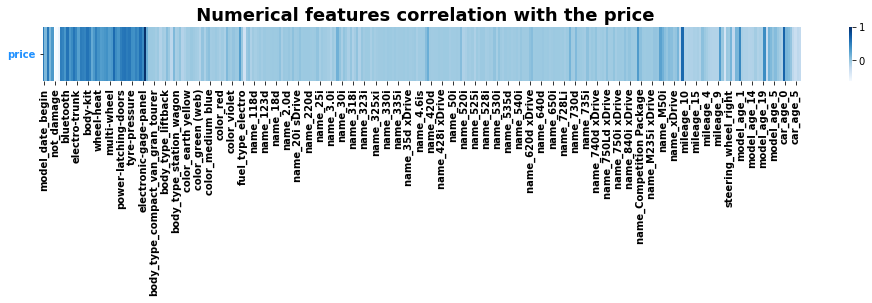

In [189]:
import matplotlib.pyplot as plt

num=new_big_df.select_dtypes(exclude='object')
numcorr=num.corr()
f,ax=plt.subplots(figsize=(17,1))
sns.heatmap(numcorr.sort_values(by=['price'], ascending=False).head(1), cmap='Blues')
plt.title(" Numerical features correlation with the price", weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='dodgerblue', rotation=0)


plt.show()

In [190]:
Num=numcorr['price'].sort_values(ascending=False).head(10).to_frame()

cm = sns.light_palette("cyan", as_cmap=True)

s = Num.style.background_gradient(cmap=cm)
s

,price
price,1.000000
car_age_0,0.681343
mileage_1,0.650215
glonass,0.631473
wireless-charger,0.591877
body-kit,0.581749
laser-lights,0.579888
auto-park,0.577035
apple-carplay,0.567329
led-lights,0.560554


In [136]:
# Все возможные типы топлива
fuel_type_uniq = new_train['fuel_type'].unique()
fuel_type_uniq

array(['gasoline', 'diesel', 'hybrid', 'electro'], dtype=object)

In [140]:
# Формирование dummy- столбцов для топлива
new_train_extend = pd.concat([new_train, 
                              pd.get_dummies(new_train['fuel_type'])], 
                             axis=1)

In [141]:
# Коэффициенты корреляции
fuel_type_corr = new_train_extend[fuel_type_uniq].corr()
fuel_type_corr

,gasoline,diesel,hybrid,electro
gasoline,1.000000,-0.989343,-0.081378,-0.054541
diesel,-0.989343,1.000000,-0.039736,-0.026632
hybrid,-0.081378,-0.039736,1.000000,-0.002191
electro,-0.054541,-0.026632,-0.002191,1.000000


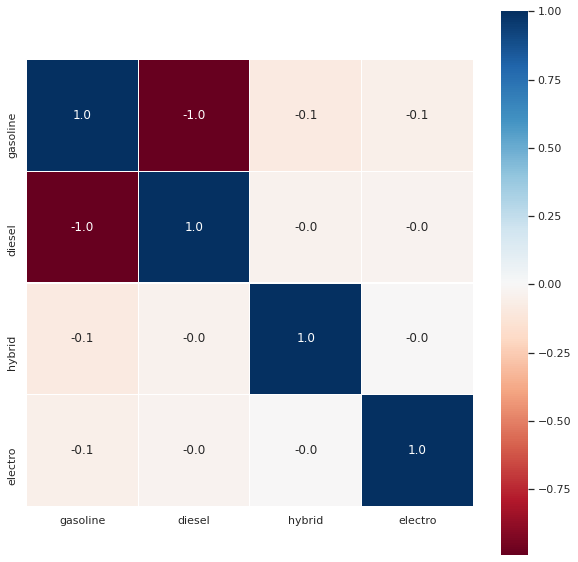

In [142]:
# Тепловая карта
sns.set(font_scale=1)
plt.subplots(figsize=(10, 10))
sns.heatmap(fuel_type_corr, square=True, 
           annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

Вижу мультиколлениарную зависимость между бензином и дизелем. Надо убрать один из признаков. P.S. По факту оказалось, что это значительно снижает качество предсказания, поэтому отказался от удаления.

In [ ]:
### Drop fuel_type_gasoline
new_big_df.drop('fuel_type_gasoline', axis=1, inplace=True)

In [143]:
def outliers_iqr(ys):
    # Определяет номера значений с отклонением больше чем iqr
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - 1.5*iqr
    upper_bound = quartile_3 + 1.5*iqr
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

Проверим на выбросы цены

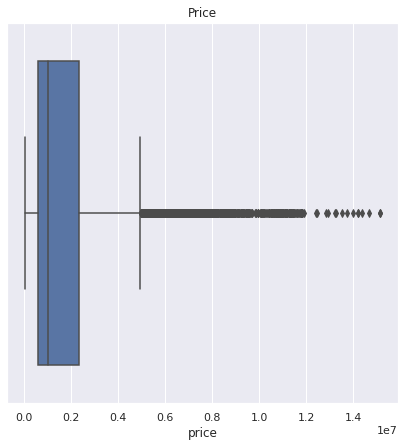

In [160]:
fig = plt.figure(figsize=(7, 7))
plt.grid(True)
plt.title('Price')
sns.boxplot(x = new_train['price'])

С выбросами цен ничего делать пока не буду.

In [153]:
new_train_corr = new_train.corr()
new_train_corr

,model_date_begin,number_of_doors,production_date,engine_displacement,engine_power,not_damage,owners,exp_year,high-beam-assist,front-seats-heat-vent,...,auto-park,bas,isofix,tyre-pressure,air-suspension,decorative-interior-lighting,360-camera,wireless-charger,electronic-gage-panel,price
model_date_begin,1.000000,0.211191,0.985691,-0.109211,0.196452,NaN,-0.603246,-0.792520,0.412114,0.261230,...,0.476758,0.475002,0.559168,0.502700,0.195961,0.448280,0.226277,0.329468,0.283839,0.643219
number_of_doors,0.211191,1.000000,0.204971,0.067357,0.091721,NaN,-0.138540,-0.073440,0.065809,0.039445,...,0.076856,0.079647,0.129433,0.077666,0.097323,0.030656,0.060701,0.056445,0.041683,0.125134
production_date,0.985691,0.204971,1.000000,-0.131576,0.180051,NaN,-0.626859,-0.812292,0.419957,0.257967,...,0.486701,0.486205,0.571196,0.512922,0.190405,0.459686,0.221833,0.336911,0.284268,0.656279
engine_displacement,-0.109211,0.067357,-0.131576,1.000000,0.834609,NaN,0.143312,0.115350,0.094193,0.251432,...,-0.076936,-0.068423,-0.131150,-0.050753,0.183507,-0.063233,0.180449,0.112690,0.122457,0.138483
engine_power,0.196452,0.091721,0.180051,0.834609,1.000000,NaN,-0.060322,-0.169382,0.244839,0.369928,...,0.049411,0.061268,0.065403,0.117832,0.210477,0.060690,0.302628,0.228219,0.230812,0.415372
not_damage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
owners,-0.603246,-0.138540,-0.626859,0.143312,-0.060322,NaN,1.000000,0.620131,-0.394337,-0.228697,...,-0.513319,-0.492632,-0.490581,-0.443745,-0.192691,-0.468429,-0.200478,-0.352199,-0.269273,-0.615719
exp_year,-0.792520,-0.073440,-0.812292,0.115350,-0.169382,NaN,0.620131,1.000000,-0.408110,-0.256506,...,-0.480515,-0.465889,-0.531833,-0.477555,-0.185940,-0.442628,-0.216837,-0.331411,-0.267901,-0.639448
high-beam-assist,0.412114,0.065809,0.419957,0.094193,0.244839,NaN,-0.394337,-0.408110,1.000000,0.488585,...,0.496749,0.498773,0.451208,0.548639,0.381770,0.556279,0.380844,0.551764,0.522533,0.595075
front-seats-heat-vent,0.261230,0.039445,0.257967,0.251432,0.369928,NaN,-0.228697,-0.256506,0.488585,1.000000,...,0.380836,0.329793,0.281985,0.354823,0.511464,0.338668,0.545512,0.550134,0.512967,0.565322


Пройдусь по всем признакам и найду те, которые имеют высокую корреляцию с другими. Это будут наши претенденты на удаление.

In [188]:
# Create correlation matrix
corr_matrix = new_train.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(to_drop)

# Drop features 
new_big_df.drop(to_drop, axis=1, inplace=True)

['production_date']


P.S. По факту оказалось, что это значительно снижает качество предсказания, поэтому отказался от удаления.

# What's next?
Или что еще можно сделать, чтоб улучшить результат:

* Посмотреть, что можно извлечь из признаков или как еще можно обработать признаки
* Сгенерировать новые признаки
* Подгрузить еще больше данных
* Попробовать подобрать параметры модели
* Попробовать другие алгоритмы и библиотеки ML
* Сделать Ансамбль моделей, Blending, Stacking